In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
"""
Copyright (c) Meta Platforms, Inc. and affiliates.

This source code is licensed under the CC BY-NC license found in the
LICENSE.md file in the root directory of this source tree.
"""
import pickle
import random
import time
import gym
import numpy as np

import sys
import os
from munch import Munch
import yaml

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from PIL import Image
import os
import pandas as pd


from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from PIL import Image


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)


cuda:1


In [4]:
df = pd.read_csv('ema.csv', sep=',')
df = df.sort_values(['subid', 'dttm_obs'])[['dttm_obs', 'subid', 'ema_1', 'ema_2', 'ema_3', 'ema_4', \
                                            'ema_5', 'ema_6', 'ema_7', 'ema_8', 'ema_9', 'ema_10']]

# Handling NA: drop the entire row if 4th entry is NA 
# For morning-only survey, set dummy=1 if survey reported, otherwise dummy=0
df = df.fillna(-6.0)
df = df[df['ema_4'] > -1]
df['ema_dummy'] = (df['ema_8'] > -1)
df.loc[df['ema_8'] < 0, ['ema_8', 'ema_9', 'ema_10']] = 0

# Encoding: 'Yes/No -> 0/1'
df = df.replace('No',0)
df = df.replace('Yes',1)

# Date-time encoding -- in hour unit 
df['date'] = (pd.to_datetime(df['dttm_obs']).astype('int64') // (10**9)) / 3600
df2 = df[['subid', 'ema_1', 'ema_2', 'ema_3', 'ema_4', \
            'ema_5', 'ema_6', 'ema_7', 'ema_8', 'ema_9', 'ema_10', 'ema_dummy', 'date']]


time_df = pd.read_csv('labels_1day.csv', sep=',')
time_df = time_df.sort_values(['subid', 'dttm_label']) 
time_df['date'] = (pd.to_datetime(time_df['dttm_label']).astype('int64') // (10**9)) / 3600
time_df = time_df.replace('no',0)
time_df = time_df.replace('yes',1)

time_df = time_df[['subid', 'lapse', 'date']]

In [5]:
def input_data(org_data, time_label):
    # 24hr window right-index
    fj = 0    
    
    # offset starting date-time to 0 
    offset_time = org_data[0,-1] + 0.0
    org_data[:,-1] -= offset_time
    time_label[:,-1] -= offset_time
    
    dataset = []
    tq = ts = 0
    while(tq < time_label.shape[0] and ts < org_data.shape[0] ):
        cmax = min(ts+5, org_data.shape[0])
        if(tq < time_label.shape[0] and time_label[tq, -1] < org_data[ts, -1]):
            y = 1 if( time_label[tq,1] > 0 ) else 0
            dataset.append({'type':'query', 'out': y, 'time': time_label[tq,-1], 'obs': org_data[ts,1:-1]+0.0 })
            while(tq < time_label.shape[0] and time_label[tq,-1] < org_data[ts,-1] ):
                tq += 1
        else:
            y = 1 if( tq < time_label.shape[0] and time_label[tq,1] > 0 ) else 0
            dataset.append({'type':'survey', 'obs': org_data[ts, 1:-1]+0.0, 'time': org_data[ts,-1], 'out':y})
            ts += 1

    return dataset


In [6]:
raw_data = df2.values.astype(np.float32)
time_raw_data = time_df.values.astype(np.float32)

env_list, subid_list = [], []
print_list = []
for subid in range(270):
    sub_data = raw_data[raw_data[:,0]==(subid+1)]
    time_label = time_raw_data[time_raw_data[:,0]==(subid+1)]
    if( len(sub_data) == 0 or len(time_label) == 0 ):
        continue
          
    subid_list.append(subid)
    print_list.append(subid+1)
    env_list.append(input_data(sub_data, time_label))

print(print_list)

[1, 2, 3, 5, 6, 7, 9, 10, 11, 15, 16, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 42, 43, 44, 47, 48, 51, 52, 53, 54, 56, 58, 59, 63, 64, 65, 66, 74, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 88, 90, 92, 93, 94, 97, 98, 99, 100, 103, 109, 110, 116, 117, 118, 119, 121, 128, 130, 131, 134, 135, 136, 137, 138, 139, 143, 149, 150, 156, 158, 161, 162, 163, 166, 167, 169, 171, 172, 175, 178, 179, 180, 181, 183, 185, 187, 188, 189, 190, 191, 192, 193, 196, 197, 200, 201, 203, 205, 207, 208, 209, 211, 212, 213, 214, 215, 218, 221, 222, 223, 224, 225, 230, 231, 232, 234, 236, 238, 240, 241, 242, 243, 245, 248, 252, 255, 259, 262, 263, 264, 265, 268, 270]


In [33]:
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from env import calculate_feature
from sklearn.model_selection import train_test_split

def input_xgboost_data(org_data, time_label):
    j = [0,0,0,0,0]
    fj = 0
    window = [12, 24, 48, 72, 168]
    
    dataset = []
    tq = ts = 0

    while( ts < org_data.shape[0] ):
        while(tq < time_label.shape[0] and time_label[tq,-1] < org_data[ts,-1] ):
            tq += 1
            
        if( tq >= time_label.shape[0] ):
            break
            
        time = time_label[tq,-1]
        while( ts < org_data.shape[0] and org_data[ts,-1] <= time ):
            ts += 1
        
        for k in range(5):
            while( j[k] < ts-1 and org_data[j[k], -1] < time - window[k] ):
                j[k] = j[k] + 1

        # included how many surveys are missing in the period?
        X = calculate_feature(org_data[:ts, 1:-1], org_data[ts-1, 1:-1], j)        
        y = 1 if (time_label[tq,1] > 0 ) else 0        
        dataset.append({'in':X, 'out':y})

    return dataset


def xgboost_main(train_index, test_index):
    trainset = []
    for m in train_index:
        subid = subid_list[m] + 1
        sub_data = raw_data[raw_data[:,0] == subid] 
        time_label = time_raw_data[time_raw_data[:,0]==subid]                
        trainset.extend(input_xgboost_data(sub_data, time_label))

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=500000, shuffle=True, drop_last=False)

    testset = []
    for m in test_index:
        subid = subid_list[m] + 1
        sub_data = raw_data[raw_data[:,0] == subid]     
        time_label = time_raw_data[time_raw_data[:,0]==subid]                
        testset.extend(input_xgboost_data(sub_data, time_label))

    test_loader = torch.utils.data.DataLoader(testset, batch_size=60000, shuffle=False, drop_last=False)
    
    # XG Boost Train
    data_iter = iter(train_loader)
    train_data = next(data_iter)
    X = train_data['in']
    y = train_data['out']

    test_iter = iter(test_loader)
    test_data = next(test_iter)

    # Create regression matrices
    dtrain_reg = xgb.DMatrix(X, y)

    X_test = test_data['in']
    y_test = test_data['out']
    dtest_reg = xgb.DMatrix(X_test, y_test)

    params = {"objective": "reg:squarederror", "tree_method": "hist", "device": "cuda", "max_depth": 5}
    print(X.shape, X_test.shape)
    
    n = 10
    xgmodel = xgb.train(
       params=params, 
       dtrain=dtrain_reg,
       num_boost_round=n,
    )

    preds = xgmodel.predict(dtest_reg)
    print(len(y_test[y_test>0]), len(preds[preds>0.1]), len(preds))
    xgauc = roc_auc_score(y_test, preds)
    print('XgBoost: AUC = %.2f' % xgauc)

    
    ###################################################
    # Full FCN Train Comparison                       
    ###################################################    
    from model import Prediction_Network
    print(X.shape)
    myFCN = Prediction_Network(X.shape[1], 2)
    weight_decay = 5e-3
    learning_rate = 3e-5
    optimizer = torch.optim.Adam([{'params': myFCN.parameters(), 'lr': learning_rate, 'weight_decay': weight_decay}])

    ce_loss = torch.nn.CrossEntropyLoss(reduction='none')
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, drop_last=False)
    data_iter = iter(train_loader)
    for t in range(3000):
        try:
            data = next(data_iter)
            xbatch = data['in'].to(torch.float32)
            ybatch = data['out']

            out_y = myFCN(xbatch)
            predict_loss = ce_loss(out_y, ybatch).mean()

            #if( t % 100 == 0 ):
            #    print('loss:' , predict_loss)

            predict_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        except StopIteration:
            train_loader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, drop_last=False)
            data_iter = iter(train_loader)
    
    print(predict_loss)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=True, drop_last=False)
    data_iter = iter(test_loader)            
    ylist = []
    out_ylist = []
    for t in range(50):
        try:
            data = next(data_iter)
            xbatch = data['in'].to(torch.float32)
            ybatch = data['out']

            embed_x = myFCN(xbatch)
            out_y = nn.Softmax(dim=-1)(embed_x).detach().cpu()
            ylist.extend(ybatch)
            out_ylist.extend(out_y[:,1])
            
        except StopIteration:
            break
    
    # print(ylist, out_ylist)
    fcauc = roc_auc_score(ylist, out_ylist)
    print('myFCN: AUC = %.2f' % fcauc)  #1
    print('---------------------------------------------------')
            
    return xgauc, fcauc

xglist, fcnlist = [], []

for k in range(50):
    shuffled_index = list(range(151))
    random.shuffle(shuffled_index)
    st,et = 0, 151//10
    test_index = shuffled_index[st:et]
    train_index = list(set(range(151)) - set(test_index))
    x,f = xgboost_main(train_index, test_index)
    xglist.append(x)
    fcnlist.append(f)
    
from numpy import mean, median
print('xg: ', mean(xglist), median(xglist))
print('fcn: ', mean(fcnlist), median(fcnlist))




torch.Size([33646, 173]) torch.Size([3570, 173])
391 965 3570
XgBoost: AUC = 0.88
torch.Size([33646, 173])
tensor(0.1716, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.86
---------------------------------------------------
torch.Size([33232, 173]) torch.Size([3984, 173])
360 998 3984
XgBoost: AUC = 0.89
torch.Size([33232, 173])
tensor(0.1490, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
torch.Size([33463, 173]) torch.Size([3753, 173])
392 891 3753
XgBoost: AUC = 0.95
torch.Size([33463, 173])
tensor(0.1788, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.94
---------------------------------------------------
torch.Size([33489, 173]) torch.Size([3727, 173])
125 350 3727
XgBoost: AUC = 0.96
torch.Size([33489, 173])
tensor(0.1714, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.95
---------------------------------------------------
torch.Size([33553, 173]) torch.Size([3663, 173])
345 752 3663
XgBoost: AUC = 0.92
torch.Size([33553, 173])
tensor(0.1376, grad_fn=<M

torch.Size([33475, 173]) torch.Size([3741, 173])
357 791 3741
XgBoost: AUC = 0.92
torch.Size([33475, 173])
tensor(0.1730, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.93
---------------------------------------------------
torch.Size([33620, 173]) torch.Size([3596, 173])
463 893 3596
XgBoost: AUC = 0.94
torch.Size([33620, 173])
tensor(0.1929, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.93
---------------------------------------------------
torch.Size([33409, 173]) torch.Size([3807, 173])
235 500 3807
XgBoost: AUC = 0.95
torch.Size([33409, 173])
tensor(0.1756, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.92
---------------------------------------------------
torch.Size([33653, 173]) torch.Size([3563, 173])
560 1500 3563
XgBoost: AUC = 0.85
torch.Size([33653, 173])
tensor(0.1578, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.85
---------------------------------------------------
torch.Size([33736, 173]) torch.Size([3480, 173])
184 579 3480
XgBoost: AUC = 0.76
torch.Size([33736, 173])
tensor(0.1702, grad_fn=<

# Environment

In [34]:
from env import Env, VecEnv

# parallel env runs
num_process = 31

# action encoding: 
# 0 - no survey or predict
# 1 - yes survey or predict
action_dim = 1
action_max = 2

# feature encoding: mean of survey items
feature_dim = 11

# y encoding
# 0 - no lapse within 24hr
# 1 - yes lapse within 24hr
state_dim, embed_dim, y_max = 173, 128, 2

# Reinforcement Learning

In [35]:

# train function (without extra features)
def train(venv, model, agent, feature_optimizer, predict_buffer, max_iter = 10, freq=1):

    ce_criterion = torch.nn.CrossEntropyLoss(reduction='none')
    mse_criterion = torch.nn.MSELoss(reduction='none')
    
    for episode in range(max_iter):
        X, info = venv.reset(mode='train')

        # initialize buffers / debug variables
        sample_traj = []
        predict_samples = []
        
        # generate trajectories
        for t in range(1000):
            PX = X
            p = random.random()
            actions = torch.zeros(num_process, action_dim).to(int)
            if( t < 10 or p < 1. / freq ):
                actions = actions + 1

            X, rewards, dones, infos = venv.step(actions)        
            all_done = True
            
            for i in range(num_process):
                if( infos[i] == -1 ):
                    continue
                
                all_done = False
                if (infos[i]['type'] == 'survey'):
                    pass
                else:
                    predict_samples.append({'in': PX[i], 'out': infos[i]['lapse']})

            if( all_done ): 
                break
                
        # print('episode ', episode )#, measured_ta, measured_tr)
        predict_buffer.add_episodes(predict_samples)
        
    #######################################################
    # Training Phase        
    #######################################################
    # 1. train prediction first
    feat_train_loaders = predict_buffer.get_loader()
    feat_data_iter = iter(feat_train_loaders)

    for j in range(0, 2500):
        try:
            traj = next(feat_data_iter)

            refs = traj['in'].to(device)
            out_ys, out_features = model(refs)
            ys = traj['out'].to(device).reshape(-1)

            predict_loss = ce_criterion(out_ys, ys).mean()
            predict_loss.backward()

            feature_optimizer.step()
            feature_optimizer.zero_grad()

        except StopIteration:
            feat_train_loaders = predict_buffer.get_loader()
            feat_data_iter = iter(feat_train_loaders)
            continue

    print(predict_loss)

In [36]:

def test(venv, model, agent, mode='policy', run_id=0, kfold_id=0, penalty=-1., freq=1):
    scatter = []
    num_process = len(venv.test_ids)
    
    cnt, n_measure, n_hit = [0 for i in range(num_process)], [0 for i in range(num_process)], [0 for i in range(num_process)]
    y, outy = [], []

    obs, info = venv.reset(mode='test')
    types = torch.zeros(num_process,1).to(int).to(device)
    for t in range(1000):
        p = random.random()
        actions = torch.zeros(num_process, action_dim).to(int)
        if( t < 10 or p < 1. / freq ):
            actions = actions + 1
            
        X, rewards, dones, infos = venv.step(actions)
        predict_ys, _ = model(X.to(device))
        predict_ys = predict_ys.detach()
   
        # add transition data to dataset
        all_done = True
        for i in range(num_process):
            if( infos[i] == -1 ):
                continue

            all_done = False
            if (infos[i]['type'] == 'query'):
                check_y = nn.Softmax(dim=-1)(predict_ys[i]).reshape(y_max).detach().cpu()                
                y.append(infos[i]['lapse'])
                outy.append(check_y[1])
                
            else:
                cnt[i] += 1
                n_measure[i] += 1 if( actions[i] % 2 == 1 ) else 0
                n_hit[i] += 1 if( X[i,0] > 0 ) else 0
                                    
            types[i] = 1 if( infos[i]['next_type'] == 'query' ) else 0

        if( all_done ): 
            break

    for i in range(num_process):
        scatter.append([n_measure[i]/cnt[i], n_hit[i]/cnt[i]])
        # print(venv.test_ids[i], ':', n_measure[i], n_hit[i], cnt[i])
    
    path = os.path.join("./results", f"run_{run_id}_kfold_{kfold_id}_penalty_{penalty}.pt")
    things_to_save = {
        'test_ids': venv.test_ids,
        'model_state_dict': model.state_dict(),
        'agent_state_dict': agent.save_dict()
    }
    torch.save(things_to_save, path)
    
    scatter = np.array(scatter)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4, 3))  

    plt.scatter(scatter[:,1], scatter[:,0])
    plt.xlabel("Average Lapse Count")
    plt.ylabel("Survey Ratio")
    plt.show()

    print('Average Survey Ratio:', np.mean(scatter[:,0]))

    import xgboost as xgb
    from sklearn import metrics
    from sklearn.metrics import roc_auc_score
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split

    fgauc = roc_auc_score(y, outy)
    print('AUC = %.2f' % fgauc)  #1
    return fgauc
    
    

# Test

In [37]:
import random
from SACD import init_SACD_agent
from model import build_model
from buffer import ReplayBuffer
  
import torch.nn.functional as F
import time
import copy

# weight-decay params: {1e-3, 5e-4, 1e-4, 5e-5, 1e-5}

def k_fold_test(k=5, run_id=0):
    shuffled_index = list(range(151))
    random.shuffle(shuffled_index)

    AUC_dict={}
    AUC_dict['xg'] = []
    for freq in [1,2,4,10,20]:
        AUC_dict[freq] = []
        
    for i in range(k):
        st,et = i*151//k, (i+1)*151//k

        test_index = shuffled_index[st:et]
        train_index = list(set(range(151)) - set(test_index))
        xgauc, _ = xgboost_main(train_index, test_index)
        AUC_dict['xg'].append(xgauc)
        
        venv = VecEnv(env_list, train_index, test_index, num_process=num_process, state_dim=state_dim)
        
        model = build_model(embed_dim, state_dim, action_dim, feature_dim, action_max, \
                            y_max, model_family='gpt2').to(device)
        agent = init_SACD_agent(state_dim, action_dim, action_max, device, weight_decay=1e-4, \
                                lr_actor=1e-4, lr_critic=2e-4, entropy_regularizer=0.03)
        feature_optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 3e-5, 'weight_decay': 5e-3}])
        predict_buffer = ReplayBuffer()

        # init predictor part
        venv.set_probe_penalty(0.1)
        train(venv, model, agent, feature_optimizer, predict_buffer, max_iter=20, burn_in=10)
        # Test full observation-prediction
        fcauc = test(venv, model, agent, 'full', run_id=run_id, kfold_id=i)
        AUC_dict[1].append(fcauc)
        
        for freq in [2,4,10,20]:
            venv.set_probe_penalty(freq * 0.05)
            train(venv, model, agent, feature_optimizer, predict_buffer, max_iter=20, burn_in=10, freq=freq)
            fcauc = test(venv, model, agent, run_id=run_id, kfold_id=i, freq=freq)
            AUC_dict[freq].append(fcauc)
            
        print('-----------------------------------------------')
        
    print(AUC_dict)
    return AUC_dict

torch.Size([30291, 173]) torch.Size([6925, 173])
906 1943 6925
XgBoost: AUC = 0.92
torch.Size([30291, 173])
tensor(0.1570, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.92
---------------------------------------------------
Device set to : cuda:1
tensor(0.2314, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1997, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1510, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1762, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1965, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1797, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1782, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1753, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1387, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1989, device='cuda:1', grad_fn=<MeanBackward0>)


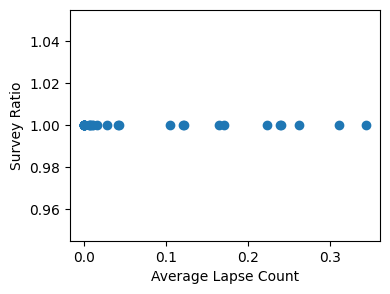

Average Survey Ratio: 1.0
AUC = 0.92
tensor(0.2052, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2102, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2080, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1704, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1993, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1778, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1804, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1981, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1593, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1618, device='cuda:1', grad_fn=<MeanBackward0>)


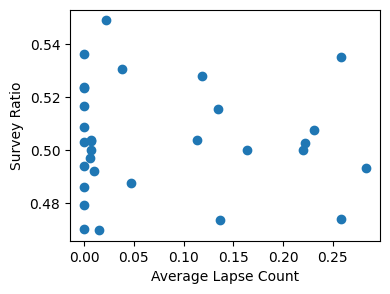

Average Survey Ratio: 0.5035072781517911
AUC = 0.91
tensor(0.1668, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1865, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1782, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1837, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1386, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2088, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1549, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1761, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1517, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1848, device='cuda:1', grad_fn=<MeanBackward0>)


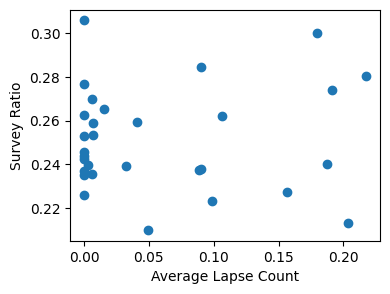

Average Survey Ratio: 0.2513316195420133
AUC = 0.89
tensor(0.1737, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1718, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1726, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1354, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1775, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2076, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2143, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2109, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1484, device='cuda:1', grad_fn=<MeanBackward0>)


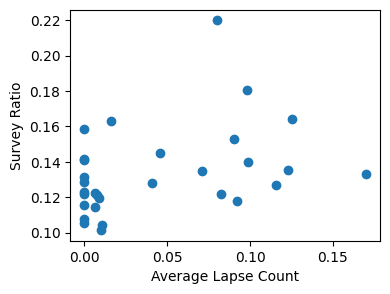

Average Survey Ratio: 0.1340838169000758
AUC = 0.89
tensor(0.1390, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1408, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1768, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1786, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1468, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1630, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1745, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2196, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1545, device='cuda:1', grad_fn=<MeanBackward0>)


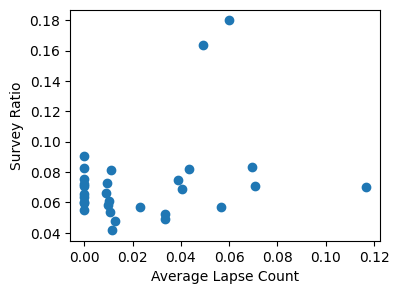

Average Survey Ratio: 0.07286857578492976
AUC = 0.85
-----------------------------------------------
torch.Size([29730, 173]) torch.Size([7486, 173])
373 1243 7486
XgBoost: AUC = 0.85
torch.Size([29730, 173])
tensor(0.2933, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.83
---------------------------------------------------
Device set to : cuda:1
tensor(0.2721, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2073, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2355, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1892, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2010, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1911, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1438, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1459, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1605, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2270, device='cuda:1', grad_fn=<MeanBackward0>)


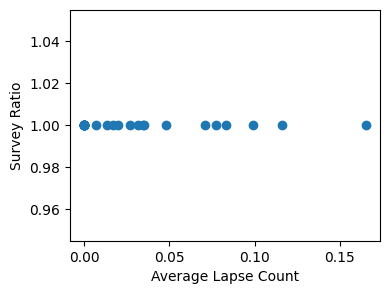

Average Survey Ratio: 1.0
AUC = 0.83
tensor(0.1992, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1669, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1533, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1706, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1654, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1738, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1584, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1861, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1724, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1717, device='cuda:1', grad_fn=<MeanBackward0>)


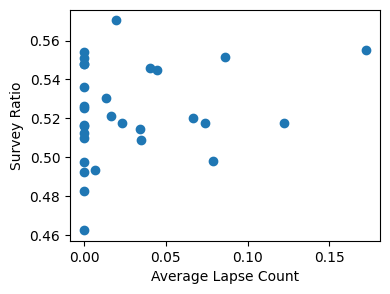

Average Survey Ratio: 0.5229176200720504
AUC = 0.81
tensor(0.2263, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1601, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1738, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1651, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1874, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1616, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1842, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1919, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2033, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1977, device='cuda:1', grad_fn=<MeanBackward0>)


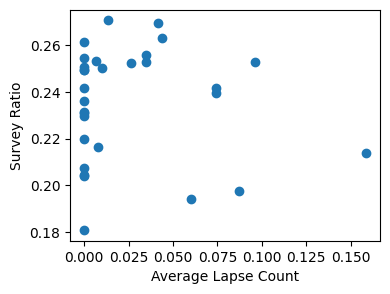

Average Survey Ratio: 0.23579761704476235
AUC = 0.83
tensor(0.1998, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1994, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2139, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2225, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1924, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2049, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1906, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2290, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1816, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1766, device='cuda:1', grad_fn=<MeanBackward0>)


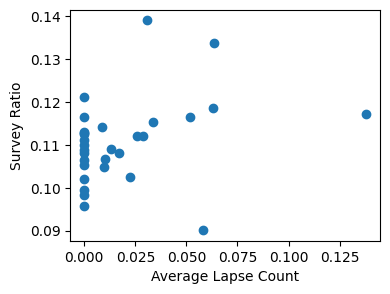

Average Survey Ratio: 0.11069725103873046
AUC = 0.84
tensor(0.2286, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2315, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2477, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2205, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2160, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2324, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1689, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2257, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2080, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2124, device='cuda:1', grad_fn=<MeanBackward0>)


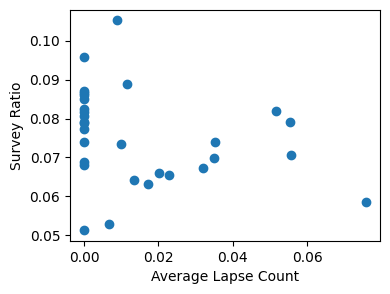

Average Survey Ratio: 0.07543354615244247
AUC = 0.81
-----------------------------------------------
torch.Size([30292, 173]) torch.Size([6924, 173])
821 2080 6924
XgBoost: AUC = 0.89
torch.Size([30292, 173])
tensor(0.1485, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.87
---------------------------------------------------
Device set to : cuda:1
tensor(0.2214, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2166, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2195, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1582, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1908, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1546, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1906, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1704, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1547, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1753, device='cuda:1', grad_fn=<MeanBackward0>)


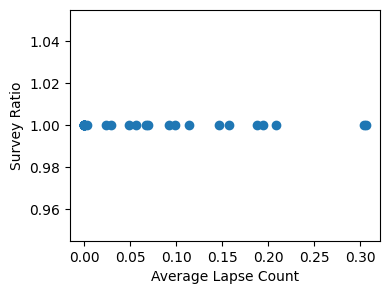

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.1633, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1559, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1857, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1644, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1630, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1837, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1668, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1659, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1255, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1608, device='cuda:1', grad_fn=<MeanBackward0>)


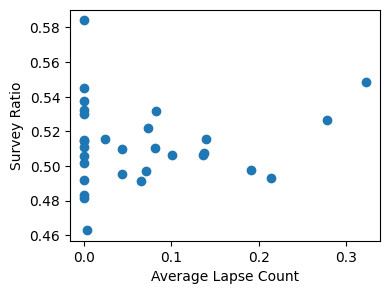

Average Survey Ratio: 0.5124187309521636
AUC = 0.84
tensor(0.1619, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1451, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1448, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1526, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2033, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1751, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1637, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1837, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1691, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1771, device='cuda:1', grad_fn=<MeanBackward0>)


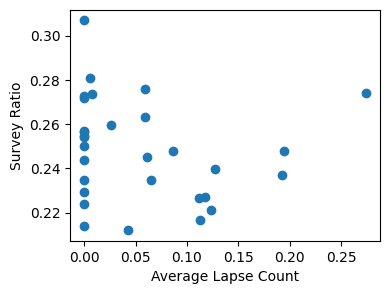

Average Survey Ratio: 0.24838016866703602
AUC = 0.85
tensor(0.1362, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1955, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1969, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1760, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1550, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1793, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1662, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1525, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1598, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1494, device='cuda:1', grad_fn=<MeanBackward0>)


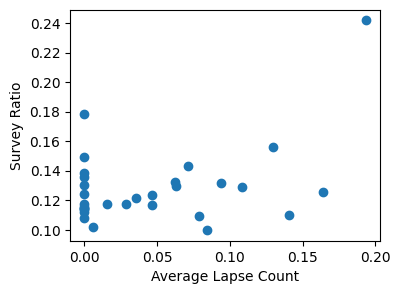

Average Survey Ratio: 0.1285718645939417
AUC = 0.84
tensor(0.2040, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2026, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1706, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1836, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1886, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1860, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1591, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1564, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1439, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1877, device='cuda:1', grad_fn=<MeanBackward0>)


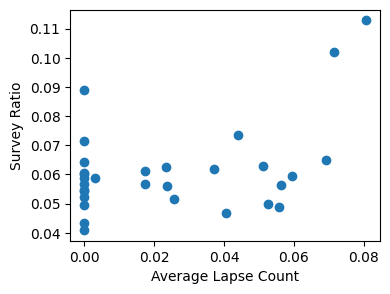

Average Survey Ratio: 0.06139918220232578
AUC = 0.82
-----------------------------------------------
torch.Size([29382, 173]) torch.Size([7834, 173])
763 1951 7834
XgBoost: AUC = 0.92
torch.Size([29382, 173])
tensor(0.1487, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.93
---------------------------------------------------
Device set to : cuda:1
tensor(0.2133, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2178, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2336, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1858, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2033, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1721, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1705, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1702, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1694, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1399, device='cuda:1', grad_fn=<MeanBackward0>)


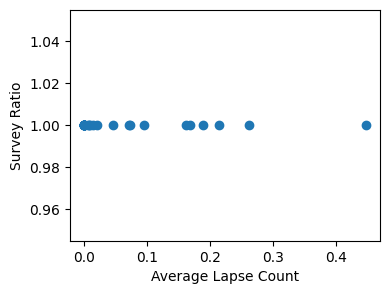

Average Survey Ratio: 1.0
AUC = 0.93
tensor(0.1843, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1741, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1862, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1865, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2167, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1822, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2127, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2265, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1904, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1775, device='cuda:1', grad_fn=<MeanBackward0>)


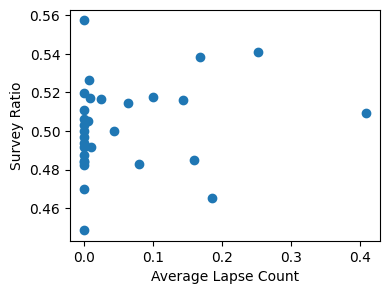

Average Survey Ratio: 0.5020698442430762
AUC = 0.92
tensor(0.1714, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1826, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2040, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1558, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1928, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1792, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2231, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2304, device='cuda:1', grad_fn=<MeanBackward0>)


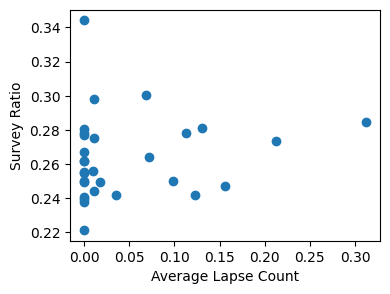

Average Survey Ratio: 0.26349432421803054
AUC = 0.91
tensor(0.1836, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1963, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1578, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1825, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1743, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1969, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2092, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1737, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2322, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1692, device='cuda:1', grad_fn=<MeanBackward0>)


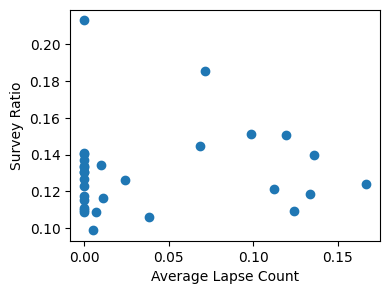

Average Survey Ratio: 0.13034529423143681
AUC = 0.90
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2313, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2356, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2075, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1912, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2174, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2354, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1991, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2057, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2265, device='cuda:1', grad_fn=<MeanBackward0>)


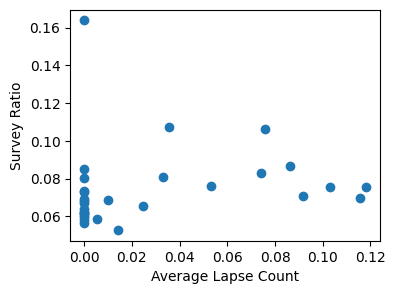

Average Survey Ratio: 0.0747139422180854
AUC = 0.90
-----------------------------------------------
torch.Size([29169, 173]) torch.Size([8047, 173])
439 1649 8047
XgBoost: AUC = 0.84
torch.Size([29169, 173])
tensor(0.1535, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.81
---------------------------------------------------
Device set to : cuda:1
tensor(0.2207, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2584, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2088, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1947, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1582, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1543, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1625, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2031, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1841, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1395, device='cuda:1', grad_fn=<MeanBackward0>)


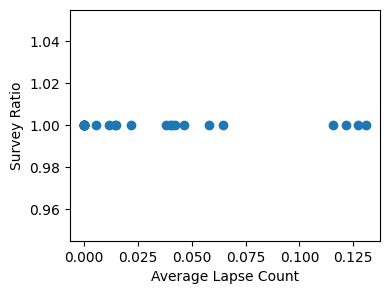

Average Survey Ratio: 1.0
AUC = 0.80
tensor(0.1603, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1854, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1988, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1710, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1718, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1887, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1594, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1611, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2442, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1478, device='cuda:1', grad_fn=<MeanBackward0>)


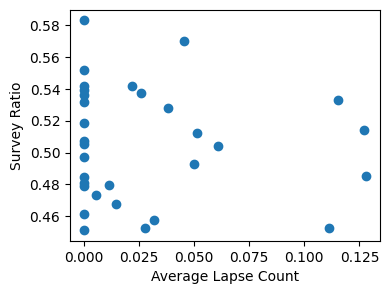

Average Survey Ratio: 0.5055219420033852
AUC = 0.79
tensor(0.1792, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1661, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1677, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1860, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1955, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1667, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1798, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1758, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1686, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2209, device='cuda:1', grad_fn=<MeanBackward0>)


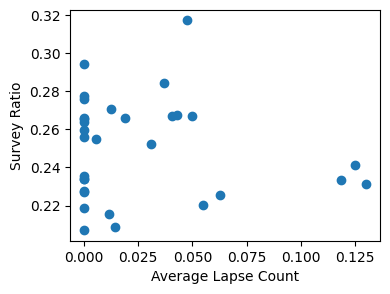

Average Survey Ratio: 0.2505357006491155
AUC = 0.78
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1691, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1679, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1526, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1794, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1973, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1550, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1815, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1923, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2012, device='cuda:1', grad_fn=<MeanBackward0>)


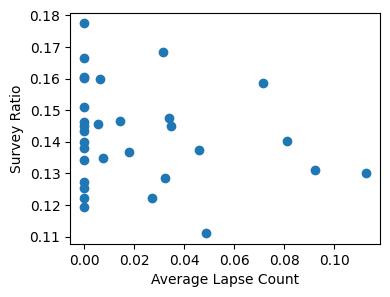

Average Survey Ratio: 0.14196690304680934
AUC = 0.79
tensor(0.2216, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1900, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1891, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1617, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2249, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1774, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1974, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2041, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2293, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2050, device='cuda:1', grad_fn=<MeanBackward0>)


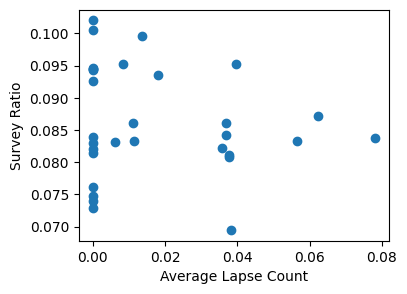

Average Survey Ratio: 0.08632044666122726
AUC = 0.78
-----------------------------------------------
{'xg': [0.9150451458534362, 0.8534273800679871, 0.8888150892424664, 0.9183742578782924, 0.8366259350545762], 1: [0.9165526971800483, 0.8261839044848216, 0.8799905320020924, 0.9317677116192566, 0.7953437096546256], 2: [0.9092535154497879, 0.8130052251117446, 0.8445912165958196, 0.9245290188099622, 0.7939757095396527], 4: [0.8931896859356702, 0.8295129674209778, 0.8450162187362977, 0.9115970887309823, 0.7821197085432192], 10: [0.8907299438459595, 0.8445415240531158, 0.841698427901216, 0.8991492024444814, 0.7895968516535765], 20: [0.8490850533281842, 0.8145379320950312, 0.81584774006434, 0.9001750268249045, 0.7765218065625681]}
torch.Size([29798, 173]) torch.Size([7418, 173])
562 1048 7418
XgBoost: AUC = 0.95
torch.Size([29798, 173])
tensor(0.1788, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.93
---------------------------------------------------
Device set to : cuda:1
tensor(0.2548, device='cu

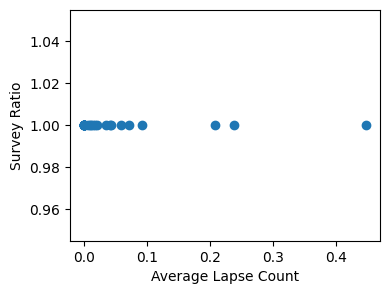

Average Survey Ratio: 1.0
AUC = 0.94
tensor(0.1954, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2166, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2079, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1849, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1936, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1909, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2119, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1925, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1939, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1957, device='cuda:1', grad_fn=<MeanBackward0>)


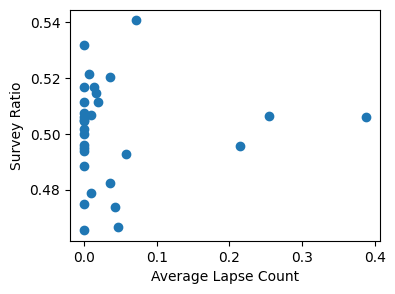

Average Survey Ratio: 0.5011545375686718
AUC = 0.92
tensor(0.1745, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1877, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1721, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1660, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1650, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2038, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2294, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1704, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2315, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1952, device='cuda:1', grad_fn=<MeanBackward0>)


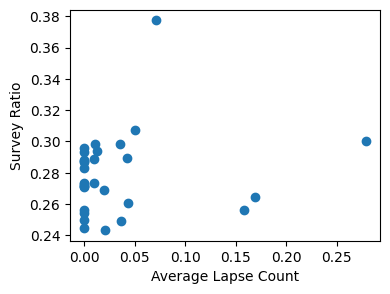

Average Survey Ratio: 0.2789920947020458
AUC = 0.93
tensor(0.1817, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1713, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2116, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2065, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2220, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2524, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2130, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2350, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1958, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2020, device='cuda:1', grad_fn=<MeanBackward0>)


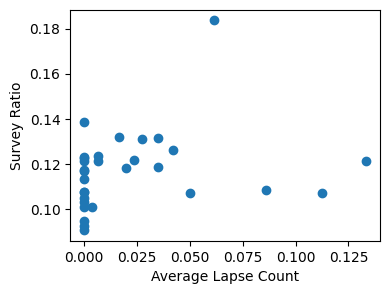

Average Survey Ratio: 0.11690875097049179
AUC = 0.92
tensor(0.2111, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2080, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2093, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2438, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1833, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2301, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1953, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2241, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2019, device='cuda:1', grad_fn=<MeanBackward0>)


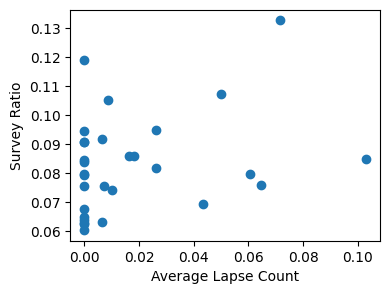

Average Survey Ratio: 0.08297911761540251
AUC = 0.90
-----------------------------------------------
torch.Size([29365, 173]) torch.Size([7851, 173])
616 2297 7851
XgBoost: AUC = 0.87
torch.Size([29365, 173])
tensor(0.1553, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.2279, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2486, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1929, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2098, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2163, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1966, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1869, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1741, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1830, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2251, device='cuda:1', grad_fn=<MeanBackward0>)


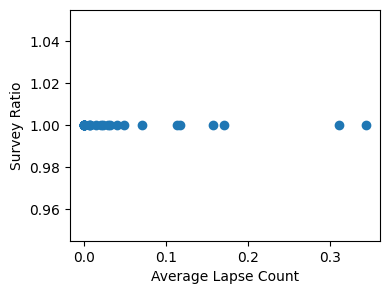

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.1885, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1323, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2063, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2126, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1674, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1543, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1933, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2071, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1728, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1805, device='cuda:1', grad_fn=<MeanBackward0>)


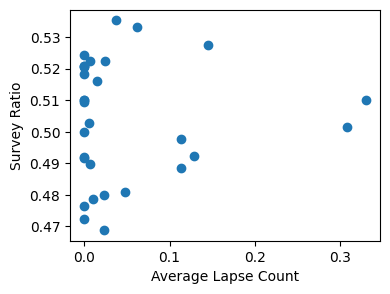

Average Survey Ratio: 0.5038280219683958
AUC = 0.87
tensor(0.2262, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1682, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1405, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1756, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1724, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1666, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2001, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1791, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2191, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1970, device='cuda:1', grad_fn=<MeanBackward0>)


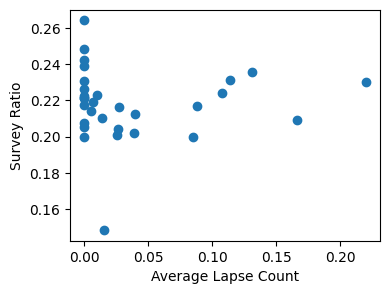

Average Survey Ratio: 0.21810819977526805
AUC = 0.85
tensor(0.1598, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2081, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1887, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1921, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1648, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1720, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1859, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1803, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1790, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1650, device='cuda:1', grad_fn=<MeanBackward0>)


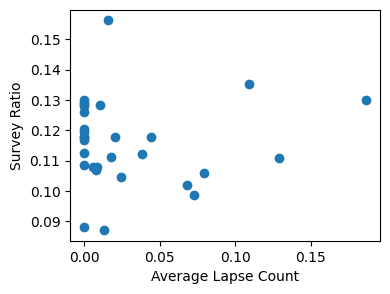

Average Survey Ratio: 0.11613314925298454
AUC = 0.85
tensor(0.2170, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1935, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1853, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1861, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2024, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1969, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2134, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1860, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2085, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2250, device='cuda:1', grad_fn=<MeanBackward0>)


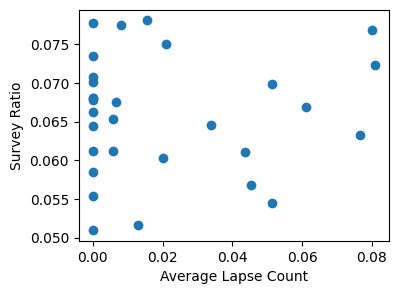

Average Survey Ratio: 0.06586366694474181
AUC = 0.86
-----------------------------------------------
torch.Size([30367, 173]) torch.Size([6849, 173])
722 2116 6849
XgBoost: AUC = 0.85
torch.Size([30367, 173])
tensor(0.1492, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.83
---------------------------------------------------
Device set to : cuda:1
tensor(0.2227, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1354, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1773, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1277, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1880, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1568, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1385, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2134, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1479, device='cuda:1', grad_fn=<MeanBackward0>)


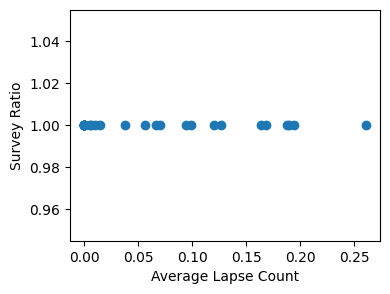

Average Survey Ratio: 1.0
AUC = 0.82
tensor(0.2274, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1665, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1488, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1934, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2195, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1628, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1638, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1452, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1501, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1808, device='cuda:1', grad_fn=<MeanBackward0>)


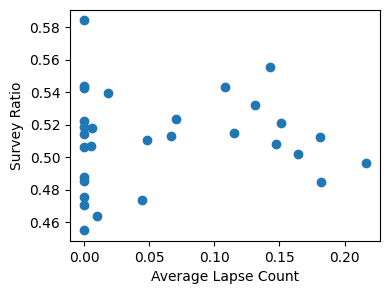

Average Survey Ratio: 0.5107985685514793
AUC = 0.81
tensor(0.1655, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1807, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1301, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1578, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2069, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1572, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2286, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2118, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1419, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1601, device='cuda:1', grad_fn=<MeanBackward0>)


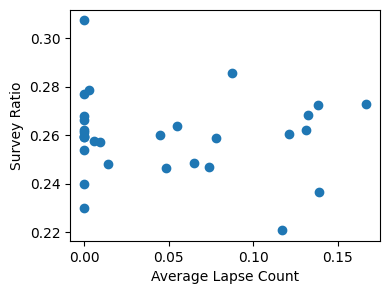

Average Survey Ratio: 0.2596557755850162
AUC = 0.79
tensor(0.1366, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1436, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1653, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1644, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2033, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1727, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1696, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1471, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1693, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1857, device='cuda:1', grad_fn=<MeanBackward0>)


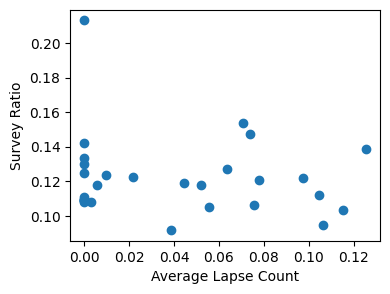

Average Survey Ratio: 0.1213381578948865
AUC = 0.79
tensor(0.2002, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1993, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1751, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1568, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1610, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1725, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1597, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1795, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1755, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2038, device='cuda:1', grad_fn=<MeanBackward0>)


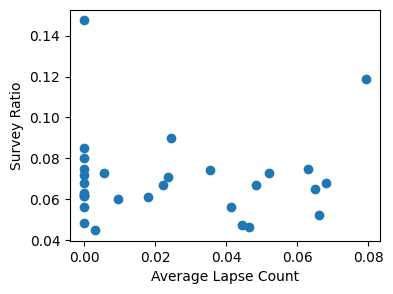

Average Survey Ratio: 0.0696910246050566
AUC = 0.79
-----------------------------------------------
torch.Size([29864, 173]) torch.Size([7352, 173])
552 1758 7352
XgBoost: AUC = 0.87
torch.Size([29864, 173])
tensor(0.2146, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.1656, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1891, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2142, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2239, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1741, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1815, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1956, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1948, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1794, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1362, device='cuda:1', grad_fn=<MeanBackward0>)


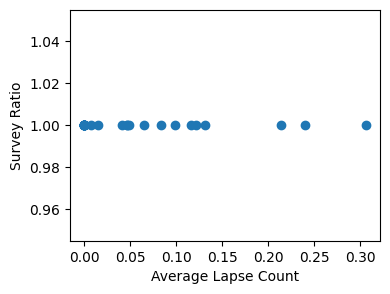

Average Survey Ratio: 1.0
AUC = 0.89
tensor(0.1686, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1677, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2029, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1552, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1742, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1403, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1623, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1705, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2274, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1723, device='cuda:1', grad_fn=<MeanBackward0>)


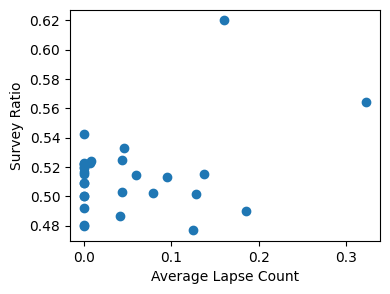

Average Survey Ratio: 0.5147411857068503
AUC = 0.87
tensor(0.1580, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1847, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1999, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1798, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1765, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1828, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1655, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1434, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1458, device='cuda:1', grad_fn=<MeanBackward0>)


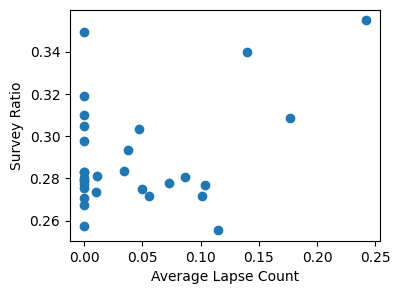

Average Survey Ratio: 0.2893242436359673
AUC = 0.85
tensor(0.1636, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1729, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2002, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1811, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1801, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1773, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1872, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1996, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1581, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1892, device='cuda:1', grad_fn=<MeanBackward0>)


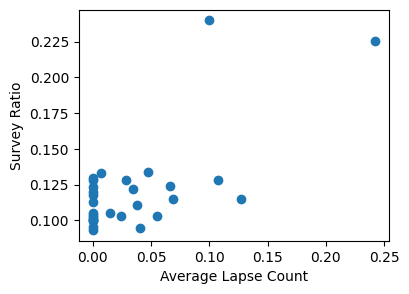

Average Survey Ratio: 0.12053029085692693
AUC = 0.84
tensor(0.1524, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1777, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1924, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1974, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1851, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2322, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2086, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1665, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1373, device='cuda:1', grad_fn=<MeanBackward0>)


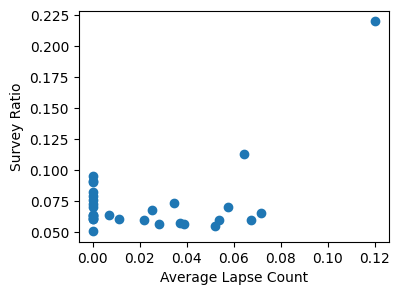

Average Survey Ratio: 0.07370211485064315
AUC = 0.83
-----------------------------------------------
torch.Size([29470, 173]) torch.Size([7746, 173])
850 2200 7746
XgBoost: AUC = 0.89
torch.Size([29470, 173])
tensor(0.1990, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.88
---------------------------------------------------
Device set to : cuda:1
tensor(0.2157, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2051, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2154, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2408, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2035, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2313, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1850, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1904, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1760, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1962, device='cuda:1', grad_fn=<MeanBackward0>)


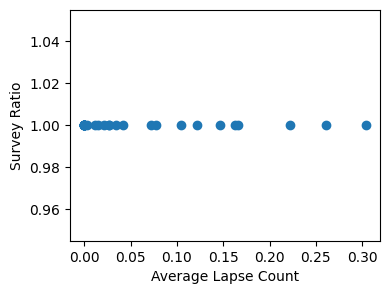

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.1498, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1552, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1892, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1837, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1421, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1542, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1686, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1887, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1899, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1685, device='cuda:1', grad_fn=<MeanBackward0>)


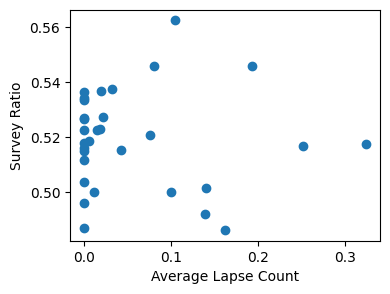

Average Survey Ratio: 0.5193167025502194
AUC = 0.87
tensor(0.1986, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1863, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1956, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1825, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2686, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1716, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1559, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1781, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1903, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1515, device='cuda:1', grad_fn=<MeanBackward0>)


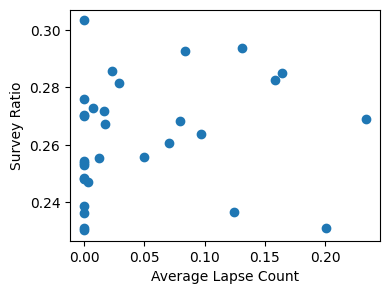

Average Survey Ratio: 0.2624161386570845
AUC = 0.86
tensor(0.1724, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2185, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1648, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1524, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1485, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2090, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1719, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1679, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2240, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1762, device='cuda:1', grad_fn=<MeanBackward0>)


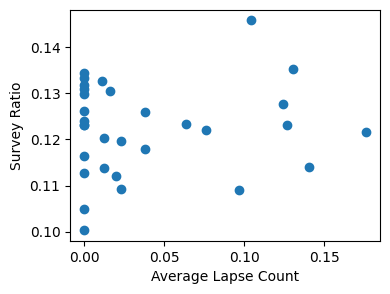

Average Survey Ratio: 0.12240311580668534
AUC = 0.88
tensor(0.2120, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1973, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2060, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1838, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1683, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1852, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2201, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2083, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1759, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1962, device='cuda:1', grad_fn=<MeanBackward0>)


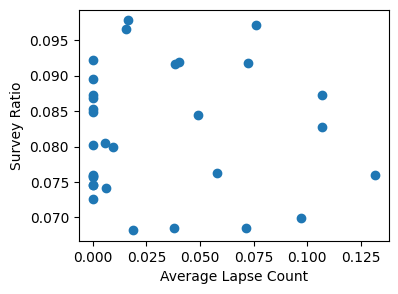

Average Survey Ratio: 0.08190341179157323
AUC = 0.87
-----------------------------------------------
{'xg': [0.9476547544400935, 0.8720154327358888, 0.8502559173396713, 0.8739284953111679, 0.8882785416951002], 1: [0.9392814356959849, 0.878231046769402, 0.8175301004092959, 0.8856135443307758, 0.8839871366179883], 2: [0.924176085990607, 0.8683083675136198, 0.809263931908491, 0.8716703964194373, 0.8661989900368501], 4: [0.9318864272455849, 0.8472660632387654, 0.7943033582340912, 0.8529251918158569, 0.8560430599153815], 10: [0.9208549697488135, 0.8498541541388812, 0.7876126829749075, 0.8409141890451833, 0.8781156168964106], 20: [0.8989855367353634, 0.8623409158222566, 0.7893687944961835, 0.826449541773231, 0.8708527535143988]}
torch.Size([29817, 173]) torch.Size([7399, 173])
592 1631 7399
XgBoost: AUC = 0.88
torch.Size([29817, 173])
tensor(0.1532, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.86
---------------------------------------------------
Device set to : cuda:1
tensor(0.2723, device='cud

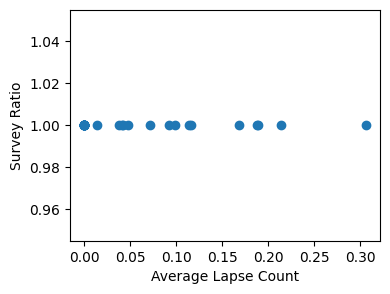

Average Survey Ratio: 1.0
AUC = 0.86
tensor(0.1544, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1598, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1755, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1367, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1614, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2105, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1664, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1841, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1956, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1424, device='cuda:1', grad_fn=<MeanBackward0>)


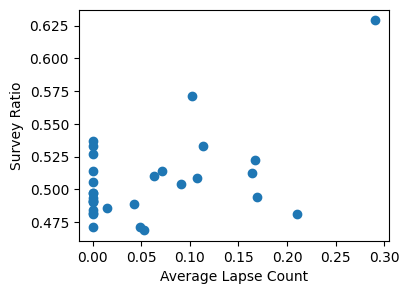

Average Survey Ratio: 0.5063349468305096
AUC = 0.86
tensor(0.2411, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1714, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1969, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1739, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2077, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1783, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1616, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1906, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1605, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1977, device='cuda:1', grad_fn=<MeanBackward0>)


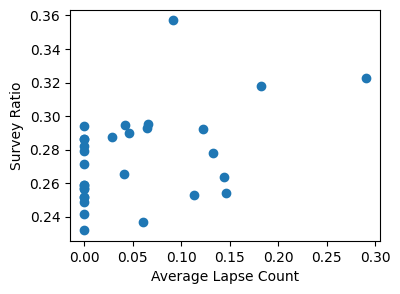

Average Survey Ratio: 0.2753069075557234
AUC = 0.83
tensor(0.1998, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1870, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1724, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2121, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1952, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2033, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1685, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1758, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2095, device='cuda:1', grad_fn=<MeanBackward0>)


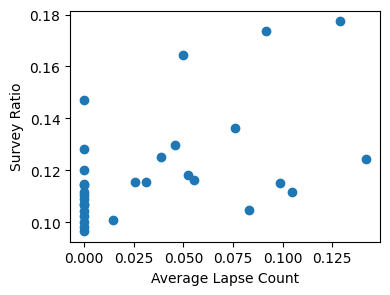

Average Survey Ratio: 0.11996070820629666
AUC = 0.82
tensor(0.2157, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1988, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1688, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1686, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1941, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2041, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2273, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1748, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1984, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1684, device='cuda:1', grad_fn=<MeanBackward0>)


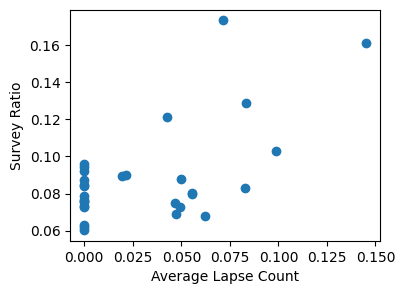

Average Survey Ratio: 0.08867086930403537
AUC = 0.83
-----------------------------------------------
torch.Size([30233, 173]) torch.Size([6983, 173])
625 1940 6983
XgBoost: AUC = 0.86
torch.Size([30233, 173])
tensor(0.1400, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.84
---------------------------------------------------
Device set to : cuda:1
tensor(0.1900, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1765, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1776, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1896, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2208, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2113, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1585, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1404, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1312, device='cuda:1', grad_fn=<MeanBackward0>)


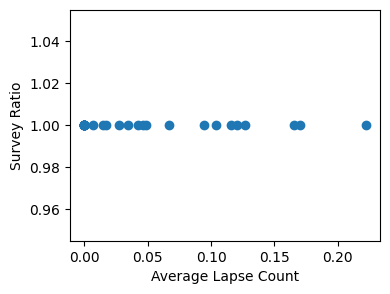

Average Survey Ratio: 1.0
AUC = 0.84
tensor(0.1555, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1627, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1471, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1616, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1751, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1633, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1388, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1749, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1090, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1665, device='cuda:1', grad_fn=<MeanBackward0>)


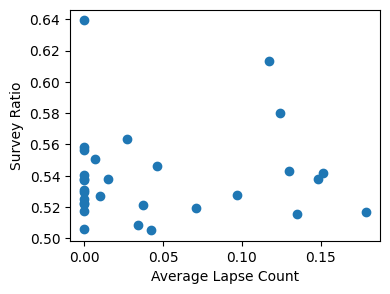

Average Survey Ratio: 0.5393835178696759
AUC = 0.83
tensor(0.1314, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2021, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1500, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1923, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2240, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1584, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1431, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1309, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1404, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1822, device='cuda:1', grad_fn=<MeanBackward0>)


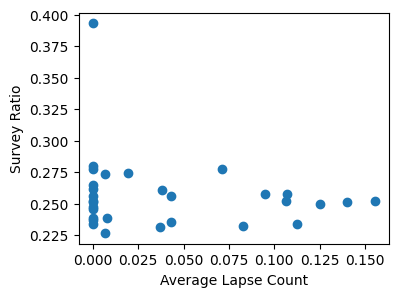

Average Survey Ratio: 0.2565889555124133
AUC = 0.83
tensor(0.1795, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1856, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1659, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1599, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2044, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1432, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1707, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1463, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1926, device='cuda:1', grad_fn=<MeanBackward0>)


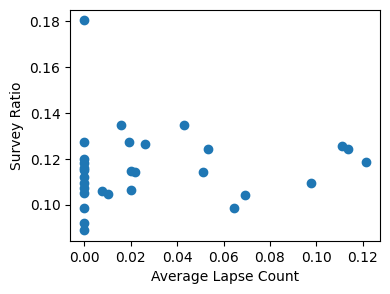

Average Survey Ratio: 0.11592241309616691
AUC = 0.82
tensor(0.1823, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1964, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1825, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1471, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2282, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1529, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1614, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1899, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2360, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2001, device='cuda:1', grad_fn=<MeanBackward0>)


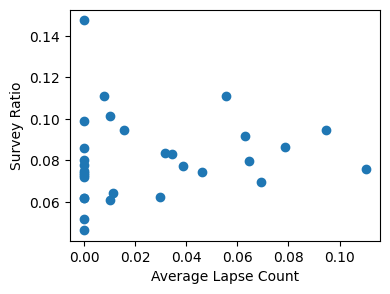

Average Survey Ratio: 0.08092324024181902
AUC = 0.83
-----------------------------------------------
torch.Size([29635, 173]) torch.Size([7581, 173])
719 1703 7581
XgBoost: AUC = 0.90
torch.Size([29635, 173])
tensor(0.2092, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2344, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2426, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2166, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1739, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1675, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1980, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1779, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2022, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1767, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1847, device='cuda:1', grad_fn=<MeanBackward0>)


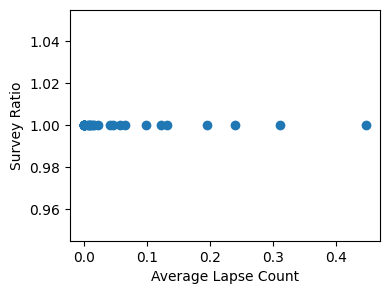

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1903, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1979, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2140, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1715, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2176, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2026, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2024, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1913, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1712, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1330, device='cuda:1', grad_fn=<MeanBackward0>)


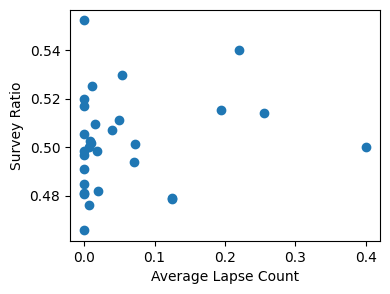

Average Survey Ratio: 0.5019451635049924
AUC = 0.88
tensor(0.1770, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1777, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1903, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1911, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2172, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1814, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1448, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1993, device='cuda:1', grad_fn=<MeanBackward0>)


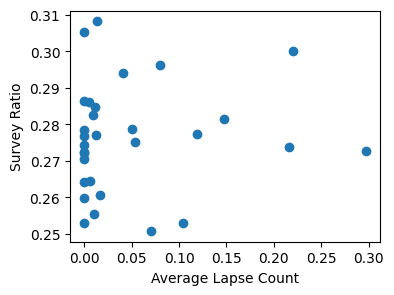

Average Survey Ratio: 0.27616368969476707
AUC = 0.88
tensor(0.1501, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1743, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1688, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1543, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2355, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1552, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1858, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1879, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1976, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)


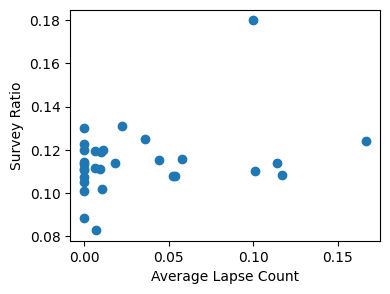

Average Survey Ratio: 0.11475565166266888
AUC = 0.87
tensor(0.1712, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2057, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1709, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2369, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1832, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2098, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1878, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2420, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2053, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2249, device='cuda:1', grad_fn=<MeanBackward0>)


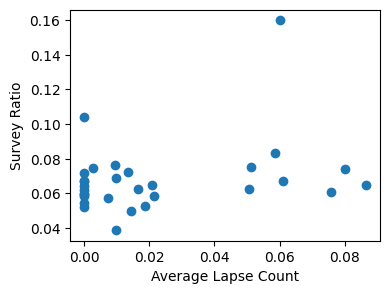

Average Survey Ratio: 0.06816159143387199
AUC = 0.85
-----------------------------------------------
torch.Size([29602, 173]) torch.Size([7614, 173])
962 2683 7614
XgBoost: AUC = 0.89
torch.Size([29602, 173])
tensor(0.1790, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2749, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2215, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1946, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2200, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1896, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2208, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2080, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2100, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1514, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1854, device='cuda:1', grad_fn=<MeanBackward0>)


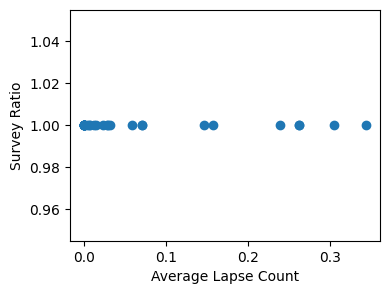

Average Survey Ratio: 1.0
AUC = 0.89
tensor(0.1627, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1725, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1824, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1680, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1662, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2256, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2004, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1844, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1441, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1745, device='cuda:1', grad_fn=<MeanBackward0>)


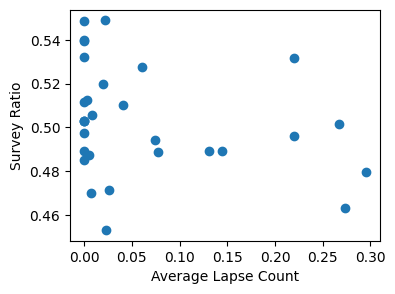

Average Survey Ratio: 0.5031270995948265
AUC = 0.89
tensor(0.1914, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1381, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1729, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1643, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1765, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1790, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1596, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1754, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1637, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1521, device='cuda:1', grad_fn=<MeanBackward0>)


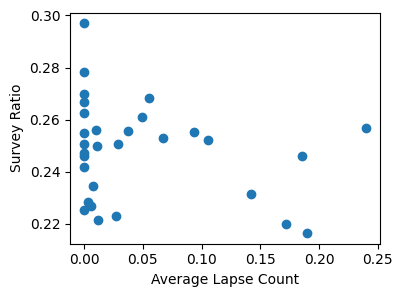

Average Survey Ratio: 0.24823198040083316
AUC = 0.87
tensor(0.1865, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1876, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1991, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1795, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1738, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1652, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1970, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2082, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1676, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1864, device='cuda:1', grad_fn=<MeanBackward0>)


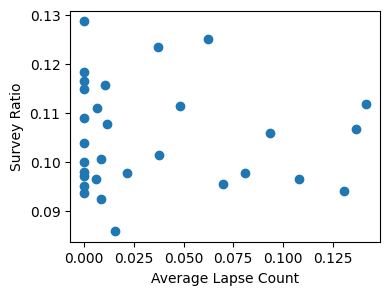

Average Survey Ratio: 0.10513585450480903
AUC = 0.87
tensor(0.1836, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1385, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2036, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1626, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1774, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1833, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1427, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1674, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1664, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1876, device='cuda:1', grad_fn=<MeanBackward0>)


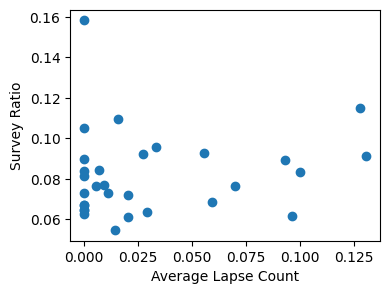

Average Survey Ratio: 0.08182774385797294
AUC = 0.87
-----------------------------------------------
torch.Size([29577, 173]) torch.Size([7639, 173])
404 1466 7639
XgBoost: AUC = 0.89
torch.Size([29577, 173])
tensor(0.1623, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2382, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2513, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1858, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1670, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2159, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2017, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2082, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2111, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1823, device='cuda:1', grad_fn=<MeanBackward0>)


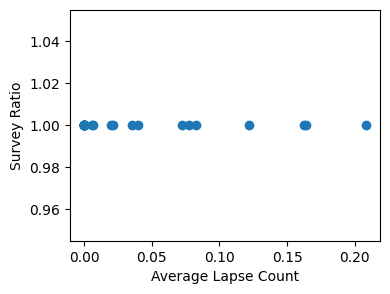

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.2046, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1602, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1687, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2360, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1927, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2254, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1782, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1583, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1744, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2030, device='cuda:1', grad_fn=<MeanBackward0>)


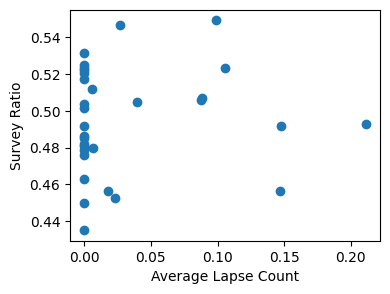

Average Survey Ratio: 0.49525308691533654
AUC = 0.88
tensor(0.1853, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2079, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2015, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1849, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1711, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1947, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1901, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1836, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1472, device='cuda:1', grad_fn=<MeanBackward0>)


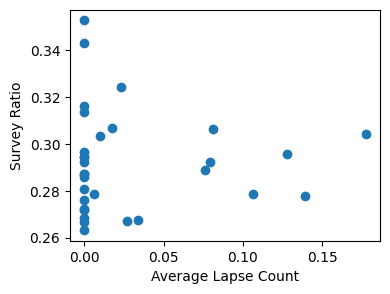

Average Survey Ratio: 0.2921201660974718
AUC = 0.87
tensor(0.1783, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1974, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2122, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1975, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1909, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2312, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1551, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1682, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1925, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1798, device='cuda:1', grad_fn=<MeanBackward0>)


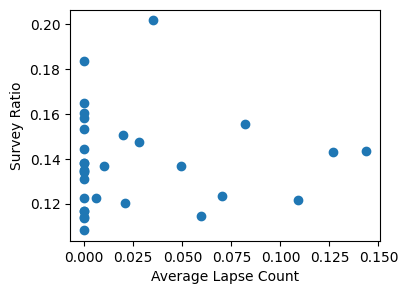

Average Survey Ratio: 0.13823334813997767
AUC = 0.87
tensor(0.2002, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1669, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2472, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2096, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2125, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2216, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1985, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2253, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2153, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2176, device='cuda:1', grad_fn=<MeanBackward0>)


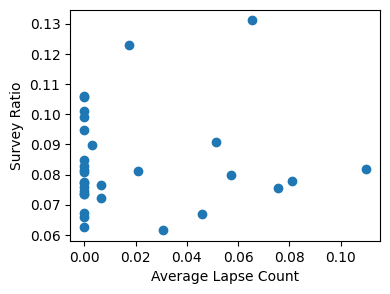

Average Survey Ratio: 0.08361748605861619
AUC = 0.87
-----------------------------------------------
{'xg': [0.8833177740322957, 0.8634638565586662, 0.9022903949062969, 0.8910247555016046, 0.888656797607888], 1: [0.8648132486827946, 0.844102925448254, 0.9017687865161341, 0.8888199569197767, 0.8970271370606308], 2: [0.8612862256262432, 0.8301838313935199, 0.8831775568337286, 0.8902679449883297, 0.8812264363962312], 4: [0.8333404057428958, 0.8251100346020761, 0.8840466676854938, 0.8654584524623612, 0.8742314245246224], 10: [0.8185644050837969, 0.8186970745517459, 0.8672522355079617, 0.8677063031392558, 0.8683939800338016], 20: [0.8277910457835536, 0.8296152249134947, 0.8549360145511209, 0.8671457664241788, 0.8686690455500283]}
torch.Size([30353, 173]) torch.Size([6863, 173])
431 1298 6863
XgBoost: AUC = 0.81
torch.Size([30353, 173])
tensor(0.1593, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.82
---------------------------------------------------
Device set to : cuda:1
tensor(0.2533, device='c

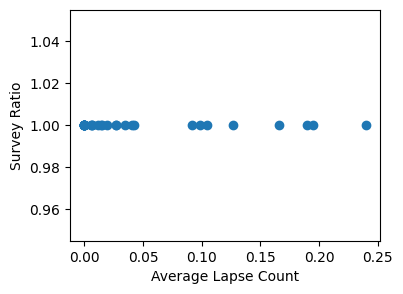

Average Survey Ratio: 1.0
AUC = 0.82
tensor(0.1595, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2155, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1904, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1357, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2158, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1827, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1657, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2373, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1716, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1914, device='cuda:1', grad_fn=<MeanBackward0>)


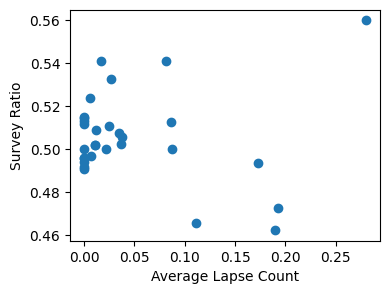

Average Survey Ratio: 0.5053847401927177
AUC = 0.81
tensor(0.2133, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2046, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1770, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1733, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1638, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1348, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1657, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1824, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1823, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1868, device='cuda:1', grad_fn=<MeanBackward0>)


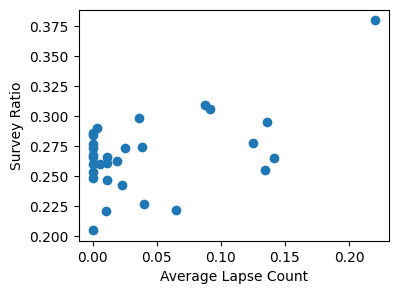

Average Survey Ratio: 0.26864836446164075
AUC = 0.82
tensor(0.1933, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2029, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1957, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2234, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1909, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1780, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1800, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2067, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2006, device='cuda:1', grad_fn=<MeanBackward0>)


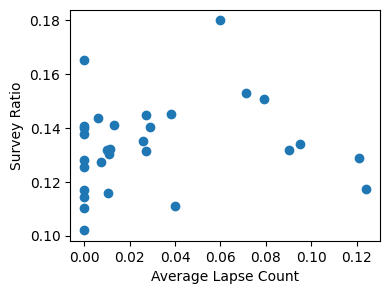

Average Survey Ratio: 0.13355544265303002
AUC = 0.80
tensor(0.2220, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1922, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2015, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2298, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1988, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2343, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1873, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1922, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1876, device='cuda:1', grad_fn=<MeanBackward0>)


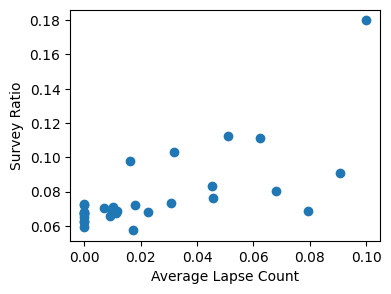

Average Survey Ratio: 0.07838173034663104
AUC = 0.76
-----------------------------------------------
torch.Size([29400, 173]) torch.Size([7816, 173])
778 2135 7816
XgBoost: AUC = 0.89
torch.Size([29400, 173])
tensor(0.1852, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.1935, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2473, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2122, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2179, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1691, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2316, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2138, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1689, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1604, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1570, device='cuda:1', grad_fn=<MeanBackward0>)


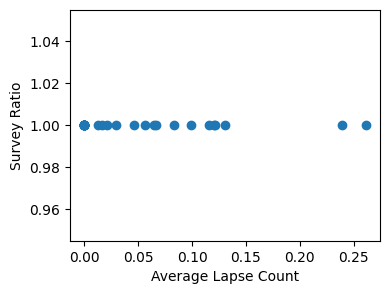

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1663, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1555, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1452, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1466, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2253, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2138, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1879, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1907, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1984, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1683, device='cuda:1', grad_fn=<MeanBackward0>)


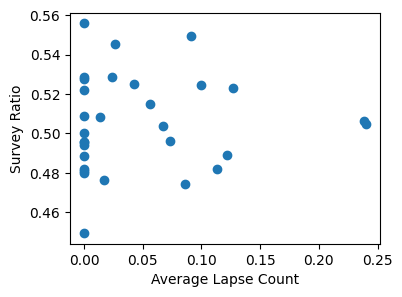

Average Survey Ratio: 0.5053546009976467
AUC = 0.88
tensor(0.1853, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1736, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1991, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2114, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1615, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1661, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2032, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2164, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1957, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1420, device='cuda:1', grad_fn=<MeanBackward0>)


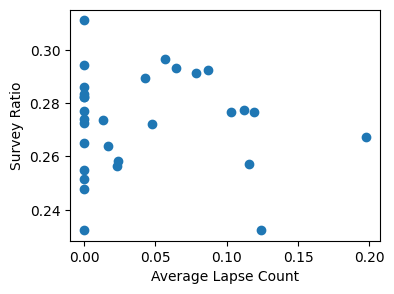

Average Survey Ratio: 0.27300928310239825
AUC = 0.87
tensor(0.1889, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2036, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1349, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1853, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1671, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1523, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1406, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1812, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2148, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2071, device='cuda:1', grad_fn=<MeanBackward0>)


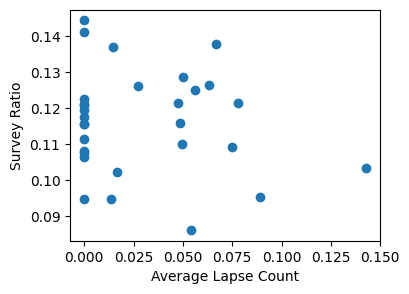

Average Survey Ratio: 0.11622609057585678
AUC = 0.83
tensor(0.1932, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1967, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2134, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1695, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2030, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1675, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2217, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1725, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1596, device='cuda:1', grad_fn=<MeanBackward0>)


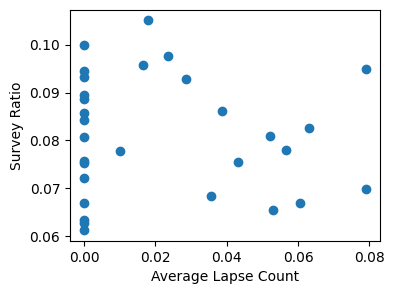

Average Survey Ratio: 0.08105796687916836
AUC = 0.79
-----------------------------------------------
torch.Size([29798, 173]) torch.Size([7418, 173])
722 1766 7418
XgBoost: AUC = 0.88
torch.Size([29798, 173])
tensor(0.1092, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.88
---------------------------------------------------
Device set to : cuda:1
tensor(0.2075, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2432, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1981, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1724, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1741, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1519, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1325, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2025, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1995, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1678, device='cuda:1', grad_fn=<MeanBackward0>)


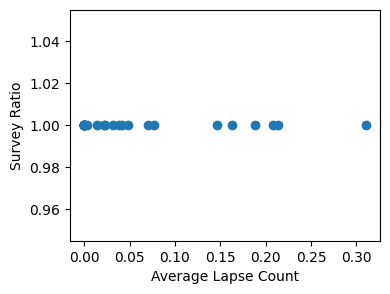

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.1593, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1412, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1475, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1415, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1538, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1943, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1489, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1386, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1324, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1583, device='cuda:1', grad_fn=<MeanBackward0>)


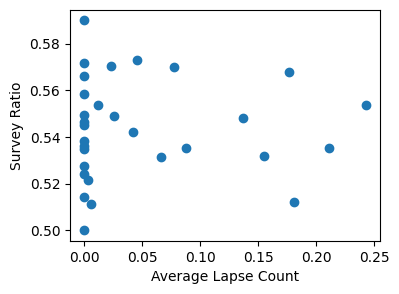

Average Survey Ratio: 0.5436396154916764
AUC = 0.86
tensor(0.1805, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1566, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1708, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1644, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1988, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1681, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1688, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2003, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1582, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1889, device='cuda:1', grad_fn=<MeanBackward0>)


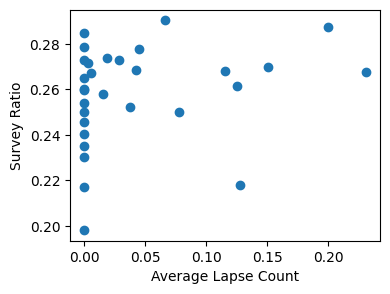

Average Survey Ratio: 0.2582228435173051
AUC = 0.86
tensor(0.2225, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1594, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1617, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2094, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1811, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1705, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1953, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1637, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1653, device='cuda:1', grad_fn=<MeanBackward0>)


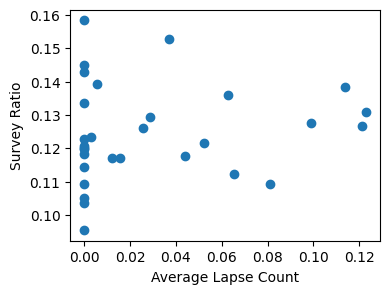

Average Survey Ratio: 0.12446119447426597
AUC = 0.86
tensor(0.1931, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1806, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1750, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2340, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1746, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2102, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1875, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2021, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2028, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1865, device='cuda:1', grad_fn=<MeanBackward0>)


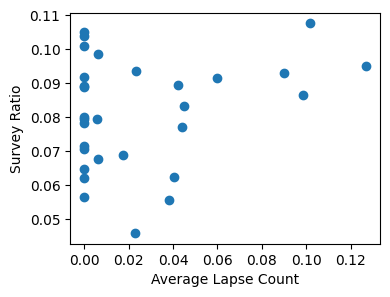

Average Survey Ratio: 0.08132140459077826
AUC = 0.85
-----------------------------------------------
torch.Size([30139, 173]) torch.Size([7077, 173])
746 1866 7077
XgBoost: AUC = 0.90
torch.Size([30139, 173])
tensor(0.1442, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.88
---------------------------------------------------
Device set to : cuda:1
tensor(0.1953, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1642, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2166, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2195, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1893, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1562, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1692, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1453, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1969, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1773, device='cuda:1', grad_fn=<MeanBackward0>)


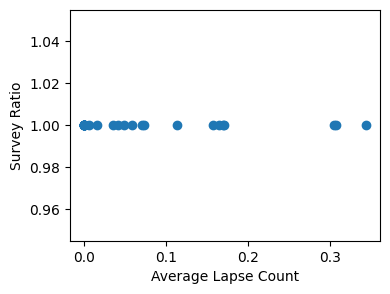

Average Survey Ratio: 1.0
AUC = 0.87
tensor(0.1875, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2070, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1579, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1519, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1774, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1647, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1700, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1738, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1420, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1216, device='cuda:1', grad_fn=<MeanBackward0>)


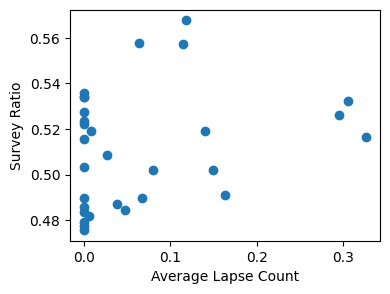

Average Survey Ratio: 0.5110129762589578
AUC = 0.87
tensor(0.1490, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1613, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1855, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2077, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1753, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2154, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1648, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1678, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1806, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1600, device='cuda:1', grad_fn=<MeanBackward0>)


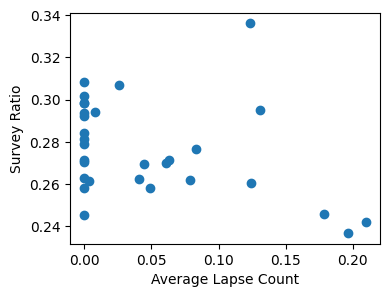

Average Survey Ratio: 0.276445429873802
AUC = 0.87
tensor(0.1806, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1630, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1831, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1757, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2080, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1649, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1779, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1466, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1819, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)


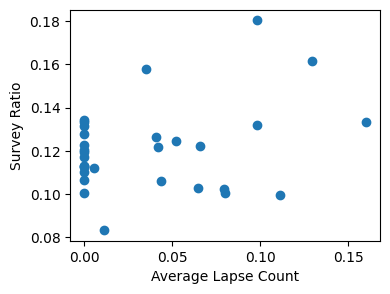

Average Survey Ratio: 0.12096362489527206
AUC = 0.86
tensor(0.2056, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2296, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1948, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1845, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2052, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1959, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2073, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1753, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2257, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1837, device='cuda:1', grad_fn=<MeanBackward0>)


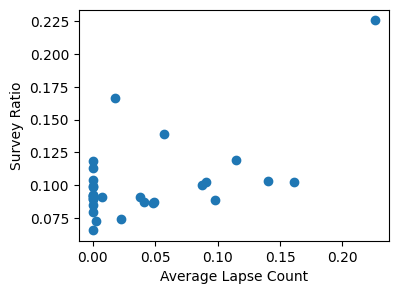

Average Survey Ratio: 0.10164170786261756
AUC = 0.87
-----------------------------------------------
torch.Size([29174, 173]) torch.Size([8042, 173])
625 1954 8042
XgBoost: AUC = 0.92
torch.Size([29174, 173])
tensor(0.1953, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.92
---------------------------------------------------
Device set to : cuda:1
tensor(0.2263, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1762, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1888, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2105, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2040, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1699, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1868, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1800, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1747, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1546, device='cuda:1', grad_fn=<MeanBackward0>)


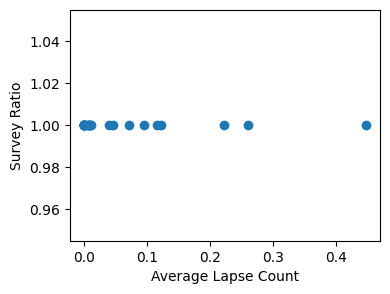

Average Survey Ratio: 1.0
AUC = 0.91
tensor(0.2024, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1989, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1646, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1650, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1605, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1991, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1962, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2360, device='cuda:1', grad_fn=<MeanBackward0>)


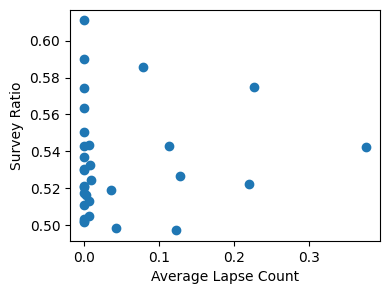

Average Survey Ratio: 0.5338107675848061
AUC = 0.91
tensor(0.2001, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2158, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2014, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1926, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1712, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2191, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1807, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2199, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2070, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2144, device='cuda:1', grad_fn=<MeanBackward0>)


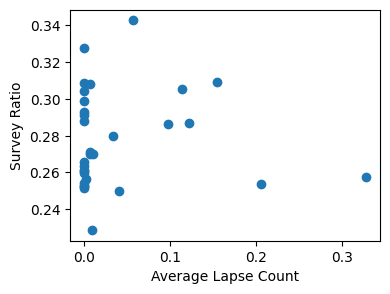

Average Survey Ratio: 0.27773898660147356
AUC = 0.92
tensor(0.1865, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1845, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2316, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1939, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2317, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2082, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1651, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2106, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2065, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1903, device='cuda:1', grad_fn=<MeanBackward0>)


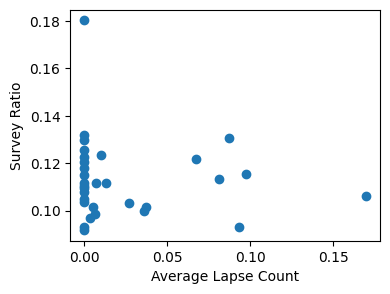

Average Survey Ratio: 0.11306294891898166
AUC = 0.91
tensor(0.2325, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1863, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1906, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2448, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2193, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2275, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1683, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1996, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1849, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1778, device='cuda:1', grad_fn=<MeanBackward0>)


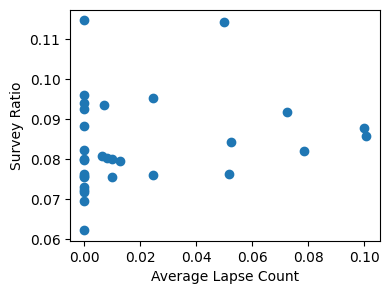

Average Survey Ratio: 0.08344234506021976
AUC = 0.91
-----------------------------------------------
{'xg': [0.8098023152797499, 0.8877419750732527, 0.8801053756821785, 0.8988851402710946, 0.924155966023999], 1: [0.8155037602013137, 0.8967879838497004, 0.8794705649711906, 0.8722270897320855, 0.9110054199811244], 2: [0.8096874242476713, 0.8782853236671145, 0.864812415399941, 0.874054346818053, 0.9092752325738169], 4: [0.8169015710311551, 0.8651596438284713, 0.8608250429412524, 0.8655653296282855, 0.9181605500876365], 10: [0.7961223465041383, 0.826329579930031, 0.8568547352866225, 0.8604202140791535, 0.9123994067682353], 20: [0.7626216005240618, 0.7927897473210066, 0.8476651831663671, 0.8654505702608932, 0.9130598355130106]}
torch.Size([29714, 173]) torch.Size([7502, 173])
664 1404 7502
XgBoost: AUC = 0.87
torch.Size([29714, 173])
tensor(0.0605, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.87
---------------------------------------------------
Device set to : cuda:1
tensor(0.3008, device='cud

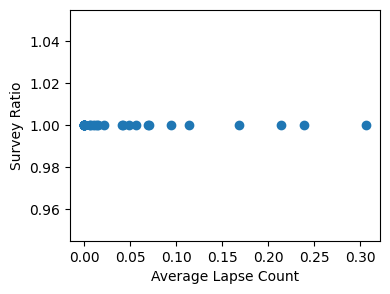

Average Survey Ratio: 1.0
AUC = 0.87
tensor(0.1583, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1860, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1237, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1830, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1751, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1661, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1930, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1614, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1897, device='cuda:1', grad_fn=<MeanBackward0>)


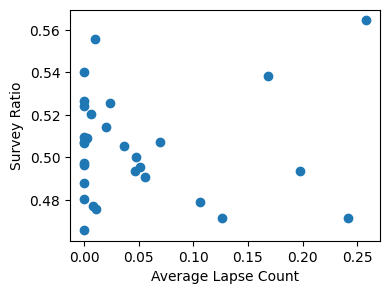

Average Survey Ratio: 0.5044338801755851
AUC = 0.87
tensor(0.1672, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1827, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1967, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1758, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1659, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1850, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1910, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2151, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1755, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1874, device='cuda:1', grad_fn=<MeanBackward0>)


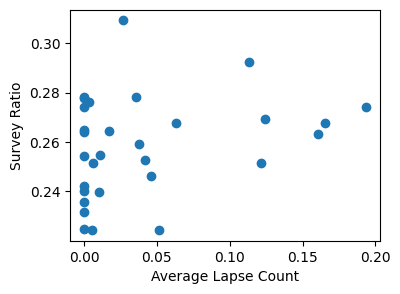

Average Survey Ratio: 0.25848467969752054
AUC = 0.85
tensor(0.2090, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1897, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1734, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2002, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1493, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1844, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1635, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2140, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1930, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1678, device='cuda:1', grad_fn=<MeanBackward0>)


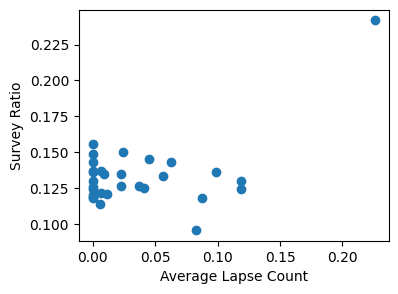

Average Survey Ratio: 0.13379745191104134
AUC = 0.85
tensor(0.2033, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1801, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1830, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2010, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1988, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2142, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1763, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1563, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1994, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2028, device='cuda:1', grad_fn=<MeanBackward0>)


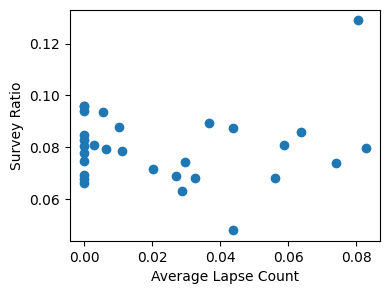

Average Survey Ratio: 0.07998037775881528
AUC = 0.83
-----------------------------------------------
torch.Size([29868, 173]) torch.Size([7348, 173])
881 2135 7348
XgBoost: AUC = 0.92
torch.Size([29868, 173])
tensor(0.1047, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2349, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1866, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2071, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2083, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2077, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2367, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2413, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1895, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2031, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1857, device='cuda:1', grad_fn=<MeanBackward0>)


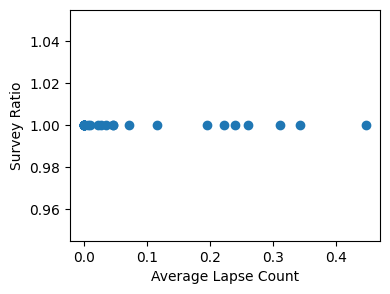

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.2060, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1668, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1853, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1754, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1727, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1782, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1843, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1761, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1719, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1743, device='cuda:1', grad_fn=<MeanBackward0>)


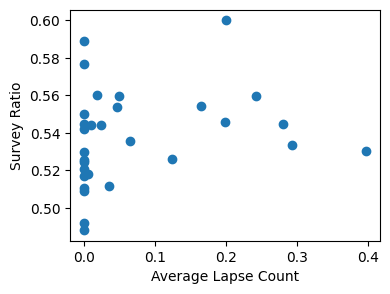

Average Survey Ratio: 0.5380198232643181
AUC = 0.90
tensor(0.1594, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1430, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1519, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2029, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1633, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1389, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1995, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1749, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1949, device='cuda:1', grad_fn=<MeanBackward0>)


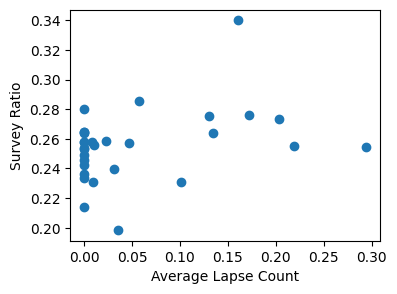

Average Survey Ratio: 0.2557262579798834
AUC = 0.90
tensor(0.1729, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1879, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1730, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2055, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1430, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1435, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1565, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2118, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1545, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1915, device='cuda:1', grad_fn=<MeanBackward0>)


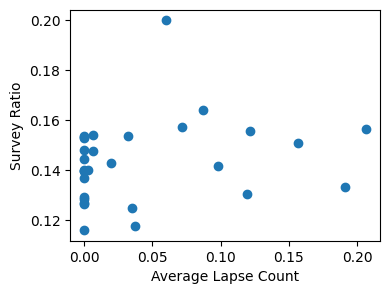

Average Survey Ratio: 0.1435910422371375
AUC = 0.89
tensor(0.2067, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2013, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2111, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1561, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2348, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1518, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1994, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2065, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1864, device='cuda:1', grad_fn=<MeanBackward0>)


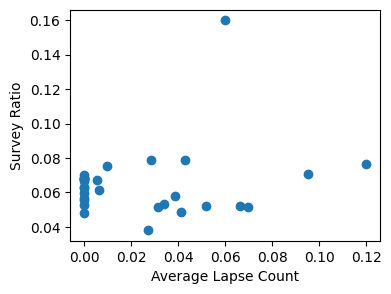

Average Survey Ratio: 0.0650019945600931
AUC = 0.88
-----------------------------------------------
torch.Size([30050, 173]) torch.Size([7166, 173])
576 1925 7166
XgBoost: AUC = 0.86
torch.Size([30050, 173])
tensor(0.2057, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.84
---------------------------------------------------
Device set to : cuda:1
tensor(0.1888, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2487, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2149, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1899, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1906, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2199, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2452, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1505, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1556, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1742, device='cuda:1', grad_fn=<MeanBackward0>)


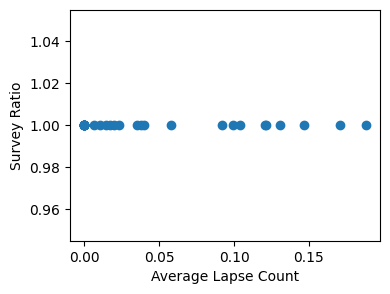

Average Survey Ratio: 1.0
AUC = 0.85
tensor(0.2072, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1533, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2126, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1966, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1827, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1782, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1933, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1990, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1849, device='cuda:1', grad_fn=<MeanBackward0>)


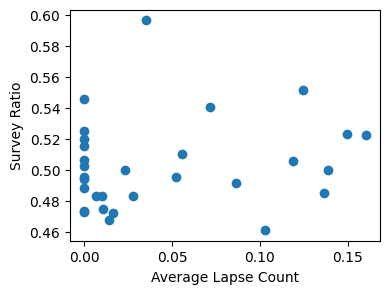

Average Survey Ratio: 0.5028779480939911
AUC = 0.83
tensor(0.1608, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1790, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1887, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1719, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2003, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2178, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1541, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2137, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2164, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1801, device='cuda:1', grad_fn=<MeanBackward0>)


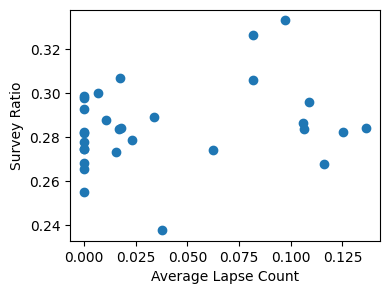

Average Survey Ratio: 0.28506630692243345
AUC = 0.81
tensor(0.1991, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2430, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1657, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1862, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1772, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1472, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1858, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1874, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1777, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1665, device='cuda:1', grad_fn=<MeanBackward0>)


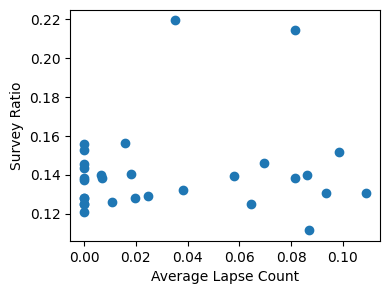

Average Survey Ratio: 0.14123051145373203
AUC = 0.81
tensor(0.2274, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1540, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1492, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1873, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1863, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1583, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2054, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2114, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1409, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1894, device='cuda:1', grad_fn=<MeanBackward0>)


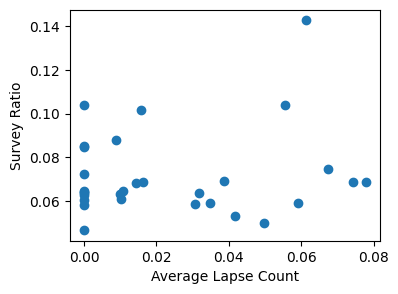

Average Survey Ratio: 0.07171700293255513
AUC = 0.80
-----------------------------------------------
torch.Size([29186, 173]) torch.Size([8030, 173])
366 1221 8030
XgBoost: AUC = 0.88
torch.Size([29186, 173])
tensor(0.1751, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2753, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2098, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1944, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2157, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2046, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2207, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1699, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1850, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1840, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2334, device='cuda:1', grad_fn=<MeanBackward0>)


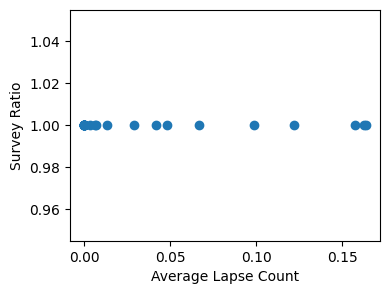

Average Survey Ratio: 1.0
AUC = 0.89
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1995, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2003, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2150, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1564, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1575, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2069, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2029, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1693, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2059, device='cuda:1', grad_fn=<MeanBackward0>)


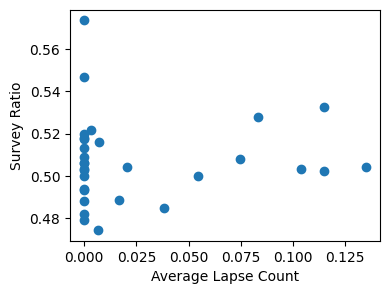

Average Survey Ratio: 0.5073075660345715
AUC = 0.88
tensor(0.2007, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1490, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1891, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1860, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2054, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2288, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2147, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1952, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1775, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2471, device='cuda:1', grad_fn=<MeanBackward0>)


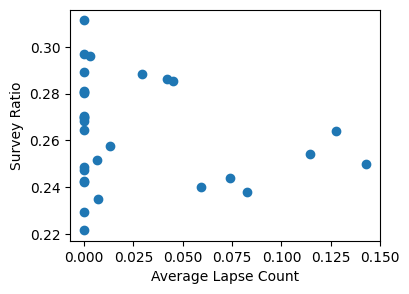

Average Survey Ratio: 0.2634836642710113
AUC = 0.85
tensor(0.2382, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2132, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2676, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1699, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2066, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2375, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2279, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2073, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2057, device='cuda:1', grad_fn=<MeanBackward0>)


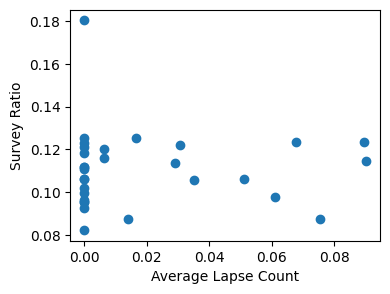

Average Survey Ratio: 0.11077376467991937
AUC = 0.84
tensor(0.1641, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2241, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2080, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2676, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2825, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1550, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2359, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1929, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1912, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2336, device='cuda:1', grad_fn=<MeanBackward0>)


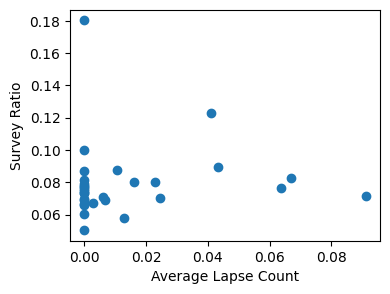

Average Survey Ratio: 0.07957539142595303
AUC = 0.80
-----------------------------------------------
torch.Size([30046, 173]) torch.Size([7170, 173])
815 1721 7170
XgBoost: AUC = 0.91
torch.Size([30046, 173])
tensor(0.1629, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2182, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2287, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2100, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1985, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1572, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1691, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1743, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1808, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1786, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1771, device='cuda:1', grad_fn=<MeanBackward0>)


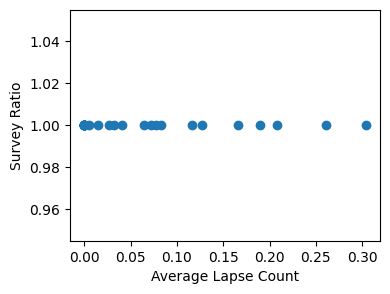

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1922, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1557, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1927, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1807, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1687, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1581, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1852, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2029, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1794, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1333, device='cuda:1', grad_fn=<MeanBackward0>)


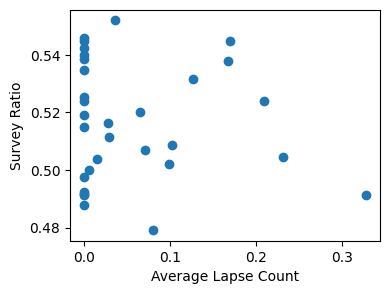

Average Survey Ratio: 0.5169674746445155
AUC = 0.89
tensor(0.1868, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1849, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1436, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1841, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1332, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1687, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1749, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1658, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1925, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1646, device='cuda:1', grad_fn=<MeanBackward0>)


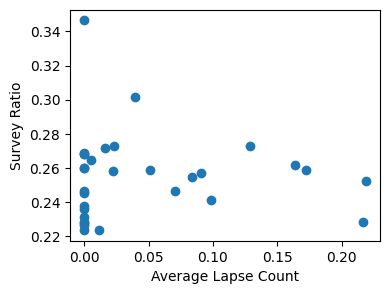

Average Survey Ratio: 0.2547913650254949
AUC = 0.85
tensor(0.1715, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1744, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2300, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1666, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1607, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1295, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1740, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1715, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1705, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1878, device='cuda:1', grad_fn=<MeanBackward0>)


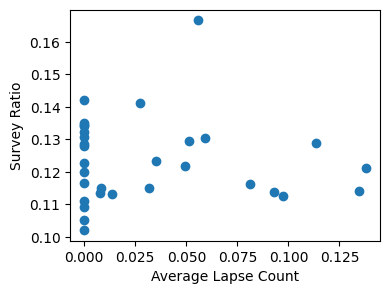

Average Survey Ratio: 0.12348381552551747
AUC = 0.86
tensor(0.1910, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1500, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2253, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1756, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1783, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1939, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1869, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1893, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1574, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2355, device='cuda:1', grad_fn=<MeanBackward0>)


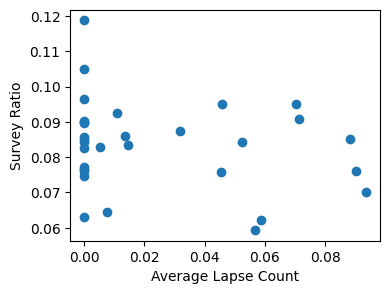

Average Survey Ratio: 0.08341429733114855
AUC = 0.86
-----------------------------------------------
{'xg': [0.8709297925836132, 0.9153303763260152, 0.8616175866211431, 0.879701564050789, 0.9096506784185198], 1: [0.8745374889437832, 0.8964495727632842, 0.8528976458438711, 0.8944422578915545, 0.9021030732769231], 2: [0.8726881054489969, 0.8988801436157058, 0.8296216384252234, 0.8790555802731098, 0.8857961220815453], 4: [0.8535130577883339, 0.8965224126610134, 0.8141838170207385, 0.8542907297762871, 0.8537103773175077], 10: [0.8485672728938569, 0.893335974291553, 0.8076362544258979, 0.836670024926703, 0.8619770916094278], 20: [0.8277275157958538, 0.8805719669598224, 0.7997034911903558, 0.8048332206783257, 0.8567126990486212]}
torch.Size([30274, 173]) torch.Size([6942, 173])
714 1451 6942
XgBoost: AUC = 0.90
torch.Size([30274, 173])
tensor(0.1433, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.1871, device='cu

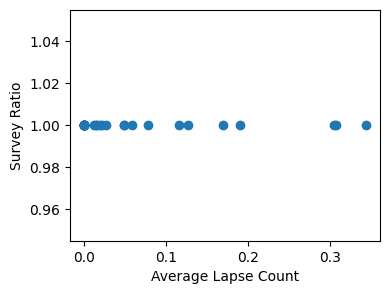

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1709, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1389, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1476, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1767, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1780, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1757, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1959, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1135, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1760, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1458, device='cuda:1', grad_fn=<MeanBackward0>)


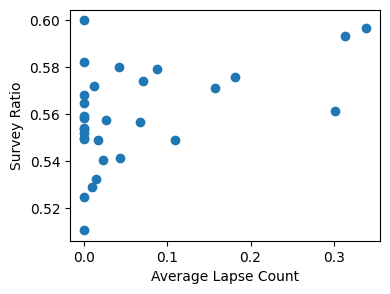

Average Survey Ratio: 0.5595481664583729
AUC = 0.89
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1995, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1939, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1613, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1057, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1766, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2000, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1860, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1923, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1847, device='cuda:1', grad_fn=<MeanBackward0>)


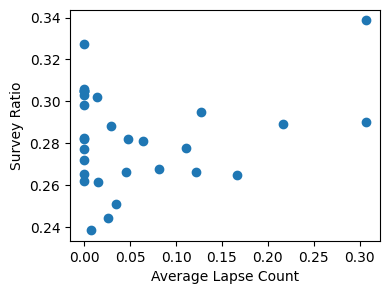

Average Survey Ratio: 0.2832285860507904
AUC = 0.87
tensor(0.2144, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1550, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1928, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1805, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1645, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2013, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1996, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1891, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2098, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2137, device='cuda:1', grad_fn=<MeanBackward0>)


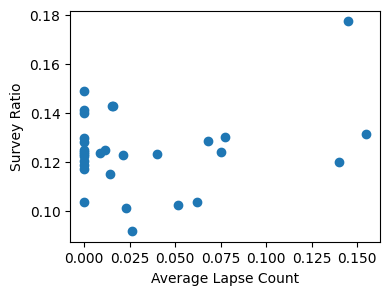

Average Survey Ratio: 0.12498944309928775
AUC = 0.87
tensor(0.2078, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2023, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1656, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2122, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1528, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2130, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1824, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1694, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1771, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2017, device='cuda:1', grad_fn=<MeanBackward0>)


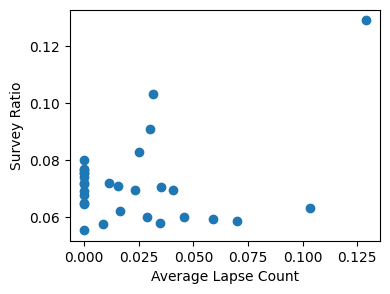

Average Survey Ratio: 0.07200854469772965
AUC = 0.85
-----------------------------------------------
torch.Size([29688, 173]) torch.Size([7528, 173])
886 2461 7528
XgBoost: AUC = 0.88
torch.Size([29688, 173])
tensor(0.1263, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2367, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2001, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1715, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1735, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2351, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1512, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1769, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1457, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1713, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1391, device='cuda:1', grad_fn=<MeanBackward0>)


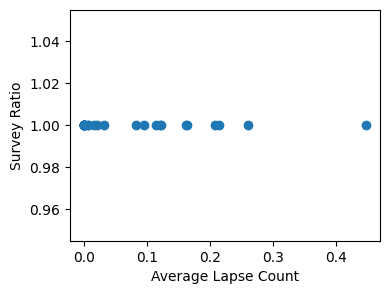

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1537, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1932, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1864, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1571, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1556, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1697, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1164, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1949, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1289, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1903, device='cuda:1', grad_fn=<MeanBackward0>)


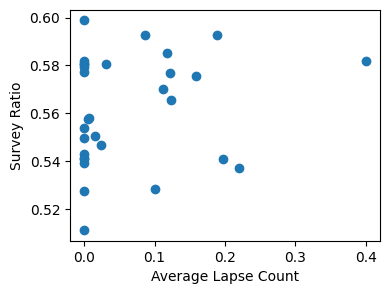

Average Survey Ratio: 0.5615161963605062
AUC = 0.89
tensor(0.1529, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1824, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1542, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1907, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1817, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2179, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1656, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1709, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2155, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1894, device='cuda:1', grad_fn=<MeanBackward0>)


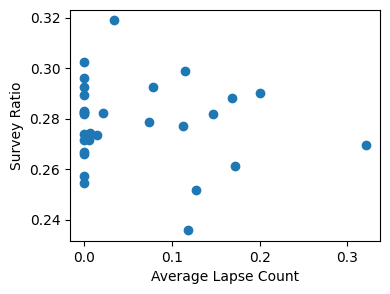

Average Survey Ratio: 0.2782049452586524
AUC = 0.88
tensor(0.1807, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1651, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1809, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1652, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1948, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1578, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1825, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1830, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1693, device='cuda:1', grad_fn=<MeanBackward0>)


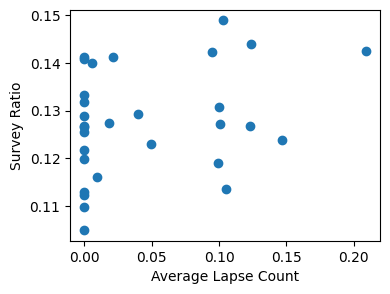

Average Survey Ratio: 0.12775533166013586
AUC = 0.89
tensor(0.2081, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1433, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2104, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1613, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2086, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1807, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1985, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2204, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2009, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1870, device='cuda:1', grad_fn=<MeanBackward0>)


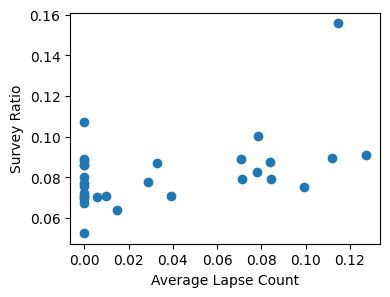

Average Survey Ratio: 0.08197166369041259
AUC = 0.88
-----------------------------------------------
torch.Size([30209, 173]) torch.Size([7007, 173])
752 2182 7007
XgBoost: AUC = 0.85
torch.Size([30209, 173])
tensor(0.2094, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.84
---------------------------------------------------
Device set to : cuda:1
tensor(0.1779, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2360, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1978, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1803, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1684, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1809, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1438, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1563, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1300, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1922, device='cuda:1', grad_fn=<MeanBackward0>)


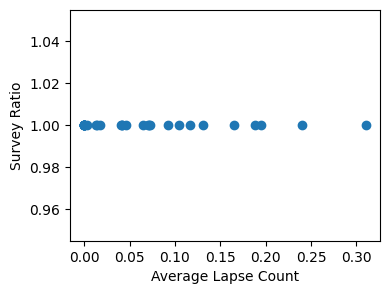

Average Survey Ratio: 1.0
AUC = 0.85
tensor(0.1845, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1552, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1847, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1719, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2046, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1752, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1100, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1883, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1527, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1543, device='cuda:1', grad_fn=<MeanBackward0>)


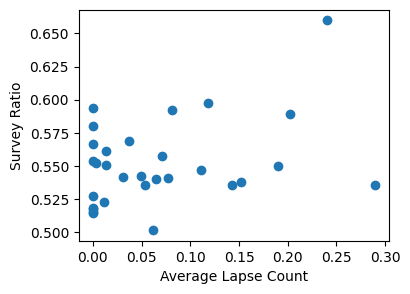

Average Survey Ratio: 0.5514377159186327
AUC = 0.83
tensor(0.1490, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1585, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1759, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1568, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1474, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1939, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1442, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1570, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1569, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1948, device='cuda:1', grad_fn=<MeanBackward0>)


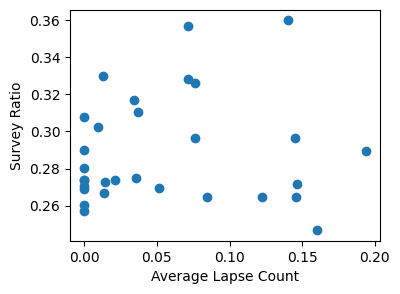

Average Survey Ratio: 0.28893108466415174
AUC = 0.82
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1125, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1913, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1372, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1468, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1663, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1703, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1572, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1862, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1971, device='cuda:1', grad_fn=<MeanBackward0>)


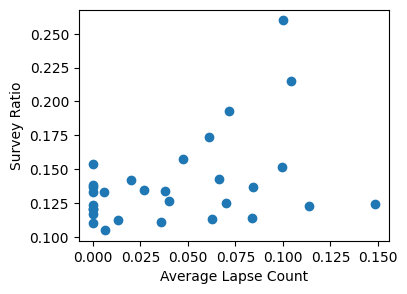

Average Survey Ratio: 0.13939810583271597
AUC = 0.80
tensor(0.1933, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2112, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2282, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1447, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1522, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1458, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1589, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1925, device='cuda:1', grad_fn=<MeanBackward0>)


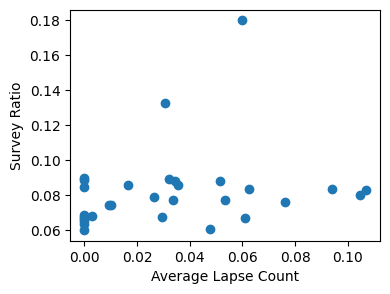

Average Survey Ratio: 0.08178930515976268
AUC = 0.81
-----------------------------------------------
torch.Size([29115, 173]) torch.Size([8101, 173])
506 1709 8101
XgBoost: AUC = 0.89
torch.Size([29115, 173])
tensor(0.1638, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.2653, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2258, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1931, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1822, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2180, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2060, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2115, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2136, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2068, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2023, device='cuda:1', grad_fn=<MeanBackward0>)


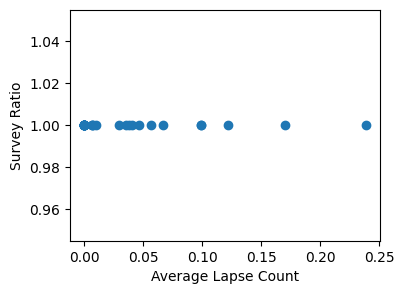

Average Survey Ratio: 1.0
AUC = 0.89
tensor(0.2081, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1982, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1958, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1834, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1675, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1835, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1693, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1474, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2374, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1681, device='cuda:1', grad_fn=<MeanBackward0>)


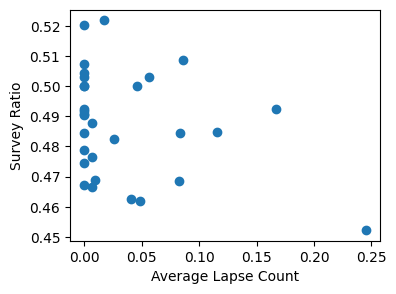

Average Survey Ratio: 0.4876047162701162
AUC = 0.87
tensor(0.2124, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1985, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2365, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1478, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1619, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2103, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1910, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2117, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1660, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1850, device='cuda:1', grad_fn=<MeanBackward0>)


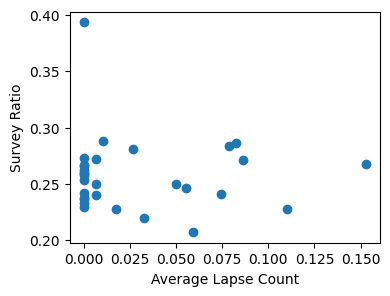

Average Survey Ratio: 0.25757638483633394
AUC = 0.86
tensor(0.1707, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1613, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1815, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2232, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1754, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1783, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1934, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1858, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2216, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1729, device='cuda:1', grad_fn=<MeanBackward0>)


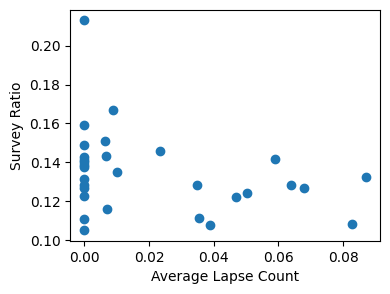

Average Survey Ratio: 0.13447773428415627
AUC = 0.84
tensor(0.2015, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2280, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2126, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2054, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1660, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2050, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2245, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2097, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1706, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1944, device='cuda:1', grad_fn=<MeanBackward0>)


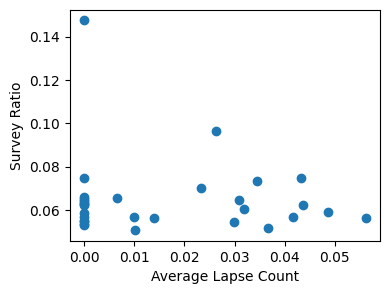

Average Survey Ratio: 0.06489740523268168
AUC = 0.81
-----------------------------------------------
torch.Size([29578, 173]) torch.Size([7638, 173])
444 1066 7638
XgBoost: AUC = 0.90
torch.Size([29578, 173])
tensor(0.1807, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.2668, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2174, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1887, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2432, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1794, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2204, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1885, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2057, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1906, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1543, device='cuda:1', grad_fn=<MeanBackward0>)


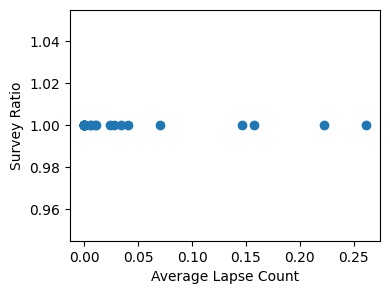

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.2104, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1502, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1981, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1944, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1962, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1706, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2110, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1981, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1672, device='cuda:1', grad_fn=<MeanBackward0>)


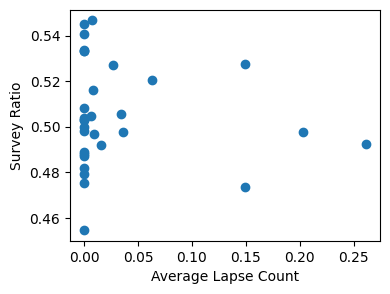

Average Survey Ratio: 0.5050172307762816
AUC = 0.87
tensor(0.2013, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2419, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1979, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2280, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1779, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1710, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1556, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1823, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1960, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1663, device='cuda:1', grad_fn=<MeanBackward0>)


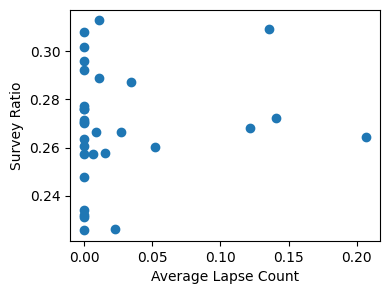

Average Survey Ratio: 0.2686485089110008
AUC = 0.86
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2212, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1890, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1656, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1731, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2089, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2106, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1808, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2293, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2456, device='cuda:1', grad_fn=<MeanBackward0>)


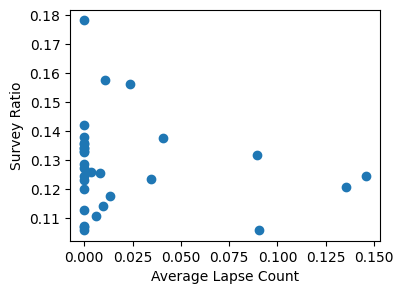

Average Survey Ratio: 0.12820230723088177
AUC = 0.86
tensor(0.2100, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1741, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1716, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2070, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1822, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1769, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2098, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2054, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1766, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2060, device='cuda:1', grad_fn=<MeanBackward0>)


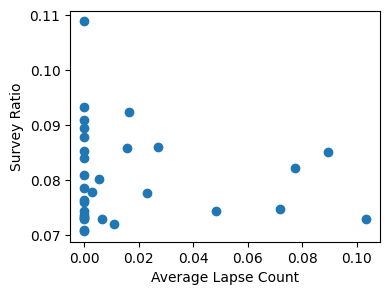

Average Survey Ratio: 0.0804828092007083
AUC = 0.88
-----------------------------------------------
{'xg': [0.8996461943801285, 0.8839364791942377, 0.8502367255132064, 0.8913848823987072, 0.8974957547205255], 1: [0.8971125701404519, 0.8953518820992074, 0.8455600413286392, 0.8924315716341362, 0.8826399376858092], 2: [0.8892497108027541, 0.8946340171954515, 0.8324543556644047, 0.8732848998326859, 0.8675350705167219], 4: [0.8713854841872524, 0.8821964915786604, 0.8207010986955117, 0.8566835889015814, 0.8627201534311626], 10: [0.8737571939501556, 0.8900048973527107, 0.8033357356667858, 0.8432864871053611, 0.8644392411594246], 20: [0.8546283478066885, 0.8767035378530359, 0.8104026353385378, 0.8146764175515928, 0.8778422396541663]}
key:  xg mean:  0.8844598444920864 median:  0.8880102583841765
key:  1 mean:  0.8786511577911651 median:  0.884800340474382
key:  2 mean:  0.8676809613059073 median:  0.8729865026408414
key:  4 mean:  0.8572855367903044 median:  0.8563633244084814
key:  10 mean:  

In [41]:
AUC_dict = {}
for j in range(6):
    dic = k_fold_test()
    if( j == 0 ):
        AUC_dict = dic
    else:
        for key in AUC_dict.keys():
            AUC_dict[key].extend(dic[key])
            
for key in AUC_dict.keys():
    print('key: ', key, 'mean: ', np.mean(AUC_dict[key]), 'median: ', np.median(AUC_dict[key]))

torch.Size([29156, 173]) torch.Size([8060, 173])
330 1351 8060
XgBoost: AUC = 0.89
torch.Size([29156, 173])
tensor(0.1846, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.3313, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2630, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2087, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1987, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1960, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1965, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2015, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1762, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1485, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1665, device='cuda:1', grad_fn=<MeanBackward0>)


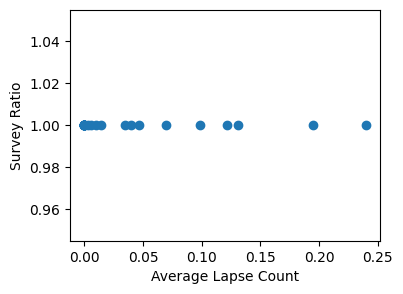

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.2074, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1883, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2304, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1722, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1831, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1867, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1981, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2377, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1769, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2024, device='cuda:1', grad_fn=<MeanBackward0>)


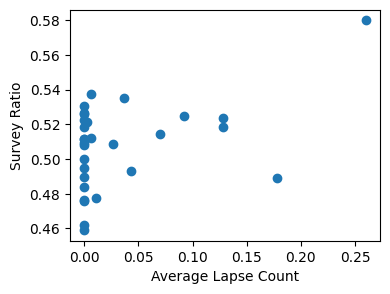

Average Survey Ratio: 0.508110205494001
AUC = 0.89
tensor(0.2149, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2016, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2146, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2142, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2271, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1692, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1698, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2061, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2063, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1980, device='cuda:1', grad_fn=<MeanBackward0>)


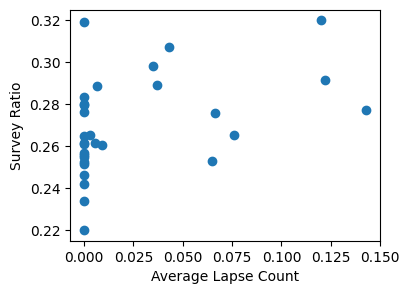

Average Survey Ratio: 0.2697475276067357
AUC = 0.86
tensor(0.2561, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2126, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2025, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2149, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2250, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2444, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1608, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2294, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2088, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2199, device='cuda:1', grad_fn=<MeanBackward0>)


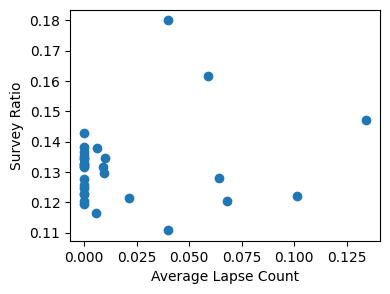

Average Survey Ratio: 0.13184357291671017
AUC = 0.87
tensor(0.2112, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2196, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1947, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1826, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2228, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2315, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2309, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2384, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2092, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2075, device='cuda:1', grad_fn=<MeanBackward0>)


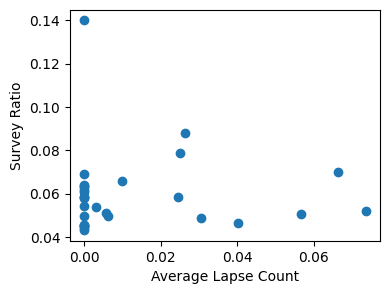

Average Survey Ratio: 0.059336214847374086
AUC = 0.85
-----------------------------------------------
torch.Size([29689, 173]) torch.Size([7527, 173])
874 2204 7527
XgBoost: AUC = 0.88
torch.Size([29689, 173])
tensor(0.1429, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.85
---------------------------------------------------
Device set to : cuda:1
tensor(0.1633, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1584, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1963, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2111, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1599, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1382, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1253, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1866, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1477, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1834, device='cuda:1', grad_fn=<MeanBackward0>)


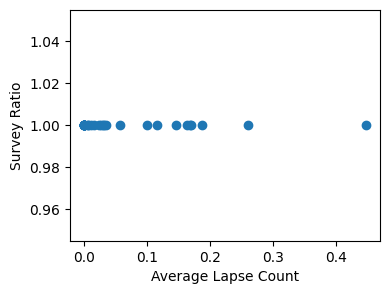

Average Survey Ratio: 1.0
AUC = 0.85
tensor(0.1508, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1832, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1292, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1643, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1547, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1617, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1265, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1644, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1916, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1692, device='cuda:1', grad_fn=<MeanBackward0>)


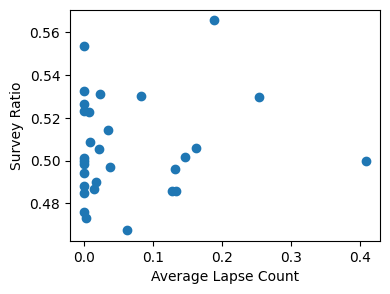

Average Survey Ratio: 0.5058859750112299
AUC = 0.85
tensor(0.2299, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1496, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1957, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1642, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1894, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1456, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1959, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1701, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1599, device='cuda:1', grad_fn=<MeanBackward0>)


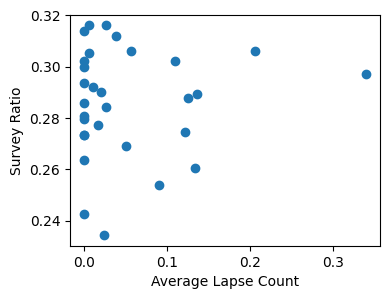

Average Survey Ratio: 0.2860933016918879
AUC = 0.83
tensor(0.1604, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1941, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2152, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1884, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1725, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1655, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1661, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1612, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1720, device='cuda:1', grad_fn=<MeanBackward0>)


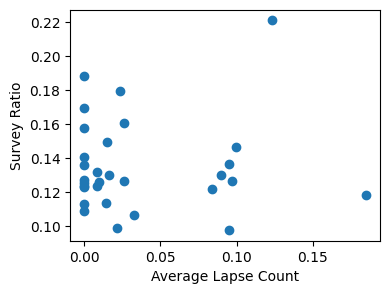

Average Survey Ratio: 0.1353381897653499
AUC = 0.84
tensor(0.1822, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1831, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1541, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1856, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2149, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1385, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2025, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1598, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1768, device='cuda:1', grad_fn=<MeanBackward0>)


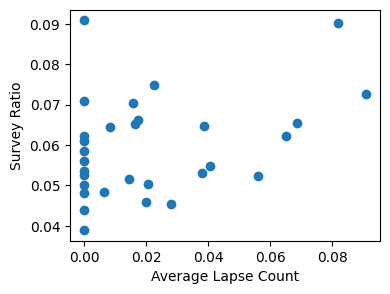

Average Survey Ratio: 0.05949349841852765
AUC = 0.84
-----------------------------------------------
torch.Size([30423, 173]) torch.Size([6793, 173])
760 1635 6793
XgBoost: AUC = 0.92
torch.Size([30423, 173])
tensor(0.1664, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2425, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2357, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2066, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2242, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2174, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1735, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2065, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1550, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1449, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1836, device='cuda:1', grad_fn=<MeanBackward0>)


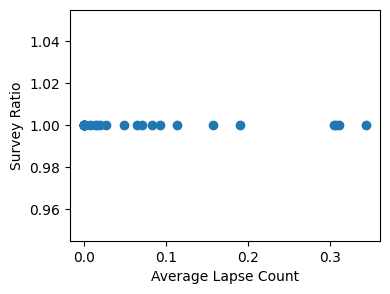

Average Survey Ratio: 1.0
AUC = 0.89
tensor(0.1583, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2034, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1542, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1851, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1446, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2064, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1645, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2132, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1703, device='cuda:1', grad_fn=<MeanBackward0>)


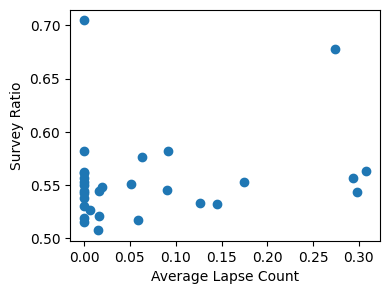

Average Survey Ratio: 0.5546604577636934
AUC = 0.88
tensor(0.1841, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2020, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1971, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1660, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1874, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1426, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1692, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1810, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1595, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1717, device='cuda:1', grad_fn=<MeanBackward0>)


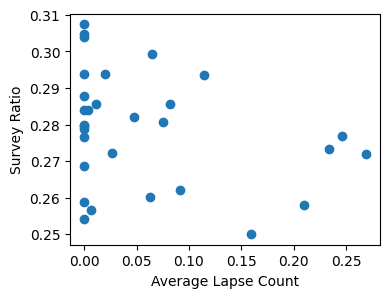

Average Survey Ratio: 0.27882135590343593
AUC = 0.88
tensor(0.1672, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1783, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1515, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1782, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1935, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1496, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1823, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1710, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1938, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1476, device='cuda:1', grad_fn=<MeanBackward0>)


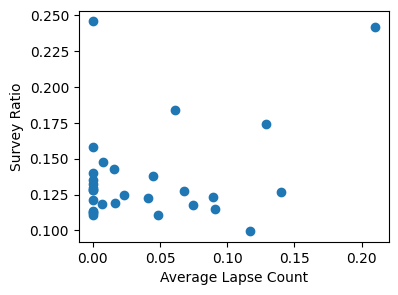

Average Survey Ratio: 0.13666514677305394
AUC = 0.87
tensor(0.2019, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2238, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1862, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1849, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2141, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1855, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1752, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2019, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1975, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1986, device='cuda:1', grad_fn=<MeanBackward0>)


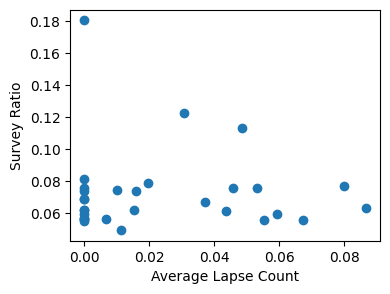

Average Survey Ratio: 0.07248767124609905
AUC = 0.84
-----------------------------------------------
torch.Size([30013, 173]) torch.Size([7203, 173])
954 1974 7203
XgBoost: AUC = 0.87
torch.Size([30013, 173])
tensor(0.1265, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.87
---------------------------------------------------
Device set to : cuda:1
tensor(0.1897, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2034, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1903, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1828, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1542, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1660, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1440, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1306, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1460, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1288, device='cuda:1', grad_fn=<MeanBackward0>)


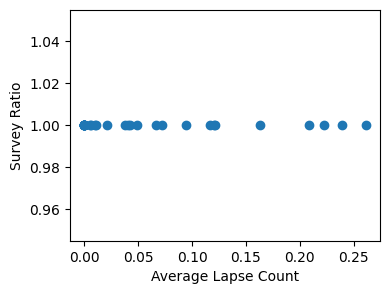

Average Survey Ratio: 1.0
AUC = 0.87
tensor(0.2056, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1605, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1579, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1745, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1310, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1248, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1560, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1655, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1386, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1338, device='cuda:1', grad_fn=<MeanBackward0>)


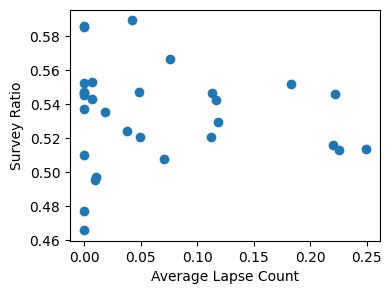

Average Survey Ratio: 0.5337208008665159
AUC = 0.86
tensor(0.1614, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1666, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1636, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1417, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1713, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1634, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1577, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1561, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1306, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1478, device='cuda:1', grad_fn=<MeanBackward0>)


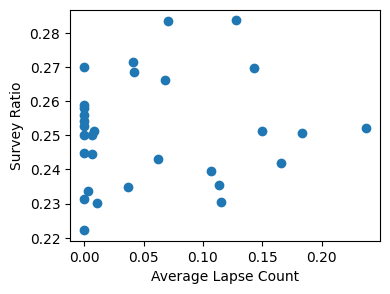

Average Survey Ratio: 0.2510425889076993
AUC = 0.85
tensor(0.1562, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1664, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1976, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1633, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1626, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1768, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1900, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1901, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1974, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1611, device='cuda:1', grad_fn=<MeanBackward0>)


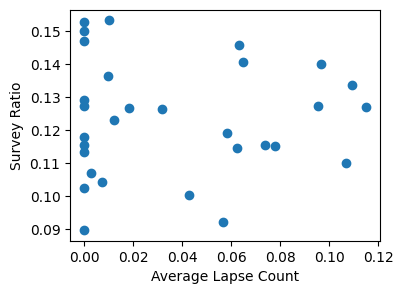

Average Survey Ratio: 0.12344169033907355
AUC = 0.84
tensor(0.1779, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1429, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1513, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1659, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2085, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1654, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2234, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1593, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1531, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1704, device='cuda:1', grad_fn=<MeanBackward0>)


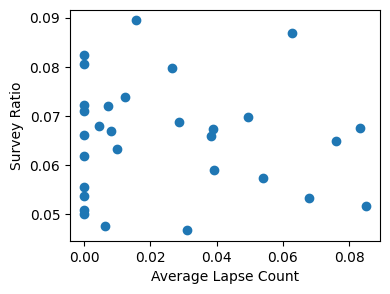

Average Survey Ratio: 0.06546853888585828
AUC = 0.82
-----------------------------------------------
torch.Size([29583, 173]) torch.Size([7633, 173])
384 1504 7633
XgBoost: AUC = 0.89
torch.Size([29583, 173])
tensor(0.1472, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.2416, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2430, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2321, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2054, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2348, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2230, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1921, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1928, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2194, device='cuda:1', grad_fn=<MeanBackward0>)


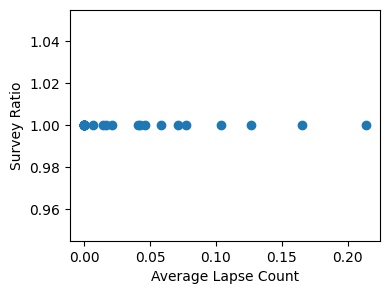

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1523, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1701, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1919, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1655, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1686, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1582, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2048, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1812, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1538, device='cuda:1', grad_fn=<MeanBackward0>)


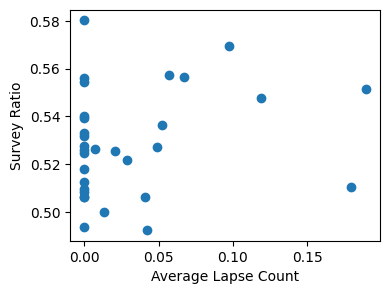

Average Survey Ratio: 0.5289349065334232
AUC = 0.89
tensor(0.1733, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2118, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2031, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1859, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2001, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2106, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1959, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2072, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2129, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1873, device='cuda:1', grad_fn=<MeanBackward0>)


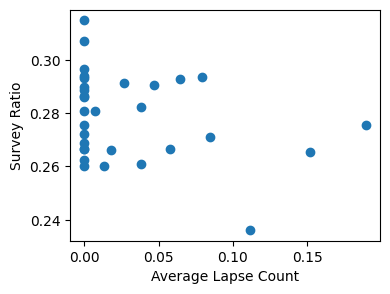

Average Survey Ratio: 0.27883004615846735
AUC = 0.88
tensor(0.2074, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1599, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2533, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1626, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1989, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1904, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1994, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2074, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2006, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1868, device='cuda:1', grad_fn=<MeanBackward0>)


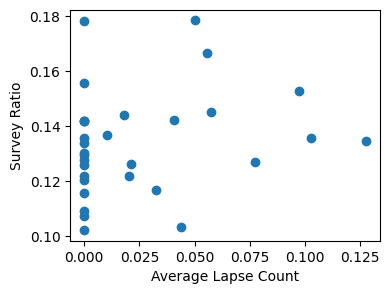

Average Survey Ratio: 0.13383660150395227
AUC = 0.88
tensor(0.2597, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2495, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1545, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2504, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2072, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2669, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2066, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2015, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2128, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2047, device='cuda:1', grad_fn=<MeanBackward0>)


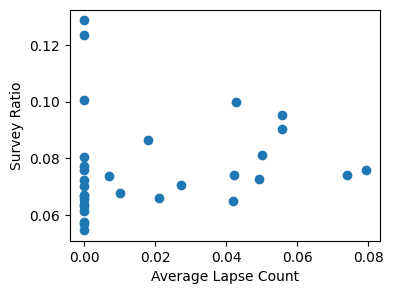

Average Survey Ratio: 0.07668768494231516
AUC = 0.88
-----------------------------------------------
{'xg': [0.891823474067976, 0.8819743231060746, 0.9179390544985038, 0.8726596255400864, 0.8919840236584355], 1: [0.8967827041436355, 0.8526209851476991, 0.8933137480698263, 0.8728769349427145, 0.9019257684968042], 2: [0.889612685718766, 0.8519483820550664, 0.8757530948205922, 0.8616016717811118, 0.8860636668276085], 4: [0.8584397663569721, 0.8313276197899058, 0.8755986809390457, 0.8495477515396174, 0.8769018427829126], 10: [0.8677315849308087, 0.8411924078227644, 0.8695692332522006, 0.8360645040732724, 0.8818872646227065], 20: [0.8507003410560978, 0.8361278492763713, 0.8392311584530695, 0.8160547616339788, 0.8767520376373753]}
torch.Size([30156, 173]) torch.Size([7060, 173])
454 1249 7060
XgBoost: AUC = 0.91
torch.Size([30156, 173])
tensor(0.1423, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.87
---------------------------------------------------
Device set to : cuda:1
tensor(0.2816, device='c

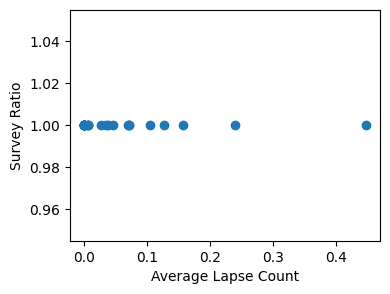

Average Survey Ratio: 1.0
AUC = 0.87
tensor(0.2244, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1640, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2144, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2161, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1570, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1740, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1611, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1908, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1628, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2347, device='cuda:1', grad_fn=<MeanBackward0>)


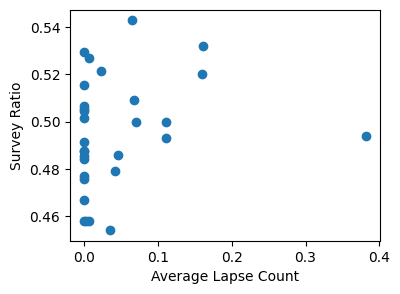

Average Survey Ratio: 0.4950134337018308
AUC = 0.86
tensor(0.2154, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1596, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2687, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1864, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2150, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2196, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1749, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1953, device='cuda:1', grad_fn=<MeanBackward0>)


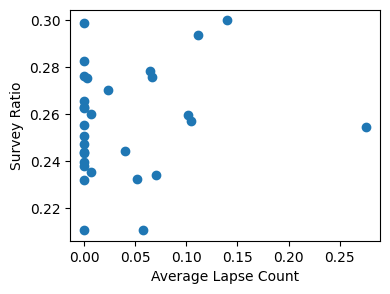

Average Survey Ratio: 0.2564136750319776
AUC = 0.87
tensor(0.1915, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1672, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1765, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2614, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1816, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2157, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2065, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1886, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2029, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2154, device='cuda:1', grad_fn=<MeanBackward0>)


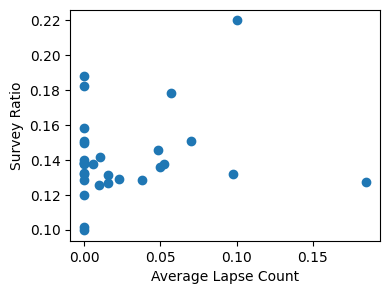

Average Survey Ratio: 0.1415398993728301
AUC = 0.87
tensor(0.1502, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2478, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1544, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1748, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2053, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2292, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2128, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1639, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2014, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1859, device='cuda:1', grad_fn=<MeanBackward0>)


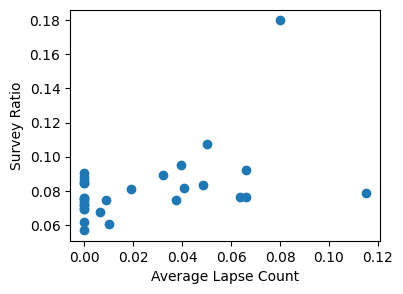

Average Survey Ratio: 0.0818246447262208
AUC = 0.88
-----------------------------------------------
torch.Size([29718, 173]) torch.Size([7498, 173])
842 2700 7498
XgBoost: AUC = 0.86
torch.Size([29718, 173])
tensor(0.1623, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.1918, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1694, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1945, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1857, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1697, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1793, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1624, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1808, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1628, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1456, device='cuda:1', grad_fn=<MeanBackward0>)


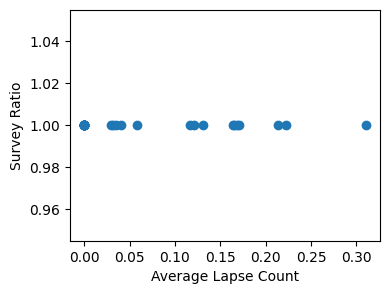

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.1680, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1654, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2413, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1759, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1852, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1455, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1442, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1596, device='cuda:1', grad_fn=<MeanBackward0>)


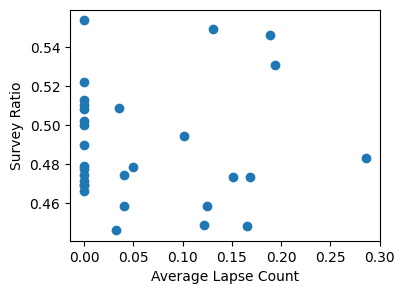

Average Survey Ratio: 0.4892006255323357
AUC = 0.87
tensor(0.1415, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1986, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1465, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2031, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1742, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1552, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1846, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1518, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1784, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1888, device='cuda:1', grad_fn=<MeanBackward0>)


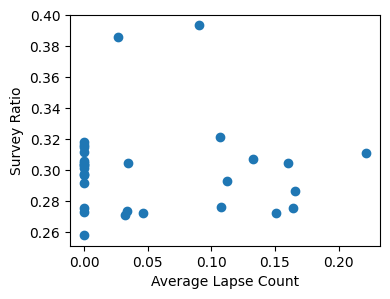

Average Survey Ratio: 0.30064936877284365
AUC = 0.86
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1674, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1815, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1612, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2172, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2068, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1959, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1714, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1519, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1480, device='cuda:1', grad_fn=<MeanBackward0>)


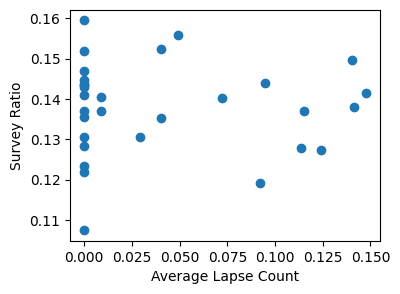

Average Survey Ratio: 0.13780251449968392
AUC = 0.86
tensor(0.1704, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2106, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1684, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2069, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1699, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1559, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1642, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1930, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2151, device='cuda:1', grad_fn=<MeanBackward0>)


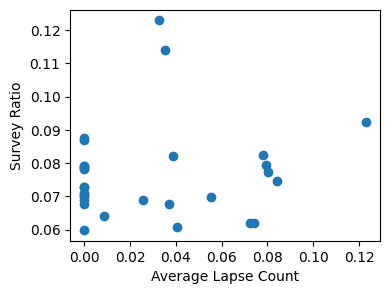

Average Survey Ratio: 0.07677271534187802
AUC = 0.85
-----------------------------------------------
torch.Size([29544, 173]) torch.Size([7672, 173])
791 1891 7672
XgBoost: AUC = 0.90
torch.Size([29544, 173])
tensor(0.2130, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.1944, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1596, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2574, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1855, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1689, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1628, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1400, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2097, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1587, device='cuda:1', grad_fn=<MeanBackward0>)


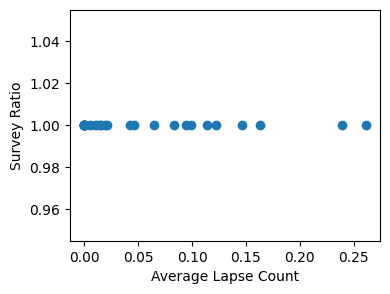

Average Survey Ratio: 1.0
AUC = 0.89
tensor(0.1291, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1465, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1576, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2070, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1839, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1566, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1761, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1690, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1810, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1827, device='cuda:1', grad_fn=<MeanBackward0>)


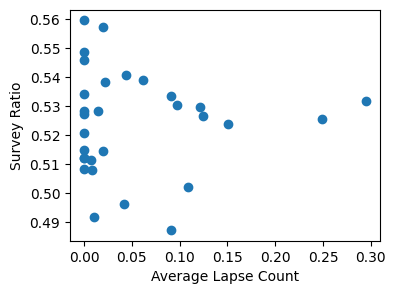

Average Survey Ratio: 0.5242942698795966
AUC = 0.88
tensor(0.2121, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1957, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1617, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1609, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1478, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1854, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1752, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1827, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1790, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2141, device='cuda:1', grad_fn=<MeanBackward0>)


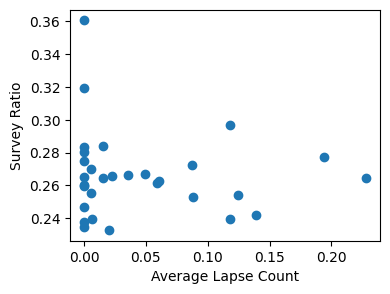

Average Survey Ratio: 0.26648678927789043
AUC = 0.87
tensor(0.2026, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1485, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1915, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1521, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1451, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1699, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1923, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2025, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1846, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1389, device='cuda:1', grad_fn=<MeanBackward0>)


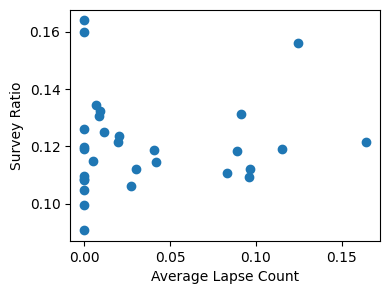

Average Survey Ratio: 0.12070536644581042
AUC = 0.85
tensor(0.1588, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2112, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2050, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2161, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1676, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1620, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2074, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1991, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1970, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2241, device='cuda:1', grad_fn=<MeanBackward0>)


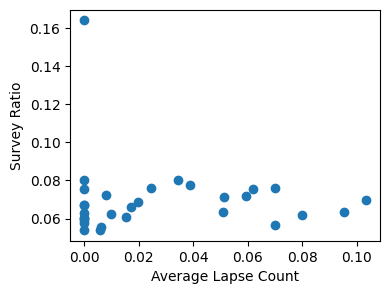

Average Survey Ratio: 0.06973176515106655
AUC = 0.86
-----------------------------------------------
torch.Size([30208, 173]) torch.Size([7008, 173])
517 969 7008
XgBoost: AUC = 0.92
torch.Size([30208, 173])
tensor(0.1777, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.91
---------------------------------------------------
Device set to : cuda:1
tensor(0.2710, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2027, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2010, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1732, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2035, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2068, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2105, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1967, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1855, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1684, device='cuda:1', grad_fn=<MeanBackward0>)


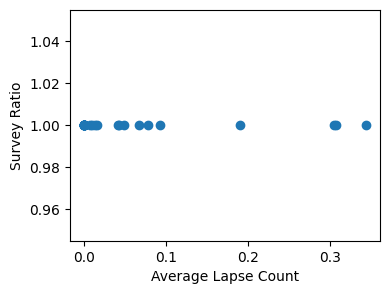

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1923, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2196, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2048, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1520, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2108, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1973, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1951, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1608, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1590, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1557, device='cuda:1', grad_fn=<MeanBackward0>)


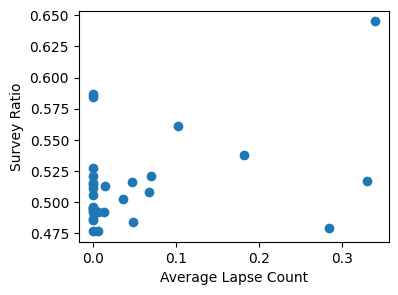

Average Survey Ratio: 0.5144102629520773
AUC = 0.89
tensor(0.1662, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1911, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1734, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2234, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1814, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1712, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1659, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1786, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2009, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2132, device='cuda:1', grad_fn=<MeanBackward0>)


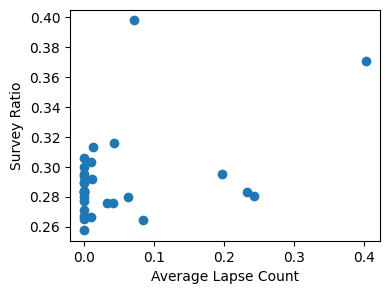

Average Survey Ratio: 0.29129824578706365
AUC = 0.90
tensor(0.1710, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1810, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2041, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2121, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2190, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2312, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2282, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2215, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2059, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2064, device='cuda:1', grad_fn=<MeanBackward0>)


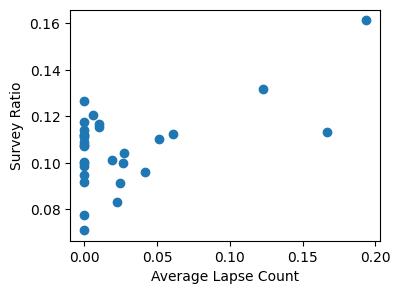

Average Survey Ratio: 0.10698627745415681
AUC = 0.89
tensor(0.2575, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2067, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1829, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2088, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2088, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2192, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1964, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1907, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2215, device='cuda:1', grad_fn=<MeanBackward0>)


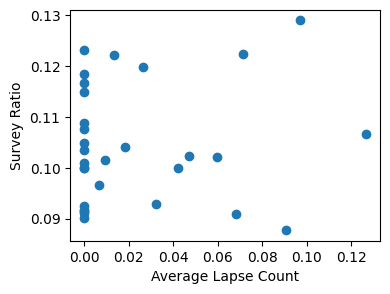

Average Survey Ratio: 0.10448192466797007
AUC = 0.89
-----------------------------------------------
torch.Size([29238, 173]) torch.Size([7978, 173])
698 2103 7978
XgBoost: AUC = 0.87
torch.Size([29238, 173])
tensor(0.1648, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.86
---------------------------------------------------
Device set to : cuda:1
tensor(0.2352, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2004, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2217, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1873, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1365, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1947, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1573, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1726, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1942, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1852, device='cuda:1', grad_fn=<MeanBackward0>)


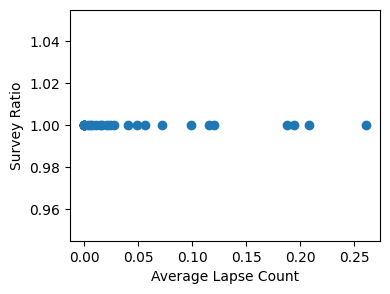

Average Survey Ratio: 1.0
AUC = 0.86
tensor(0.1916, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1534, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1503, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1551, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1944, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1840, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1573, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1962, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1865, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1819, device='cuda:1', grad_fn=<MeanBackward0>)


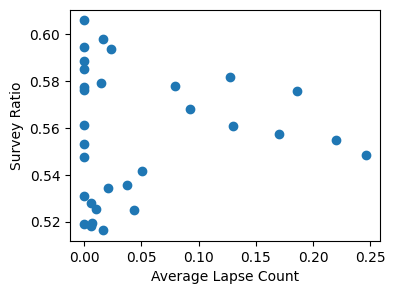

Average Survey Ratio: 0.5573637614442821
AUC = 0.84
tensor(0.1213, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1719, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1395, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1804, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1747, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1897, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1786, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1670, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1663, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1977, device='cuda:1', grad_fn=<MeanBackward0>)


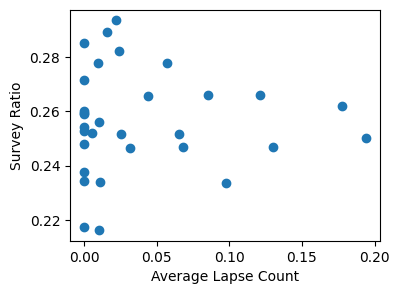

Average Survey Ratio: 0.25626493806896894
AUC = 0.83
tensor(0.1924, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1430, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2184, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1511, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1895, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2015, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1654, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1522, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1912, device='cuda:1', grad_fn=<MeanBackward0>)


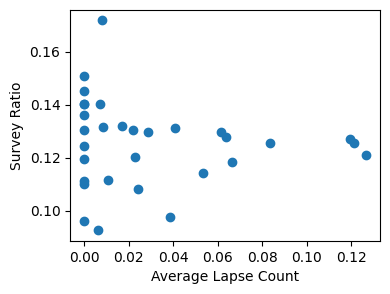

Average Survey Ratio: 0.12547997385104462
AUC = 0.82
tensor(0.1765, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1751, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2144, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2556, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1765, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1914, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2214, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2116, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1705, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1555, device='cuda:1', grad_fn=<MeanBackward0>)


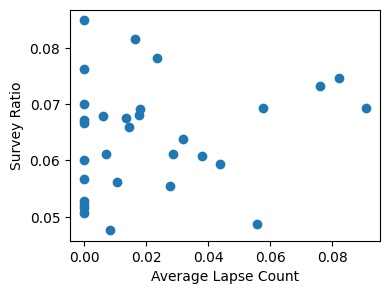

Average Survey Ratio: 0.06412847616352703
AUC = 0.83
-----------------------------------------------
{'xg': [0.9076592031539875, 0.8595803761077105, 0.9014700146301464, 0.9207089894145948, 0.8665216946377404], 1: [0.8724417529918737, 0.8760006509227114, 0.8947992704585503, 0.9033725315844257, 0.8575791507919015], 2: [0.8630576795090833, 0.8703493285218346, 0.8804075091987299, 0.8911115435238853, 0.8425294798324885], 4: [0.8675729979820774, 0.8613388309656496, 0.8711498031094251, 0.8971587500860437, 0.8300915685317548], 10: [0.8703366382983833, 0.8627117818438242, 0.8529783270630518, 0.8912802043716536, 0.8203747362952235], 20: [0.8778244914181608, 0.8536060904097387, 0.8594036125419839, 0.8895551555240748, 0.83262077285179]}
torch.Size([29589, 173]) torch.Size([7627, 173])
516 1003 7627
XgBoost: AUC = 0.93
torch.Size([29589, 173])
tensor(0.1838, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.93
---------------------------------------------------
Device set to : cuda:1
tensor(0.2379, device='c

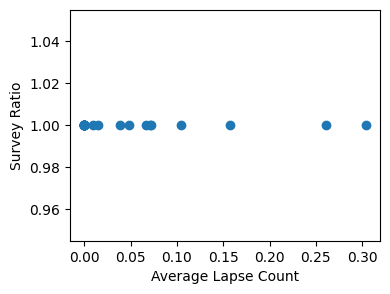

Average Survey Ratio: 1.0
AUC = 0.94
tensor(0.1972, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1840, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2386, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1586, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1644, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2109, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1767, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1455, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2081, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2040, device='cuda:1', grad_fn=<MeanBackward0>)


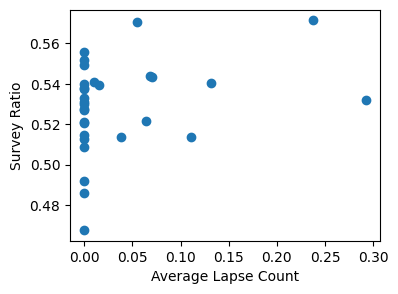

Average Survey Ratio: 0.5291370578366357
AUC = 0.92
tensor(0.1809, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1943, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2321, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2129, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1943, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1692, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1785, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2413, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1935, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1841, device='cuda:1', grad_fn=<MeanBackward0>)


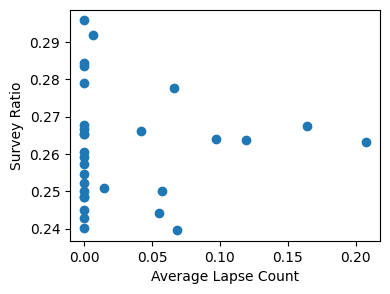

Average Survey Ratio: 0.2615134636223464
AUC = 0.90
tensor(0.1839, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1414, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1984, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2209, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2179, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1586, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1993, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1793, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1822, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1883, device='cuda:1', grad_fn=<MeanBackward0>)


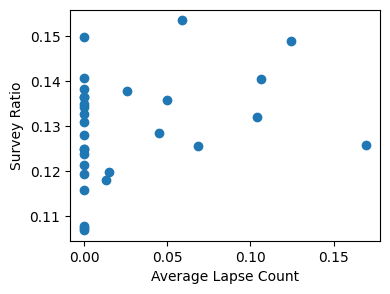

Average Survey Ratio: 0.12934617525639264
AUC = 0.90
tensor(0.2029, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2108, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1963, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1965, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2100, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2083, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1434, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2052, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1639, device='cuda:1', grad_fn=<MeanBackward0>)


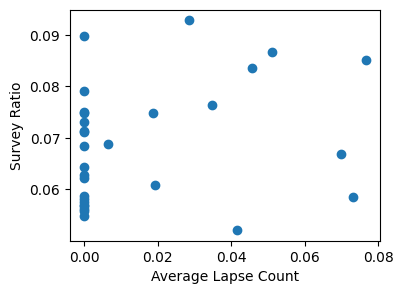

Average Survey Ratio: 0.06845768146593015
AUC = 0.91
-----------------------------------------------
torch.Size([29899, 173]) torch.Size([7317, 173])
940 2384 7317
XgBoost: AUC = 0.87
torch.Size([29899, 173])
tensor(0.1710, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.88
---------------------------------------------------
Device set to : cuda:1
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1962, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1628, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1733, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1669, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2111, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1551, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1410, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1404, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1435, device='cuda:1', grad_fn=<MeanBackward0>)


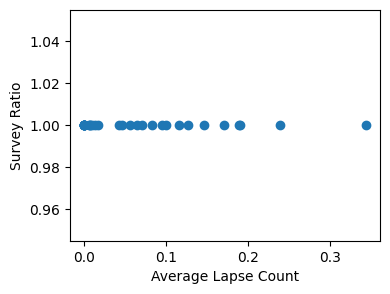

Average Survey Ratio: 1.0
AUC = 0.87
tensor(0.1593, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1739, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1625, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1364, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1414, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1237, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1443, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1555, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1474, device='cuda:1', grad_fn=<MeanBackward0>)


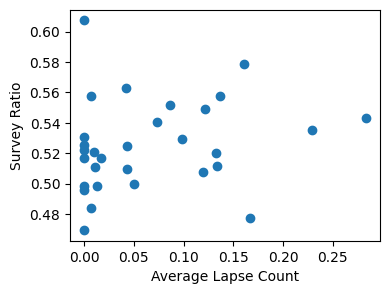

Average Survey Ratio: 0.5251106047386266
AUC = 0.85
tensor(0.1470, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1314, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1919, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1768, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1497, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1954, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1948, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1581, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1389, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1720, device='cuda:1', grad_fn=<MeanBackward0>)


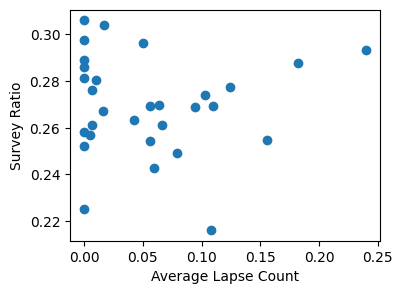

Average Survey Ratio: 0.26962847440256493
AUC = 0.83
tensor(0.1467, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1578, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1711, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1696, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1616, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1286, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1705, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1414, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1758, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1846, device='cuda:1', grad_fn=<MeanBackward0>)


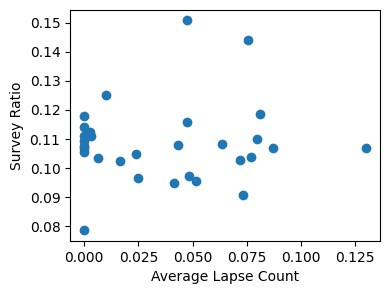

Average Survey Ratio: 0.10860212289422753
AUC = 0.82
tensor(0.1813, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1449, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1356, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1739, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1659, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1819, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1546, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1654, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1737, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2053, device='cuda:1', grad_fn=<MeanBackward0>)


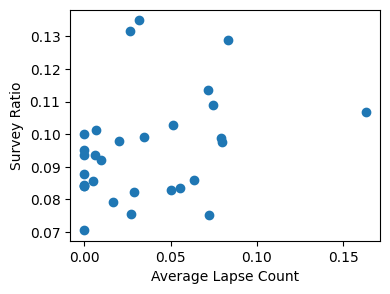

Average Survey Ratio: 0.09526680370647887
AUC = 0.81
-----------------------------------------------
torch.Size([30234, 173]) torch.Size([6982, 173])
394 1178 6982
XgBoost: AUC = 0.88
torch.Size([30234, 173])
tensor(0.1628, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.87
---------------------------------------------------
Device set to : cuda:1
tensor(0.2208, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2270, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1989, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1902, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1959, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2020, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1801, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1685, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1591, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2130, device='cuda:1', grad_fn=<MeanBackward0>)


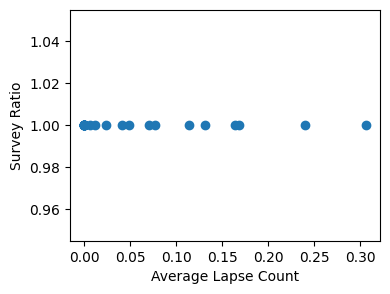

Average Survey Ratio: 1.0
AUC = 0.87
tensor(0.1790, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2666, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1710, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1961, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1696, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1314, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1769, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1644, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1777, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1934, device='cuda:1', grad_fn=<MeanBackward0>)


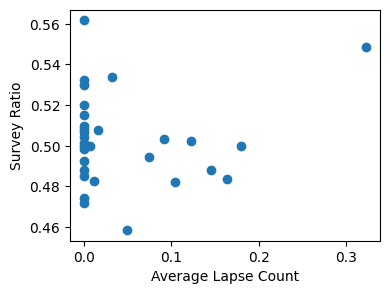

Average Survey Ratio: 0.5028287888580575
AUC = 0.88
tensor(0.1734, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1824, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2286, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1797, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1959, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2177, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1656, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1733, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2474, device='cuda:1', grad_fn=<MeanBackward0>)


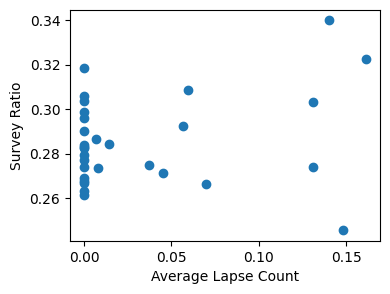

Average Survey Ratio: 0.28549980525215074
AUC = 0.88
tensor(0.1890, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2363, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1855, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1950, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1952, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1996, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2201, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2567, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2227, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1929, device='cuda:1', grad_fn=<MeanBackward0>)


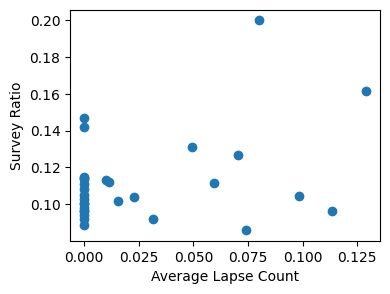

Average Survey Ratio: 0.11213555519444249
AUC = 0.87
tensor(0.2043, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2526, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1968, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1981, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2123, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2081, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2543, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2164, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1422, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2061, device='cuda:1', grad_fn=<MeanBackward0>)


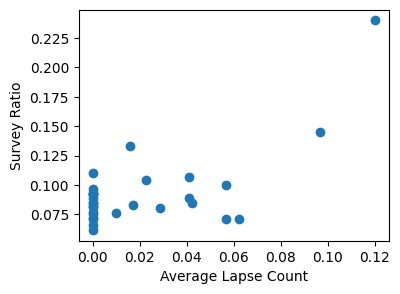

Average Survey Ratio: 0.09360369813255222
AUC = 0.86
-----------------------------------------------
torch.Size([29593, 173]) torch.Size([7623, 173])
798 2038 7623
XgBoost: AUC = 0.89
torch.Size([29593, 173])
tensor(0.1567, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2221, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1945, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2011, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1880, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1779, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1893, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1555, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2111, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1887, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1872, device='cuda:1', grad_fn=<MeanBackward0>)


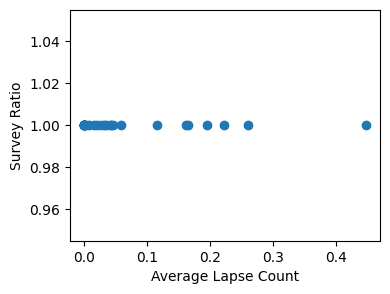

Average Survey Ratio: 1.0
AUC = 0.89
tensor(0.1904, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1762, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1718, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2045, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1687, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2145, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1540, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1662, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1524, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1632, device='cuda:1', grad_fn=<MeanBackward0>)


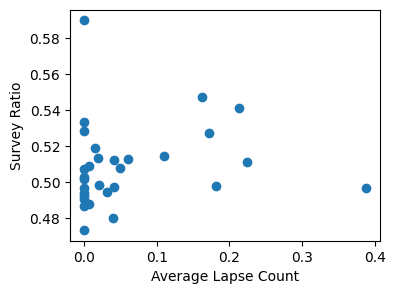

Average Survey Ratio: 0.5088945234642788
AUC = 0.88
tensor(0.1861, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1911, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1988, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1634, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1889, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1862, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1937, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1634, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1521, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2020, device='cuda:1', grad_fn=<MeanBackward0>)


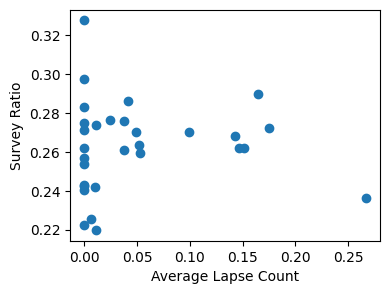

Average Survey Ratio: 0.2630200778194136
AUC = 0.88
tensor(0.2352, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1726, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1569, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2144, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2206, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2164, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1721, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1863, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1892, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1544, device='cuda:1', grad_fn=<MeanBackward0>)


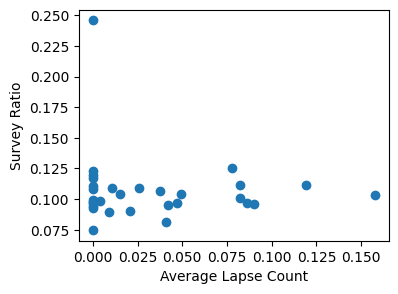

Average Survey Ratio: 0.10695593645322891
AUC = 0.87
tensor(0.1656, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1706, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2206, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1958, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2014, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1931, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1912, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1763, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2114, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1645, device='cuda:1', grad_fn=<MeanBackward0>)


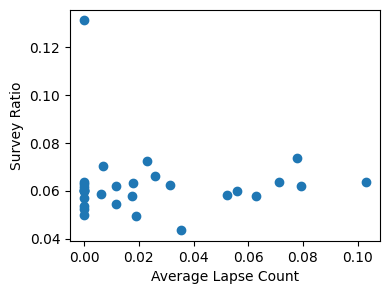

Average Survey Ratio: 0.062342426697084515
AUC = 0.87
-----------------------------------------------
torch.Size([29549, 173]) torch.Size([7667, 173])
654 2258 7667
XgBoost: AUC = 0.84
torch.Size([29549, 173])
tensor(0.1667, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.86
---------------------------------------------------
Device set to : cuda:1
tensor(0.2528, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2354, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2515, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2216, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2100, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2076, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2038, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1964, device='cuda:1', grad_fn=<MeanBackward0>)


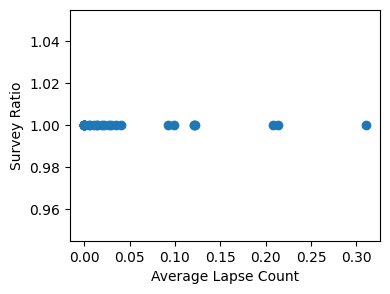

Average Survey Ratio: 1.0
AUC = 0.86
tensor(0.1798, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1916, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1774, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2307, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1922, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1976, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1587, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2068, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1602, device='cuda:1', grad_fn=<MeanBackward0>)


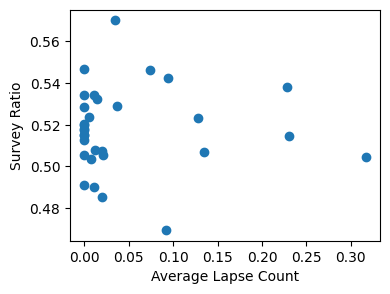

Average Survey Ratio: 0.5180583474451637
AUC = 0.86
tensor(0.1964, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1688, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1774, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1697, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1886, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1369, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1596, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1800, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1907, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1723, device='cuda:1', grad_fn=<MeanBackward0>)


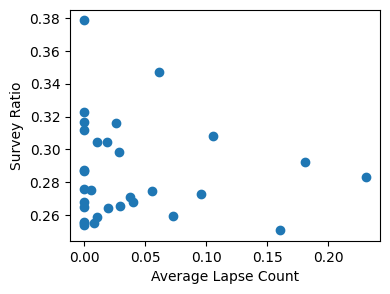

Average Survey Ratio: 0.2853747620310114
AUC = 0.85
tensor(0.2148, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1912, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2146, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2199, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1817, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2181, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1873, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1819, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1979, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1650, device='cuda:1', grad_fn=<MeanBackward0>)


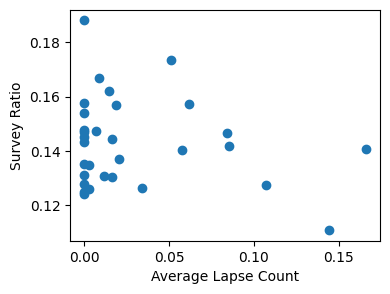

Average Survey Ratio: 0.14277839562083627
AUC = 0.84
tensor(0.1826, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2055, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2249, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1756, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1950, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2027, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2211, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2223, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1999, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2279, device='cuda:1', grad_fn=<MeanBackward0>)


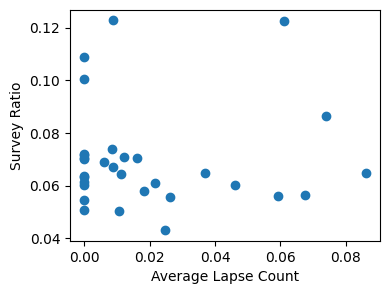

Average Survey Ratio: 0.06984430917272542
AUC = 0.83
-----------------------------------------------
{'xg': [0.9288562648326264, 0.8692254244809304, 0.8772138775623423, 0.8908145822431537, 0.8434459420272792], 1: [0.9359072470972474, 0.8719317093677745, 0.8748894313303066, 0.8921365685275457, 0.8574593448340369], 2: [0.9201429655332551, 0.8548445377169949, 0.880951060072305, 0.8779588164550569, 0.8555552793828499], 4: [0.8982387806204821, 0.8343948832072707, 0.8807397467784837, 0.8826657302597153, 0.8498254225115349], 10: [0.8997954909905932, 0.8183176575392284, 0.8712219802810217, 0.8737193716892964, 0.8387445377762834], 20: [0.908764835351715, 0.8061972213973756, 0.862520380078839, 0.8677080062794349, 0.827541010556629]}
torch.Size([30304, 173]) torch.Size([6912, 173])
876 2312 6912
XgBoost: AUC = 0.88
torch.Size([30304, 173])
tensor(0.1296, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.87
---------------------------------------------------
Device set to : cuda:1
tensor(0.2133, device='cud

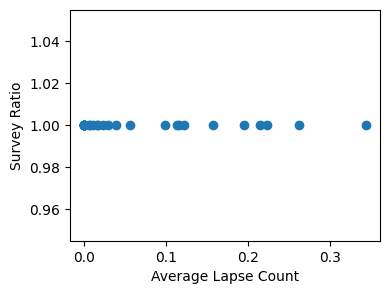

Average Survey Ratio: 1.0
AUC = 0.87
tensor(0.1892, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1841, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1225, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1338, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1444, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1418, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1743, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1777, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1524, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2039, device='cuda:1', grad_fn=<MeanBackward0>)


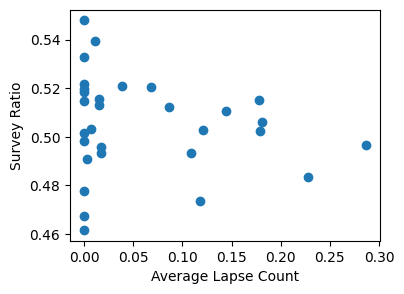

Average Survey Ratio: 0.5050691580674973
AUC = 0.85
tensor(0.1813, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1556, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1953, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1604, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1418, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1964, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1467, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1884, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1628, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1519, device='cuda:1', grad_fn=<MeanBackward0>)


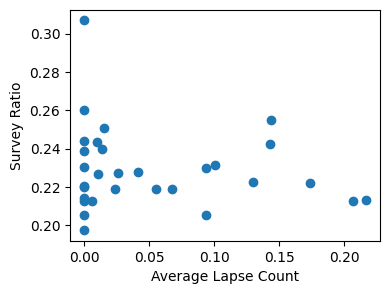

Average Survey Ratio: 0.22903539295820707
AUC = 0.84
tensor(0.1638, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2017, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2039, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2141, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1660, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1801, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1909, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1776, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1684, device='cuda:1', grad_fn=<MeanBackward0>)


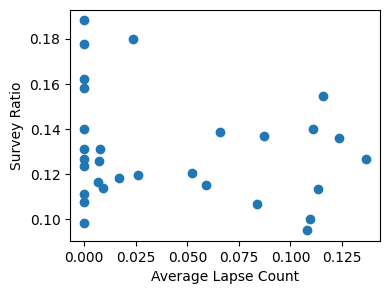

Average Survey Ratio: 0.1305007914280309
AUC = 0.82
tensor(0.1695, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1423, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1738, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1642, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1863, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1809, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1921, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1633, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1975, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1529, device='cuda:1', grad_fn=<MeanBackward0>)


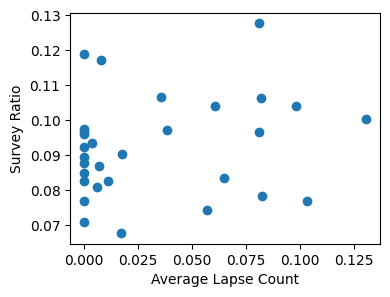

Average Survey Ratio: 0.09223049877321005
AUC = 0.83
-----------------------------------------------
torch.Size([29473, 173]) torch.Size([7743, 173])
356 1422 7743
XgBoost: AUC = 0.88
torch.Size([29473, 173])
tensor(0.1983, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.88
---------------------------------------------------
Device set to : cuda:1
tensor(0.2599, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1875, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2307, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1996, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2104, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1869, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1489, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2108, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1737, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1744, device='cuda:1', grad_fn=<MeanBackward0>)


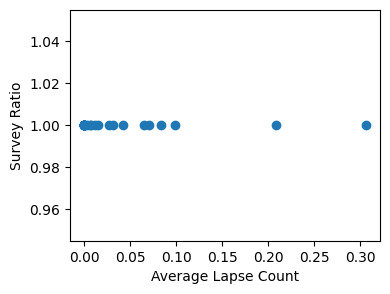

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.2277, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1456, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1825, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1587, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2065, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1792, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2010, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2077, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1710, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1608, device='cuda:1', grad_fn=<MeanBackward0>)


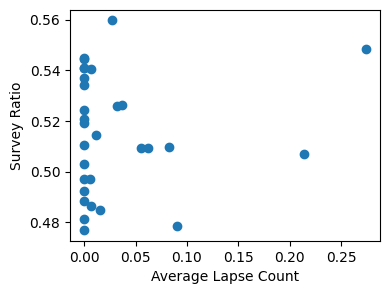

Average Survey Ratio: 0.5151282401971202
AUC = 0.89
tensor(0.1847, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1550, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1578, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1593, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1934, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1832, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1888, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1269, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1680, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1824, device='cuda:1', grad_fn=<MeanBackward0>)


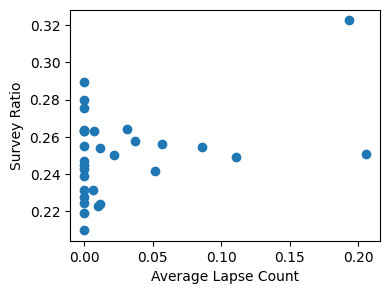

Average Survey Ratio: 0.2505892003609903
AUC = 0.88
tensor(0.2125, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2058, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2018, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1863, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2229, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1507, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1988, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1913, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1922, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2351, device='cuda:1', grad_fn=<MeanBackward0>)


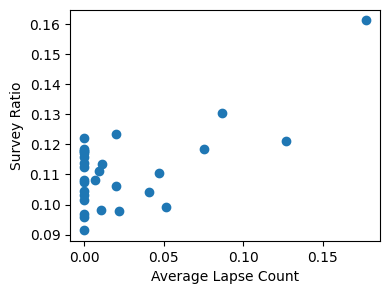

Average Survey Ratio: 0.11162466260887373
AUC = 0.86
tensor(0.1972, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2153, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2059, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2115, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2219, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1888, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2047, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2053, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1659, device='cuda:1', grad_fn=<MeanBackward0>)


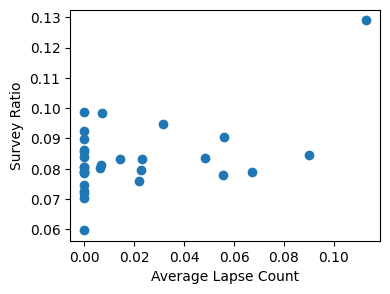

Average Survey Ratio: 0.08348038070436552
AUC = 0.86
-----------------------------------------------
torch.Size([30064, 173]) torch.Size([7152, 173])
565 1366 7152
XgBoost: AUC = 0.88
torch.Size([30064, 173])
tensor(0.1578, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.88
---------------------------------------------------
Device set to : cuda:1
tensor(0.2192, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1939, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2260, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1867, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1717, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1796, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1609, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1581, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2071, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1480, device='cuda:1', grad_fn=<MeanBackward0>)


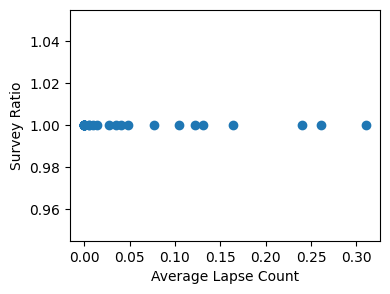

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.2000, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1606, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1551, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1987, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1889, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1472, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1837, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2092, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1763, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2111, device='cuda:1', grad_fn=<MeanBackward0>)


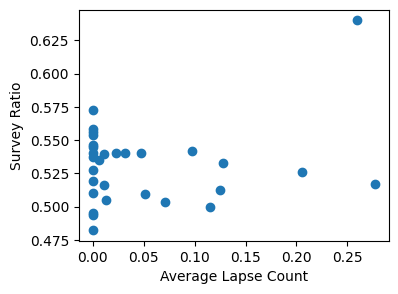

Average Survey Ratio: 0.5312787582783111
AUC = 0.87
tensor(0.1850, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1785, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2391, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1956, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1885, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1666, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1457, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1832, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1682, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1644, device='cuda:1', grad_fn=<MeanBackward0>)


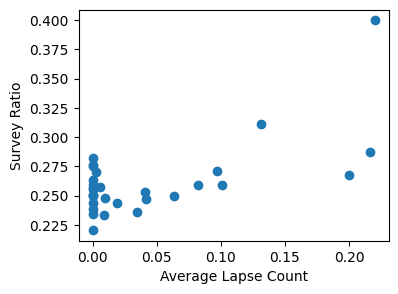

Average Survey Ratio: 0.26166929090972896
AUC = 0.86
tensor(0.1709, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1923, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2017, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1542, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2239, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1683, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2055, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1726, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1617, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1733, device='cuda:1', grad_fn=<MeanBackward0>)


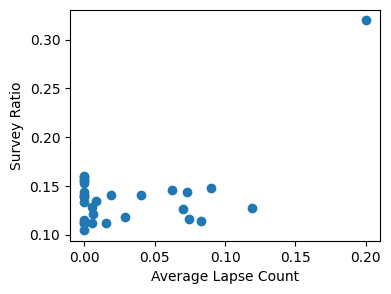

Average Survey Ratio: 0.13897176652367701
AUC = 0.85
tensor(0.1961, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1708, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1800, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1857, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2072, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1749, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1726, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1712, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1835, device='cuda:1', grad_fn=<MeanBackward0>)


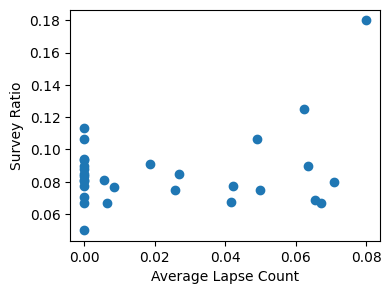

Average Survey Ratio: 0.08637808260792311
AUC = 0.85
-----------------------------------------------
torch.Size([29285, 173]) torch.Size([7931, 173])
729 2011 7931
XgBoost: AUC = 0.87
torch.Size([29285, 173])
tensor(0.1710, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.86
---------------------------------------------------
Device set to : cuda:1
tensor(0.2054, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1711, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1665, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1761, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1680, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1670, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1531, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1701, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1702, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1342, device='cuda:1', grad_fn=<MeanBackward0>)


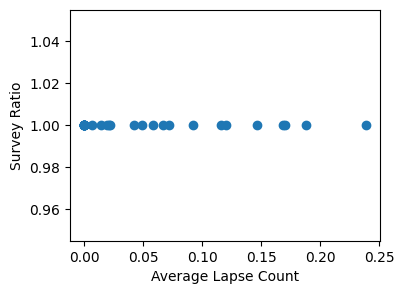

Average Survey Ratio: 1.0
AUC = 0.86
tensor(0.1767, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1279, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1447, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1873, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1414, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1607, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1728, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1771, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1736, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1735, device='cuda:1', grad_fn=<MeanBackward0>)


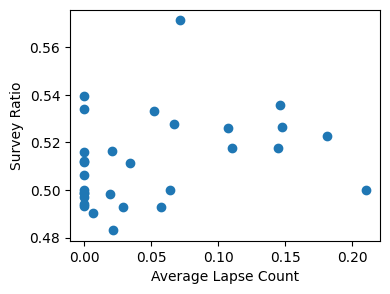

Average Survey Ratio: 0.5121941828987822
AUC = 0.85
tensor(0.2138, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1534, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1512, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1701, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1746, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2254, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1609, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2262, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1894, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2091, device='cuda:1', grad_fn=<MeanBackward0>)


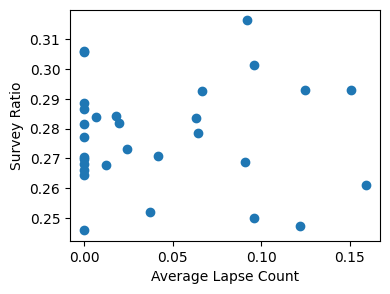

Average Survey Ratio: 0.2776987139036515
AUC = 0.83
tensor(0.1621, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1929, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1645, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1786, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1678, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2237, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2183, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1285, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1746, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1519, device='cuda:1', grad_fn=<MeanBackward0>)


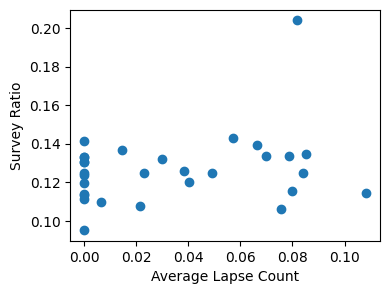

Average Survey Ratio: 0.1267244206835456
AUC = 0.83
tensor(0.1917, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1622, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1685, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1817, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1629, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1731, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1658, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1638, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1737, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1924, device='cuda:1', grad_fn=<MeanBackward0>)


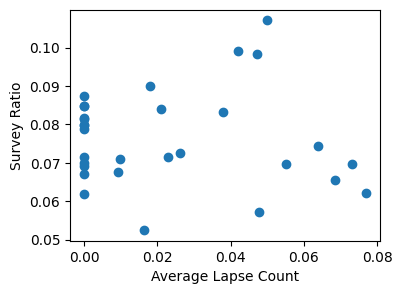

Average Survey Ratio: 0.07646836809855265
AUC = 0.82
-----------------------------------------------
torch.Size([29738, 173]) torch.Size([7478, 173])
776 1734 7478
XgBoost: AUC = 0.90
torch.Size([29738, 173])
tensor(0.3353, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.91
---------------------------------------------------
Device set to : cuda:1
tensor(0.1938, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1874, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1945, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2183, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1804, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1801, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1397, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1708, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1742, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1228, device='cuda:1', grad_fn=<MeanBackward0>)


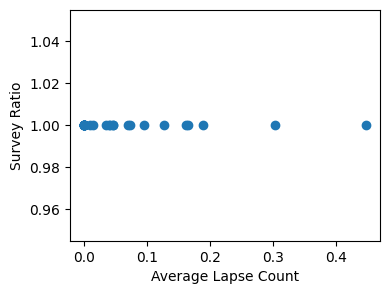

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1657, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1748, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1851, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1776, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1576, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1709, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1849, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1729, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2308, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)


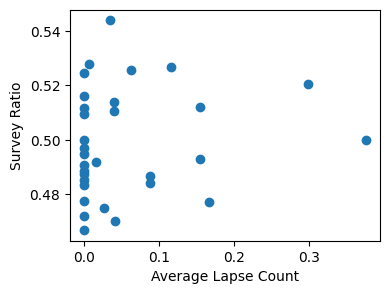

Average Survey Ratio: 0.49888804379172114
AUC = 0.90
tensor(0.1808, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1739, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1940, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1617, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1808, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1803, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1796, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1397, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1437, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1803, device='cuda:1', grad_fn=<MeanBackward0>)


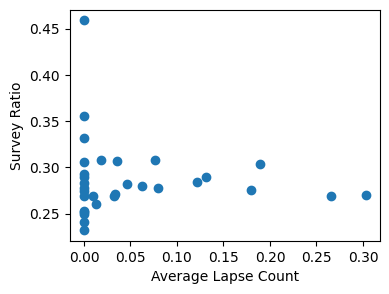

Average Survey Ratio: 0.2866760753405781
AUC = 0.87
tensor(0.1954, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1907, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1761, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2196, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1831, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1524, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1646, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1738, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1830, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1640, device='cuda:1', grad_fn=<MeanBackward0>)


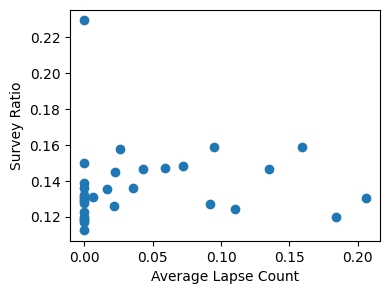

Average Survey Ratio: 0.13714811563152365
AUC = 0.90
tensor(0.1869, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2060, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2031, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1971, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2106, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2203, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1679, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2108, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1954, device='cuda:1', grad_fn=<MeanBackward0>)


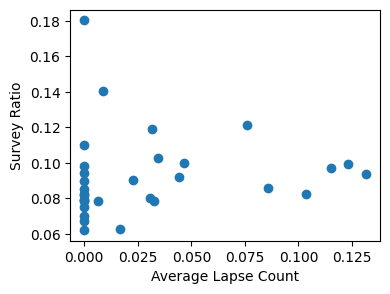

Average Survey Ratio: 0.09218214749916688
AUC = 0.88
-----------------------------------------------
{'xg': [0.8778403589119772, 0.8790191697226983, 0.8839160266064426, 0.8724503633916657, 0.8954764618655148], 1: [0.8722883399753685, 0.8837066483330113, 0.876912825073791, 0.8566218079187726, 0.9039879232849404], 2: [0.8538039268195999, 0.8886755201591621, 0.8700055486067354, 0.8481878414356019, 0.8974905936679926], 4: [0.8361413520399672, 0.8808202764346111, 0.8610722917626701, 0.8304780450789275, 0.8729385673456453], 10: [0.8199312496406643, 0.8619414534796173, 0.848977269521221, 0.8251600207075537, 0.8955394335280744], 20: [0.8338167342974119, 0.8610124756062503, 0.8542140526190634, 0.8186466265086402, 0.8776599037985275]}
torch.Size([29739, 173]) torch.Size([7477, 173])
720 1740 7477
XgBoost: AUC = 0.90
torch.Size([29739, 173])
tensor(0.3757, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.91
---------------------------------------------------
Device set to : cuda:1
tensor(0.2012, device='c

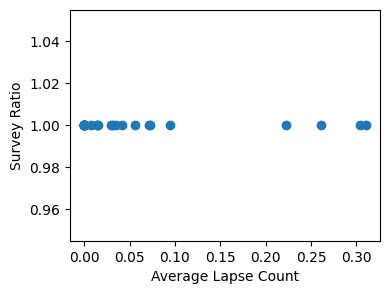

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1414, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1359, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1638, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1351, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1889, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1768, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1501, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1761, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1731, device='cuda:1', grad_fn=<MeanBackward0>)


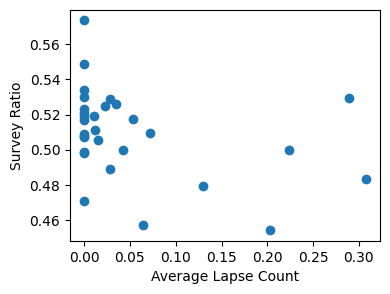

Average Survey Ratio: 0.5098120869219942
AUC = 0.88
tensor(0.1673, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1974, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1692, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1799, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1794, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1783, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1449, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1839, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1807, device='cuda:1', grad_fn=<MeanBackward0>)


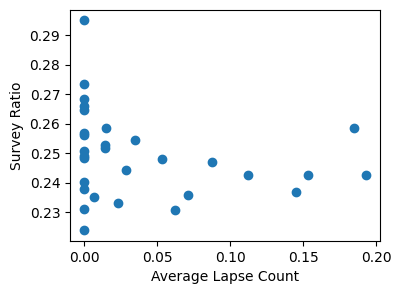

Average Survey Ratio: 0.2492188709067891
AUC = 0.87
tensor(0.2087, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1896, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1938, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1408, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1696, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1715, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1734, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1902, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1969, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1950, device='cuda:1', grad_fn=<MeanBackward0>)


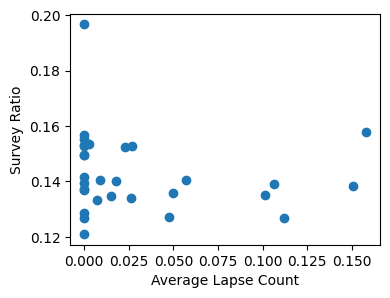

Average Survey Ratio: 0.14292579271014427
AUC = 0.88
tensor(0.1817, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2047, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1892, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1785, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1754, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1668, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2033, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1889, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1833, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2175, device='cuda:1', grad_fn=<MeanBackward0>)


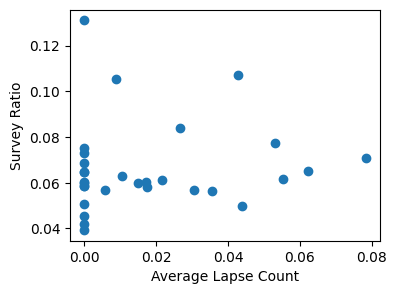

Average Survey Ratio: 0.06620344119933123
AUC = 0.86
-----------------------------------------------
torch.Size([29856, 173]) torch.Size([7360, 173])
650 2363 7360
XgBoost: AUC = 0.83
torch.Size([29856, 173])
tensor(0.1486, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.86
---------------------------------------------------
Device set to : cuda:1
tensor(0.1969, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1538, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2235, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1549, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1664, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1610, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1522, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1609, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1845, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1309, device='cuda:1', grad_fn=<MeanBackward0>)


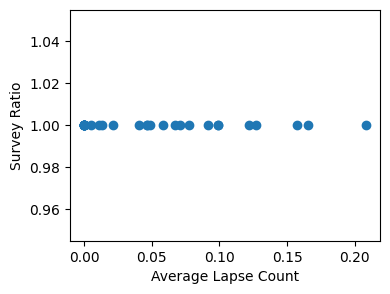

Average Survey Ratio: 1.0
AUC = 0.86
tensor(0.1471, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1533, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1237, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1296, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1441, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1665, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1524, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1499, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1726, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1887, device='cuda:1', grad_fn=<MeanBackward0>)


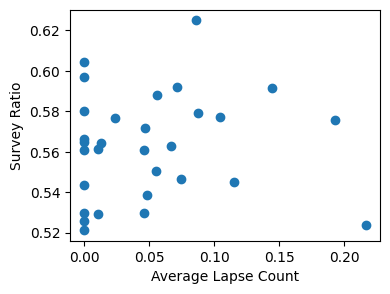

Average Survey Ratio: 0.5628423437994872
AUC = 0.84
tensor(0.1551, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1663, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1506, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1723, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1718, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2181, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1510, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2050, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1374, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1578, device='cuda:1', grad_fn=<MeanBackward0>)


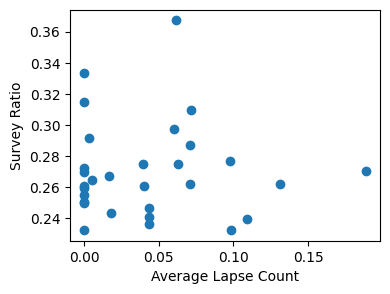

Average Survey Ratio: 0.2701813642704179
AUC = 0.83
tensor(0.1749, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1607, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2085, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1473, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1699, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2039, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1744, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1889, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2090, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1831, device='cuda:1', grad_fn=<MeanBackward0>)


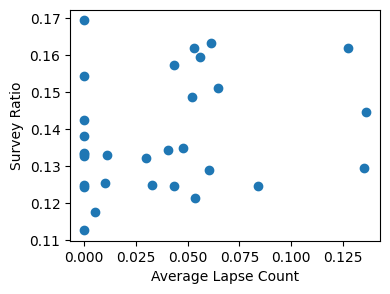

Average Survey Ratio: 0.13821850820264997
AUC = 0.83
tensor(0.1650, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1756, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1796, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1525, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1987, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1606, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2042, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1760, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1887, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1730, device='cuda:1', grad_fn=<MeanBackward0>)


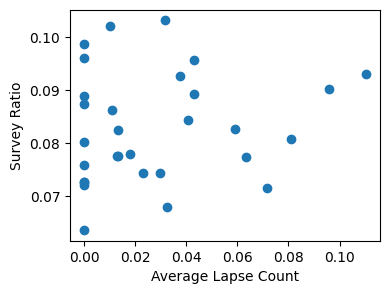

Average Survey Ratio: 0.08300655745747675
AUC = 0.77
-----------------------------------------------
torch.Size([30527, 173]) torch.Size([6689, 173])
692 1659 6689
XgBoost: AUC = 0.89
torch.Size([30527, 173])
tensor(0.1869, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.88
---------------------------------------------------
Device set to : cuda:1
tensor(0.2156, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1949, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2119, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1940, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1633, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1840, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1553, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1383, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1445, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1636, device='cuda:1', grad_fn=<MeanBackward0>)


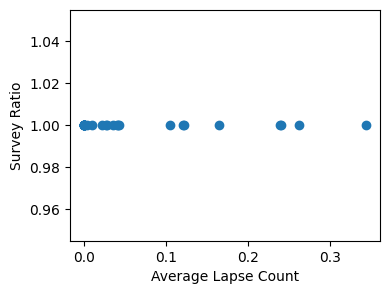

Average Survey Ratio: 1.0
AUC = 0.87
tensor(0.1344, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1427, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1498, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1653, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1766, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1772, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2103, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2059, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1365, device='cuda:1', grad_fn=<MeanBackward0>)


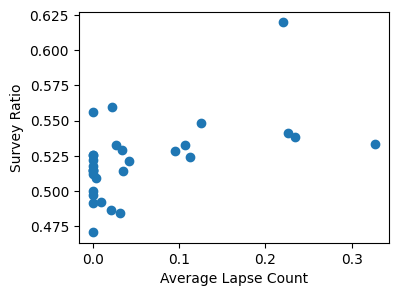

Average Survey Ratio: 0.5219174477038294
AUC = 0.87
tensor(0.1865, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1597, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1628, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1707, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1539, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1598, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1803, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1585, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1757, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1771, device='cuda:1', grad_fn=<MeanBackward0>)


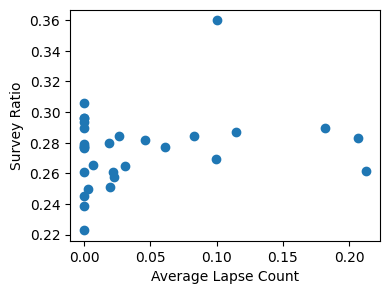

Average Survey Ratio: 0.2756661582088877
AUC = 0.84
tensor(0.1688, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1605, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2000, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1674, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1870, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1556, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1837, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1746, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1561, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2115, device='cuda:1', grad_fn=<MeanBackward0>)


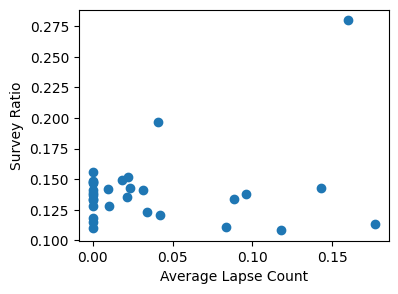

Average Survey Ratio: 0.1404693583821079
AUC = 0.85
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1752, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1973, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1721, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2072, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2079, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1990, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1937, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1963, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1875, device='cuda:1', grad_fn=<MeanBackward0>)


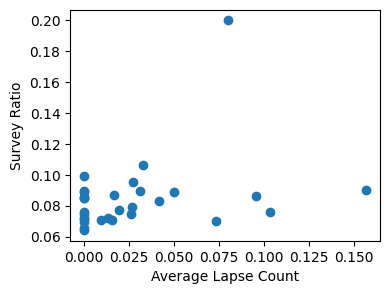

Average Survey Ratio: 0.08472480753995809
AUC = 0.83
-----------------------------------------------
torch.Size([29538, 173]) torch.Size([7678, 173])
487 1148 7678
XgBoost: AUC = 0.90
torch.Size([29538, 173])
tensor(0.1674, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2637, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2217, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1985, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1830, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2047, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1780, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1944, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1771, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1775, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2270, device='cuda:1', grad_fn=<MeanBackward0>)


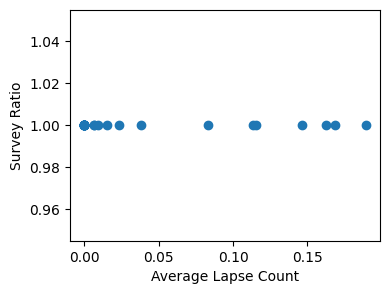

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.2016, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1862, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1785, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1365, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2093, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1842, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2189, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1927, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1664, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2110, device='cuda:1', grad_fn=<MeanBackward0>)


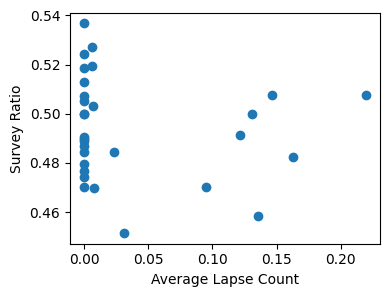

Average Survey Ratio: 0.49399635178334594
AUC = 0.88
tensor(0.1646, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1864, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1577, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1895, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1978, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1830, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1661, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1706, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1826, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1881, device='cuda:1', grad_fn=<MeanBackward0>)


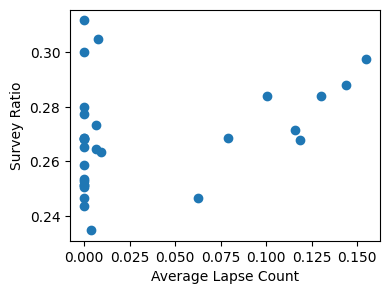

Average Survey Ratio: 0.2688916390471959
AUC = 0.88
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2308, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2282, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2056, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2219, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2077, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2152, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1874, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1802, device='cuda:1', grad_fn=<MeanBackward0>)


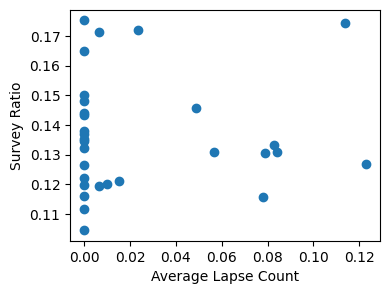

Average Survey Ratio: 0.13650162691966697
AUC = 0.88
tensor(0.1962, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1936, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2078, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2027, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2022, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2111, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2011, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1859, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2156, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2546, device='cuda:1', grad_fn=<MeanBackward0>)


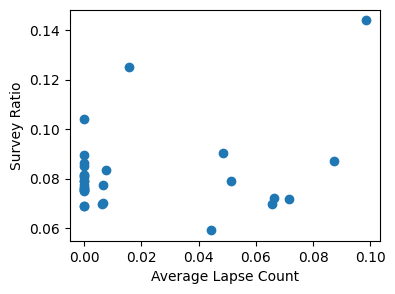

Average Survey Ratio: 0.08198235713555269
AUC = 0.87
-----------------------------------------------
torch.Size([29204, 173]) torch.Size([8012, 173])
753 2003 8012
XgBoost: AUC = 0.91
torch.Size([29204, 173])
tensor(0.1433, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2263, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2229, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2111, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1998, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1612, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2043, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1536, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1861, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2153, device='cuda:1', grad_fn=<MeanBackward0>)


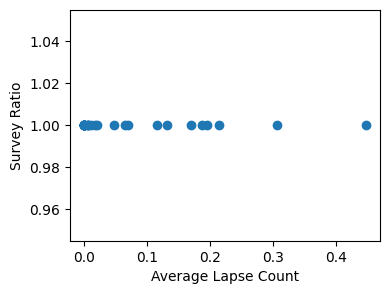

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1647, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1507, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1563, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1812, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2071, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2039, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1778, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1586, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2068, device='cuda:1', grad_fn=<MeanBackward0>)


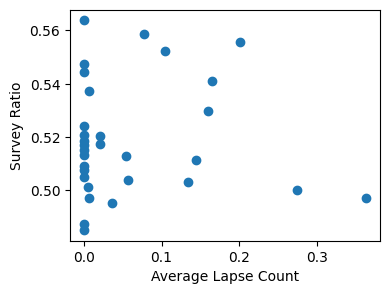

Average Survey Ratio: 0.519089354029852
AUC = 0.89
tensor(0.2050, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1543, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1246, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1553, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1957, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1519, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1717, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1847, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1896, device='cuda:1', grad_fn=<MeanBackward0>)


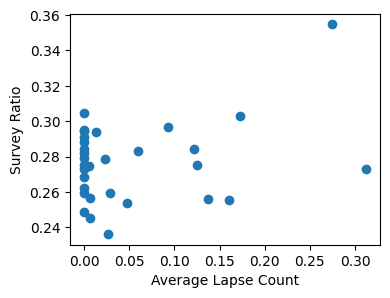

Average Survey Ratio: 0.27693153562230266
AUC = 0.89
tensor(0.1944, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1708, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2218, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1358, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1887, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1767, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1705, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1723, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1384, device='cuda:1', grad_fn=<MeanBackward0>)


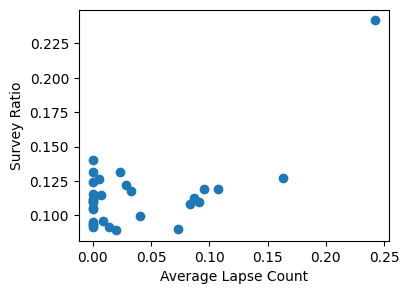

Average Survey Ratio: 0.11455439127339616
AUC = 0.89
tensor(0.1689, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1980, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1545, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2083, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1763, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2207, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1835, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1951, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1746, device='cuda:1', grad_fn=<MeanBackward0>)


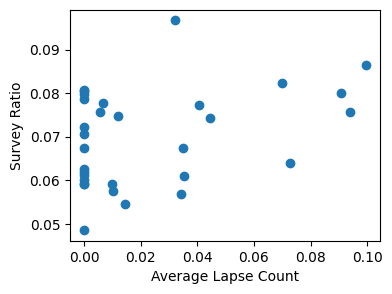

Average Survey Ratio: 0.06980941854681186
AUC = 0.85
-----------------------------------------------
{'xg': [0.9031889768634995, 0.8310030952653903, 0.8905065490355969, 0.8960254904530733, 0.9062513778289056], 1: [0.9046564879219904, 0.857651266766021, 0.8734950326801165, 0.8989716497664061, 0.8964941080605713], 2: [0.8824632479897391, 0.8362348962512897, 0.8679862570977204, 0.8775451404147951, 0.8922566610080778], 4: [0.870885542564912, 0.827491230081394, 0.8449007740864651, 0.8763626789932774, 0.8878429433297714], 10: [0.8849212956111357, 0.8326028889143643, 0.852686699804623, 0.8762367515634562, 0.8868522786294324], 20: [0.8587373382336013, 0.7744365470594978, 0.8347029969705468, 0.8724342286173938, 0.8479372677815167]}
torch.Size([29952, 173]) torch.Size([7264, 173])
611 1692 7264
XgBoost: AUC = 0.85
torch.Size([29952, 173])
tensor(0.1402, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.85
---------------------------------------------------
Device set to : cuda:1
tensor(0.2698, device='cud

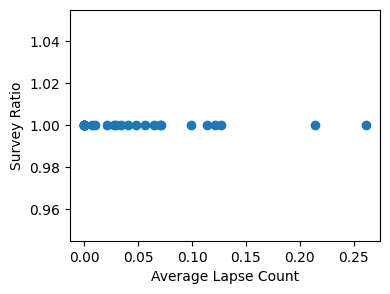

Average Survey Ratio: 1.0
AUC = 0.85
tensor(0.1835, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1394, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1579, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1463, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1684, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1492, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1521, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1346, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1669, device='cuda:1', grad_fn=<MeanBackward0>)


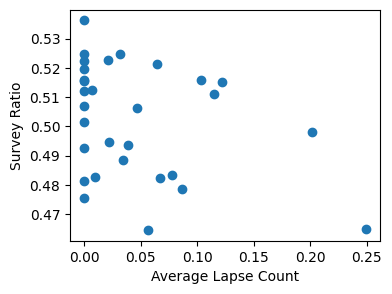

Average Survey Ratio: 0.5021423013198272
AUC = 0.84
tensor(0.1058, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1679, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2006, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1883, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1658, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1576, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1615, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1603, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1507, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1413, device='cuda:1', grad_fn=<MeanBackward0>)


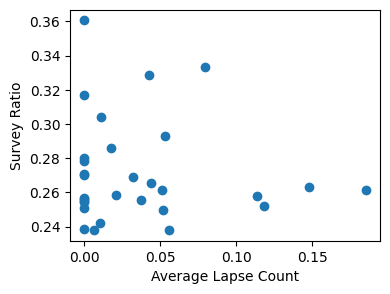

Average Survey Ratio: 0.27153674339543243
AUC = 0.82
tensor(0.2089, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2102, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1901, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1533, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1562, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1855, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1574, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1642, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1943, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1489, device='cuda:1', grad_fn=<MeanBackward0>)


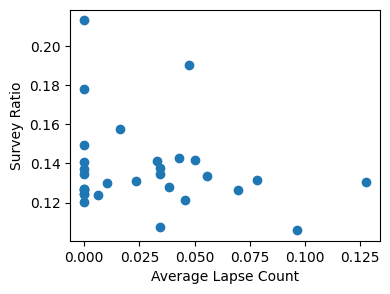

Average Survey Ratio: 0.13731142668466198
AUC = 0.81
tensor(0.1534, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1531, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1711, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1823, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1919, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1816, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1940, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1514, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1671, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1745, device='cuda:1', grad_fn=<MeanBackward0>)


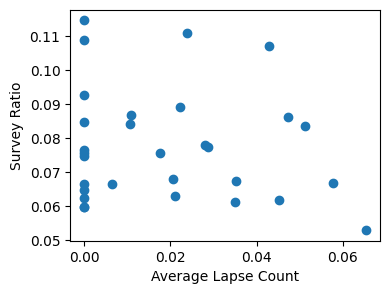

Average Survey Ratio: 0.07763734078979628
AUC = 0.79
-----------------------------------------------
torch.Size([29677, 173]) torch.Size([7539, 173])
751 2447 7539
XgBoost: AUC = 0.87
torch.Size([29677, 173])
tensor(0.1430, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.2157, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1675, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1670, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1625, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1910, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1464, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1178, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1409, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1254, device='cuda:1', grad_fn=<MeanBackward0>)


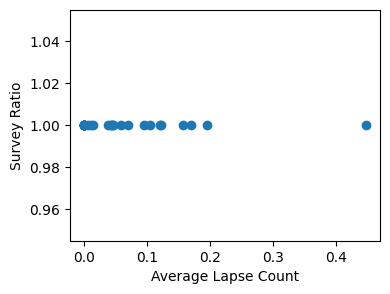

Average Survey Ratio: 1.0
AUC = 0.89
tensor(0.1659, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1366, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1447, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1624, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1738, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1782, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1453, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1564, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1529, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1695, device='cuda:1', grad_fn=<MeanBackward0>)


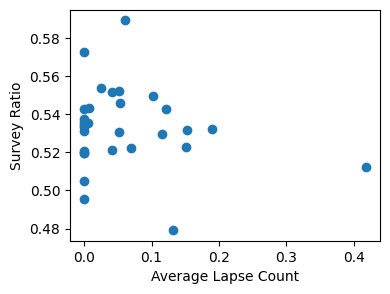

Average Survey Ratio: 0.5330988316552643
AUC = 0.87
tensor(0.1782, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1583, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1428, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1694, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1814, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2301, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1998, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1726, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2159, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1667, device='cuda:1', grad_fn=<MeanBackward0>)


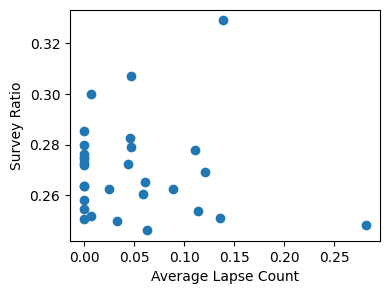

Average Survey Ratio: 0.2698578872456665
AUC = 0.87
tensor(0.1371, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1790, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2065, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2138, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1914, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1984, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1634, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2087, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2174, device='cuda:1', grad_fn=<MeanBackward0>)


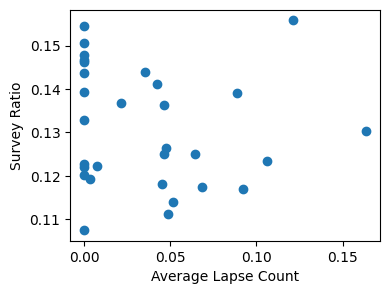

Average Survey Ratio: 0.13120815263080482
AUC = 0.86
tensor(0.2172, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1883, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2042, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1974, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2026, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2014, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1690, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1802, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2056, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1754, device='cuda:1', grad_fn=<MeanBackward0>)


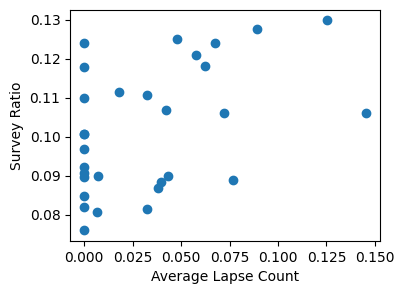

Average Survey Ratio: 0.10192336204294333
AUC = 0.85
-----------------------------------------------
torch.Size([30266, 173]) torch.Size([6950, 173])
609 1528 6950
XgBoost: AUC = 0.90
torch.Size([30266, 173])
tensor(0.1644, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.87
---------------------------------------------------
Device set to : cuda:1
tensor(0.2186, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2224, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2247, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2101, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1858, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1830, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1467, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1559, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1509, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1640, device='cuda:1', grad_fn=<MeanBackward0>)


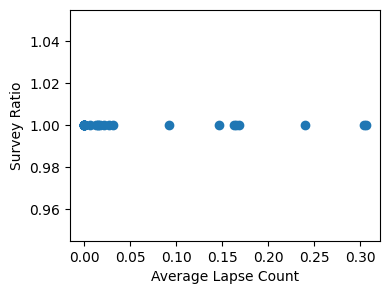

Average Survey Ratio: 1.0
AUC = 0.87
tensor(0.1975, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1735, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1725, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1997, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1748, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2187, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1649, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2084, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1842, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1608, device='cuda:1', grad_fn=<MeanBackward0>)


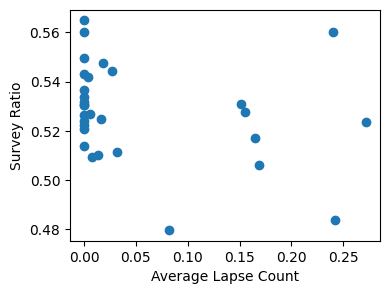

Average Survey Ratio: 0.5277622554430896
AUC = 0.86
tensor(0.2029, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1662, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1785, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1759, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2014, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1762, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2432, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1667, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1806, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1826, device='cuda:1', grad_fn=<MeanBackward0>)


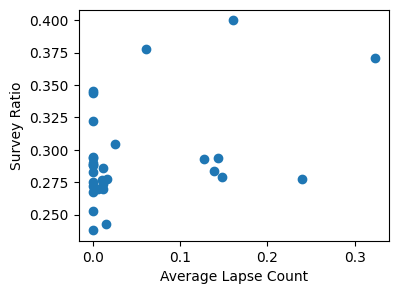

Average Survey Ratio: 0.2943092395245882
AUC = 0.86
tensor(0.1585, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1835, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1870, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2216, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1648, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2039, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1645, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2312, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1868, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1814, device='cuda:1', grad_fn=<MeanBackward0>)


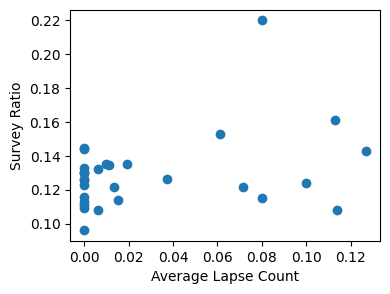

Average Survey Ratio: 0.12948742737350388
AUC = 0.85
tensor(0.1837, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1974, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1952, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2109, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1545, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1853, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2081, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2163, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1527, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2066, device='cuda:1', grad_fn=<MeanBackward0>)


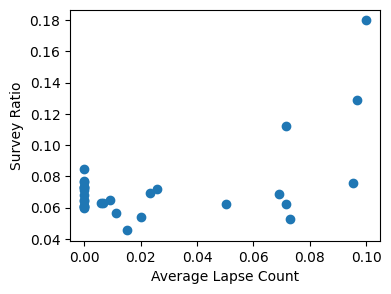

Average Survey Ratio: 0.07319488820551064
AUC = 0.87
-----------------------------------------------
torch.Size([29359, 173]) torch.Size([7857, 173])
501 1595 7857
XgBoost: AUC = 0.90
torch.Size([29359, 173])
tensor(0.1769, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.91
---------------------------------------------------
Device set to : cuda:1
tensor(0.2064, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2375, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1951, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1738, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2395, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2120, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1681, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1959, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1685, device='cuda:1', grad_fn=<MeanBackward0>)


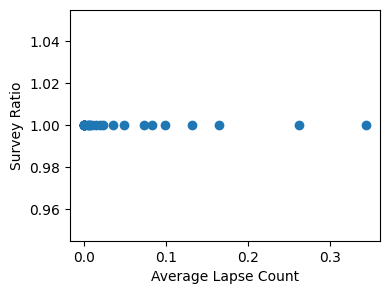

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.2113, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2194, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1387, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2105, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1598, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1611, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1756, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1629, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1534, device='cuda:1', grad_fn=<MeanBackward0>)


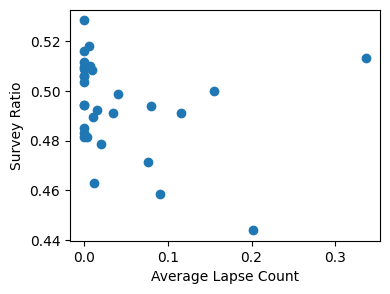

Average Survey Ratio: 0.49438159490371597
AUC = 0.89
tensor(0.1938, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1551, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1521, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1920, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1603, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2225, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1836, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1810, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)


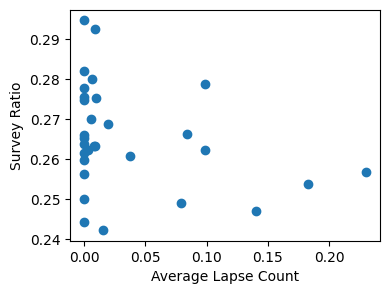

Average Survey Ratio: 0.2654740301385868
AUC = 0.87
tensor(0.2353, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2077, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1812, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2116, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1792, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2176, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1702, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1925, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1721, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1794, device='cuda:1', grad_fn=<MeanBackward0>)


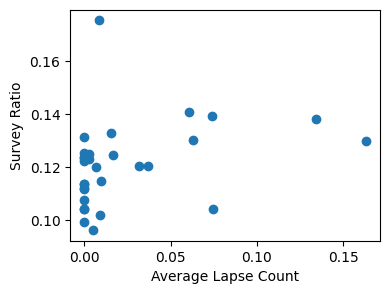

Average Survey Ratio: 0.12101779647381297
AUC = 0.84
tensor(0.2106, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2274, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2036, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1875, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2003, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1766, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1459, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2594, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2113, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2478, device='cuda:1', grad_fn=<MeanBackward0>)


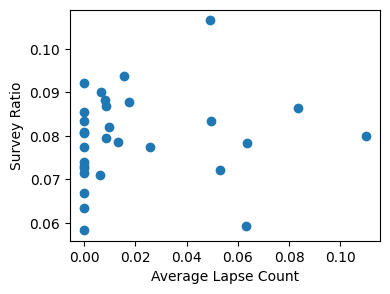

Average Survey Ratio: 0.07935712318268656
AUC = 0.87
-----------------------------------------------
torch.Size([29610, 173]) torch.Size([7606, 173])
830 1917 7606
XgBoost: AUC = 0.92
torch.Size([29610, 173])
tensor(0.1822, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.91
---------------------------------------------------
Device set to : cuda:1
tensor(0.2333, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1702, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2147, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2094, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1977, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1936, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1839, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1914, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1418, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1542, device='cuda:1', grad_fn=<MeanBackward0>)


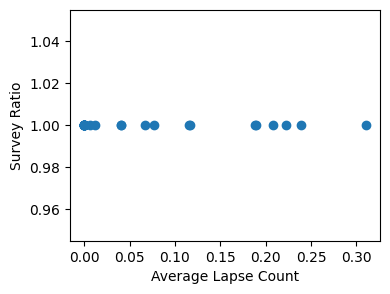

Average Survey Ratio: 1.0
AUC = 0.91
tensor(0.2082, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1222, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1875, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1724, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1655, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1706, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1168, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1335, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1841, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1272, device='cuda:1', grad_fn=<MeanBackward0>)


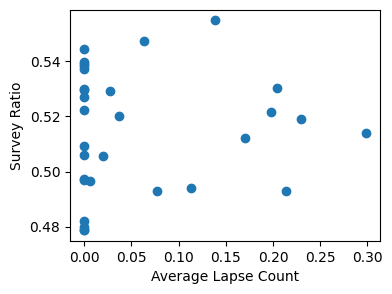

Average Survey Ratio: 0.5150911215946707
AUC = 0.90
tensor(0.1992, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1829, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1542, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1418, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1527, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1826, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1637, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1600, device='cuda:1', grad_fn=<MeanBackward0>)


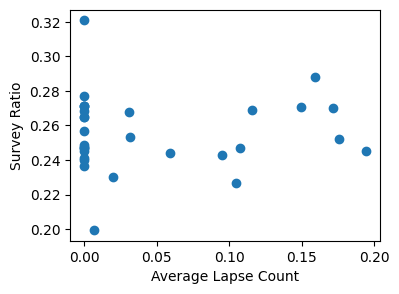

Average Survey Ratio: 0.25564085703571127
AUC = 0.89
tensor(0.1711, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1486, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1631, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1794, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1911, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1500, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1919, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1714, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1277, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1712, device='cuda:1', grad_fn=<MeanBackward0>)


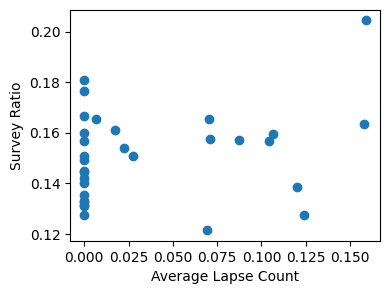

Average Survey Ratio: 0.1511354915727253
AUC = 0.88
tensor(0.1509, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2030, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1364, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1942, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2004, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1845, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2386, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1726, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2126, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1692, device='cuda:1', grad_fn=<MeanBackward0>)


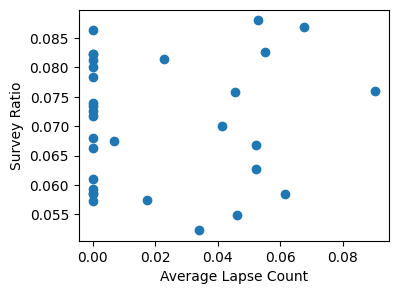

Average Survey Ratio: 0.07073360729524329
AUC = 0.86
-----------------------------------------------
{'xg': [0.8514778536589207, 0.8666303894944238, 0.8963006668878144, 0.9007114916442265, 0.9246411857583817], 1: [0.8540537561903703, 0.8872428590596549, 0.8713084938144622, 0.9017864217188246, 0.9062554231092018], 2: [0.843564905437489, 0.8737560290855563, 0.8567532587593603, 0.893292534018423, 0.8986641370677516], 4: [0.8171801702491746, 0.8690946936200564, 0.863293824509558, 0.8729856762820201, 0.8862400605965777], 10: [0.8109701811791096, 0.8552190675642064, 0.846816622553616, 0.8438016571533387, 0.8798276340308104], 20: [0.7871577814716568, 0.8496086930252886, 0.8721613633897675, 0.86620654829547, 0.8604804696945989]}
key:  xg mean:  0.8865772109116707 median:  0.8906605656393753
key:  1 mean:  0.8833156947460185 median:  0.8803097367034012
key:  2 mean:  0.8727522732922974 median:  0.8747545619530742
key:  4 mean:  0.862090676747864 median:  0.868333845801067
key:  10 mean:  0.8572

In [42]:
AUC_dict = {}
for j in range(6):
    dic = k_fold_test()
    if( j == 0 ):
        AUC_dict = dic
    else:
        for key in AUC_dict.keys():
            AUC_dict[key].extend(dic[key])
            
for key in AUC_dict.keys():
    print('key: ', key, 'mean: ', np.mean(AUC_dict[key]), 'median: ', np.median(AUC_dict[key]))

torch.Size([29505, 173]) torch.Size([7711, 173])
539 1756 7711
XgBoost: AUC = 0.87
torch.Size([29505, 173])
tensor(0.1366, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.87
---------------------------------------------------
Device set to : cuda:1
tensor(0.2222, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2259, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1810, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1888, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1705, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1835, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1864, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1708, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)


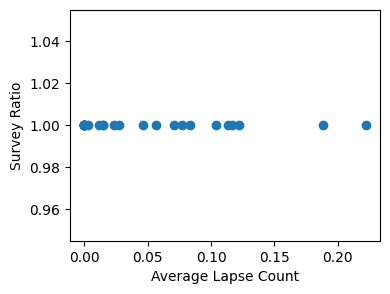

Average Survey Ratio: 1.0
AUC = 0.86
tensor(0.1494, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1414, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2047, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1771, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1829, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1534, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2085, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1949, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1351, device='cuda:1', grad_fn=<MeanBackward0>)


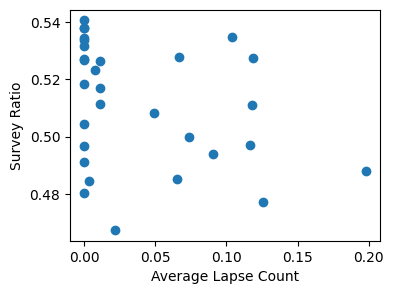

Average Survey Ratio: 0.511403078404817
AUC = 0.86
tensor(0.1922, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2149, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1923, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1950, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1555, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1734, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1682, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1840, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1950, device='cuda:1', grad_fn=<MeanBackward0>)


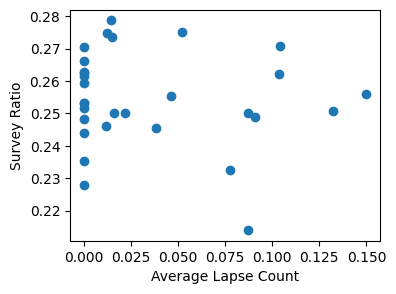

Average Survey Ratio: 0.25435451396578285
AUC = 0.85
tensor(0.2032, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2102, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1490, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1995, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1768, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2112, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1747, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1530, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1951, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1600, device='cuda:1', grad_fn=<MeanBackward0>)


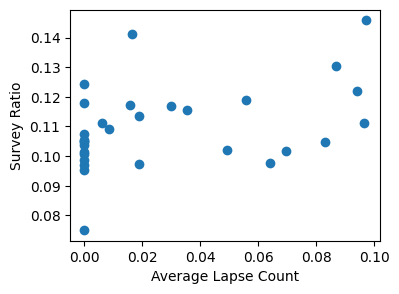

Average Survey Ratio: 0.10974793545649852
AUC = 0.80
tensor(0.1966, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1700, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2230, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1937, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2392, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1878, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1793, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2060, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1911, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2393, device='cuda:1', grad_fn=<MeanBackward0>)


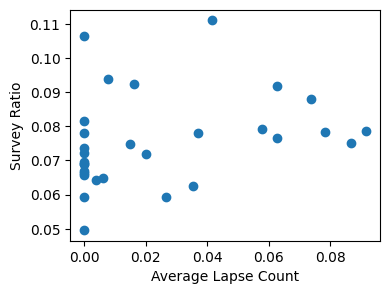

Average Survey Ratio: 0.07560770288385976
AUC = 0.80
-----------------------------------------------
torch.Size([30742, 173]) torch.Size([6474, 173])
464 1537 6474
XgBoost: AUC = 0.90
torch.Size([30742, 173])
tensor(0.1813, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.91
---------------------------------------------------
Device set to : cuda:1
tensor(0.1979, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1744, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1796, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1708, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1711, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1850, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1661, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1574, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1581, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1491, device='cuda:1', grad_fn=<MeanBackward0>)


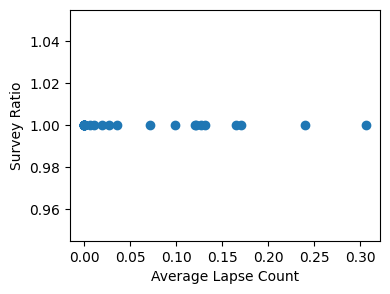

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.2134, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1800, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1867, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1735, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1746, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1793, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1537, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1974, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1766, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1410, device='cuda:1', grad_fn=<MeanBackward0>)


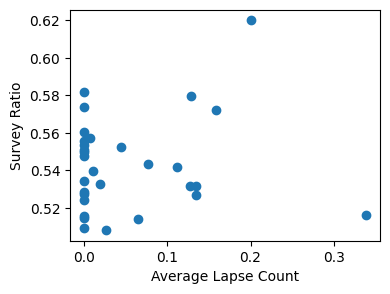

Average Survey Ratio: 0.5432695629329353
AUC = 0.89
tensor(0.1504, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1730, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1753, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1893, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1582, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1542, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1837, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1794, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1749, device='cuda:1', grad_fn=<MeanBackward0>)


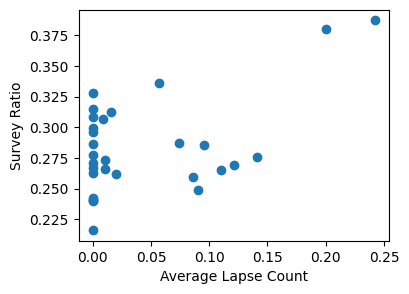

Average Survey Ratio: 0.2835521865217784
AUC = 0.87
tensor(0.1929, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1638, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1534, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2151, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1928, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2160, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1512, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1816, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2000, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1808, device='cuda:1', grad_fn=<MeanBackward0>)


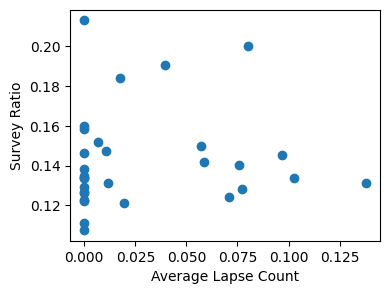

Average Survey Ratio: 0.14282718906911615
AUC = 0.89
tensor(0.1751, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2055, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1678, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1904, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1909, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2143, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1660, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1839, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1963, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2098, device='cuda:1', grad_fn=<MeanBackward0>)


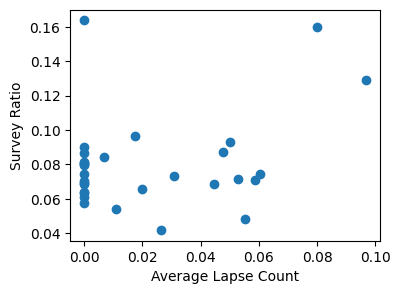

Average Survey Ratio: 0.08028406032208793
AUC = 0.88
-----------------------------------------------
torch.Size([29641, 173]) torch.Size([7575, 173])
473 1236 7575
XgBoost: AUC = 0.93
torch.Size([29641, 173])
tensor(0.1829, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.92
---------------------------------------------------
Device set to : cuda:1
tensor(0.2398, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2532, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2270, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1967, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2406, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1828, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2444, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2366, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2282, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1723, device='cuda:1', grad_fn=<MeanBackward0>)


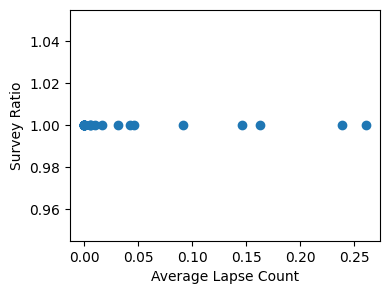

Average Survey Ratio: 1.0
AUC = 0.91
tensor(0.2154, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2358, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1996, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1849, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1987, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1689, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1985, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2041, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1642, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1877, device='cuda:1', grad_fn=<MeanBackward0>)


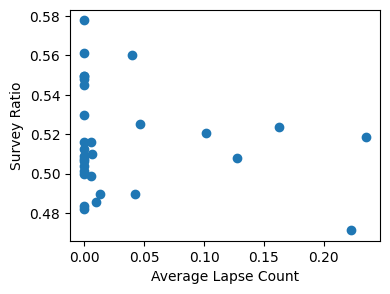

Average Survey Ratio: 0.5166881411603634
AUC = 0.91
tensor(0.1909, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1719, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1554, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2180, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1973, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1915, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2253, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2115, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1679, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2447, device='cuda:1', grad_fn=<MeanBackward0>)


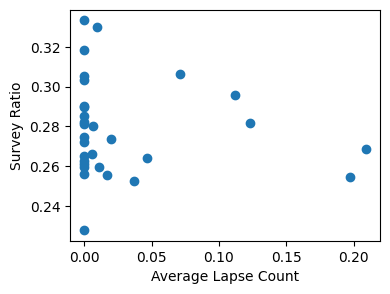

Average Survey Ratio: 0.2785544674733477
AUC = 0.90
tensor(0.2304, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1810, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2114, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1790, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2812, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2139, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1965, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1813, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2365, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2014, device='cuda:1', grad_fn=<MeanBackward0>)


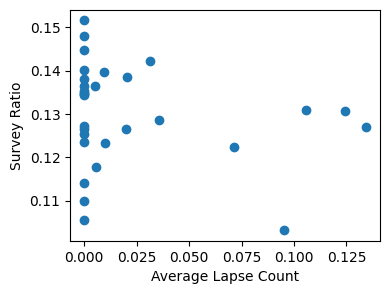

Average Survey Ratio: 0.1298699435358569
AUC = 0.89
tensor(0.2446, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2398, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2138, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2439, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1984, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2714, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1933, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2243, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1998, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2187, device='cuda:1', grad_fn=<MeanBackward0>)


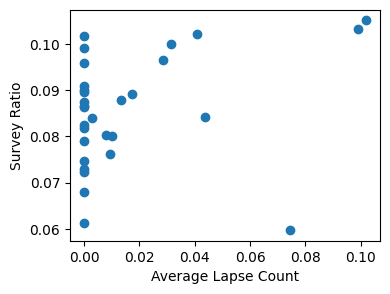

Average Survey Ratio: 0.08558352211377211
AUC = 0.87
-----------------------------------------------
torch.Size([29465, 173]) torch.Size([7751, 173])
706 2351 7751
XgBoost: AUC = 0.85
torch.Size([29465, 173])
tensor(0.1755, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.84
---------------------------------------------------
Device set to : cuda:1
tensor(0.1631, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2024, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2041, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1941, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2418, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2146, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1851, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1706, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1774, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1742, device='cuda:1', grad_fn=<MeanBackward0>)


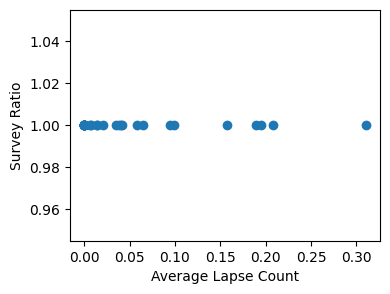

Average Survey Ratio: 1.0
AUC = 0.84
tensor(0.1891, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2132, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2284, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1921, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2601, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1843, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1444, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1418, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1910, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1759, device='cuda:1', grad_fn=<MeanBackward0>)


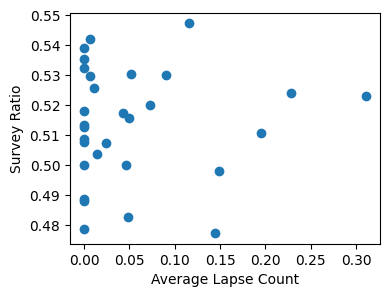

Average Survey Ratio: 0.5135960274447785
AUC = 0.83
tensor(0.1596, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1455, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1475, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1382, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1717, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1601, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2052, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1440, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1478, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1497, device='cuda:1', grad_fn=<MeanBackward0>)


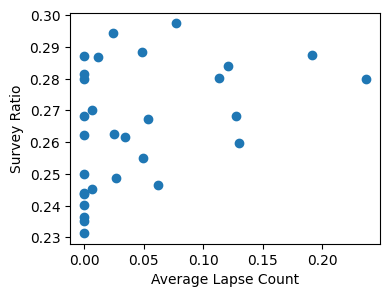

Average Survey Ratio: 0.2647710817109352
AUC = 0.83
tensor(0.1713, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1387, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1755, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1994, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1578, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1624, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1427, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1894, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1540, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1814, device='cuda:1', grad_fn=<MeanBackward0>)


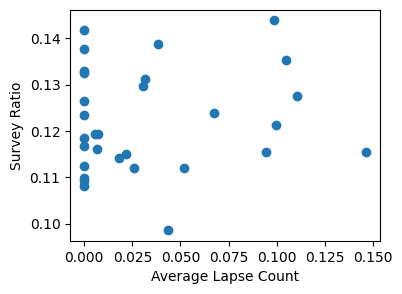

Average Survey Ratio: 0.1219912184446317
AUC = 0.83
tensor(0.1760, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1880, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2373, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1980, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1816, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1692, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2100, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1926, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1861, device='cuda:1', grad_fn=<MeanBackward0>)


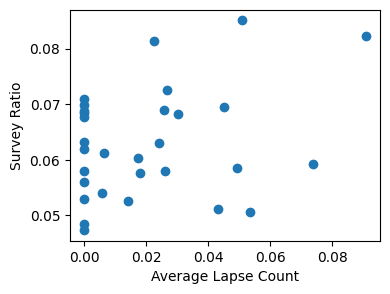

Average Survey Ratio: 0.06292328453942021
AUC = 0.80
-----------------------------------------------
torch.Size([29511, 173]) torch.Size([7705, 173])
1120 2574 7705
XgBoost: AUC = 0.90
torch.Size([29511, 173])
tensor(0.1640, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.88
---------------------------------------------------
Device set to : cuda:1
tensor(0.1645, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1768, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1641, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1952, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1868, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1725, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1457, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1547, device='cuda:1', grad_fn=<MeanBackward0>)


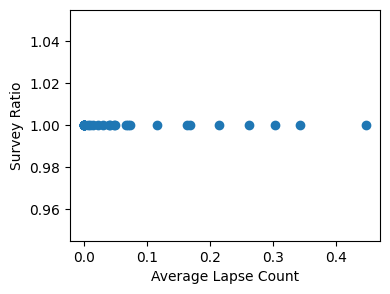

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.1762, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1694, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1320, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1580, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1759, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1373, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1439, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1382, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1963, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1617, device='cuda:1', grad_fn=<MeanBackward0>)


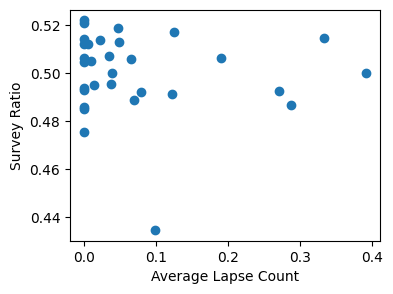

Average Survey Ratio: 0.50010683178961
AUC = 0.88
tensor(0.1675, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1509, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1475, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1285, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1809, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1566, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1623, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1473, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1839, device='cuda:1', grad_fn=<MeanBackward0>)


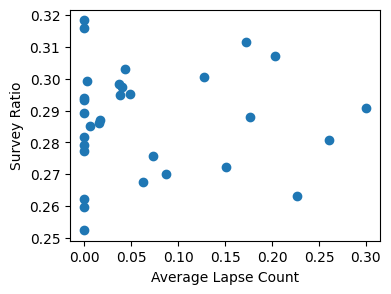

Average Survey Ratio: 0.2870407408874561
AUC = 0.87
tensor(0.2276, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1972, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1831, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1897, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1949, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1637, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1476, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1784, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1995, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1743, device='cuda:1', grad_fn=<MeanBackward0>)


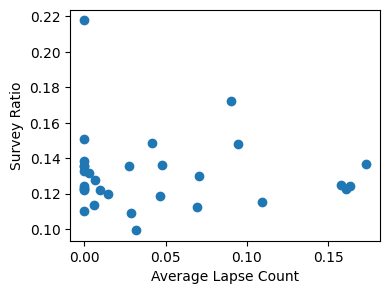

Average Survey Ratio: 0.1310140761958507
AUC = 0.84
tensor(0.1588, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1763, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1878, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1663, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1685, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1878, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2009, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2001, device='cuda:1', grad_fn=<MeanBackward0>)


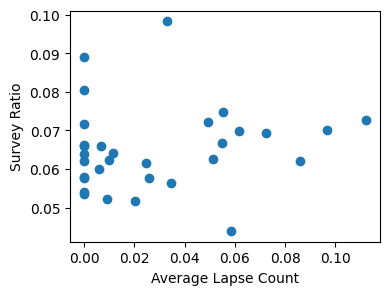

Average Survey Ratio: 0.06506993216250824
AUC = 0.80
-----------------------------------------------
{'xg': [0.8720317209680607, 0.9019482615181593, 0.927779329051817, 0.8516468393190678, 0.8953965994142532], 1: [0.8610940091698598, 0.901428653393769, 0.9126667115180014, 0.8381581778007426, 0.8798112593556785], 2: [0.8580798135813673, 0.8869239127316542, 0.9145579097214076, 0.8332868226717359, 0.876869915392125], 4: [0.8534803973812818, 0.8721997102530266, 0.9037411966852086, 0.8300673332301253, 0.8663237607115739], 10: [0.7982603704159754, 0.8939007903494176, 0.8914515340644895, 0.8312722542457732, 0.8363357603861591], 20: [0.8034878733727431, 0.878718299959837, 0.8740485216027644, 0.8000358882698637, 0.8027193838811151]}
torch.Size([29760, 173]) torch.Size([7456, 173])
624 1623 7456
XgBoost: AUC = 0.90
torch.Size([29760, 173])
tensor(0.1219, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.1801, device='cud

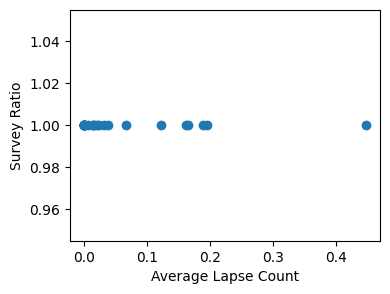

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1647, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1960, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1832, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1938, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2370, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1994, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2187, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1712, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1810, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1929, device='cuda:1', grad_fn=<MeanBackward0>)


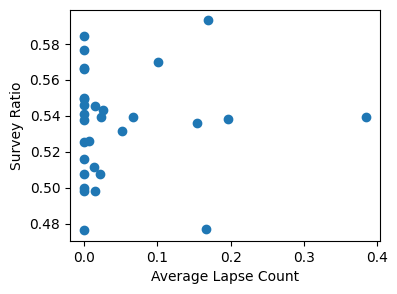

Average Survey Ratio: 0.5345134482626287
AUC = 0.88
tensor(0.1690, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1659, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1897, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1834, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1679, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1959, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2123, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1710, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1917, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1532, device='cuda:1', grad_fn=<MeanBackward0>)


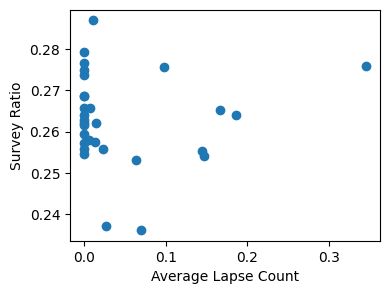

Average Survey Ratio: 0.26287673463935407
AUC = 0.86
tensor(0.1606, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2034, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2024, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2093, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1971, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2122, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1666, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1878, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2083, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2029, device='cuda:1', grad_fn=<MeanBackward0>)


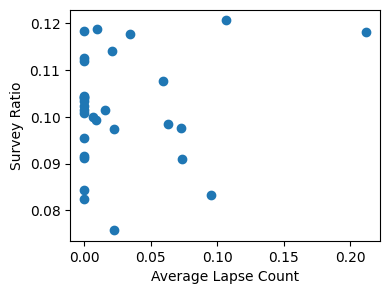

Average Survey Ratio: 0.10167896633910388
AUC = 0.85
tensor(0.1450, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2078, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1879, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1853, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2152, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2002, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1925, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1893, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1916, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2040, device='cuda:1', grad_fn=<MeanBackward0>)


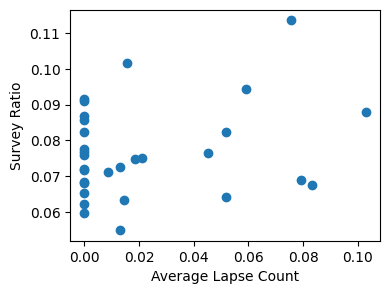

Average Survey Ratio: 0.07677106273899305
AUC = 0.87
-----------------------------------------------
torch.Size([29887, 173]) torch.Size([7329, 173])
411 1190 7329
XgBoost: AUC = 0.91
torch.Size([29887, 173])
tensor(0.1819, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.91
---------------------------------------------------
Device set to : cuda:1
tensor(0.2461, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2193, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2212, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2246, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1878, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1728, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2086, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2419, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2536, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2045, device='cuda:1', grad_fn=<MeanBackward0>)


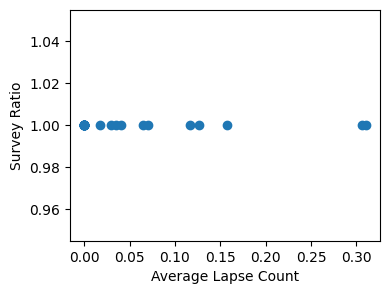

Average Survey Ratio: 1.0
AUC = 0.91
tensor(0.1981, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1911, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1633, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1491, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1718, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1377, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1876, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1772, device='cuda:1', grad_fn=<MeanBackward0>)


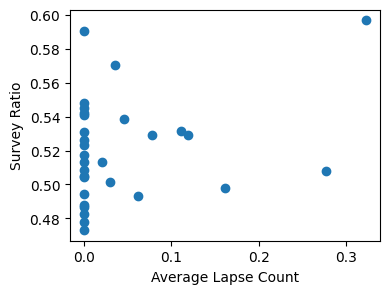

Average Survey Ratio: 0.5202452834393602
AUC = 0.90
tensor(0.2189, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1783, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2194, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2167, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2071, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2052, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1653, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1583, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1668, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1642, device='cuda:1', grad_fn=<MeanBackward0>)


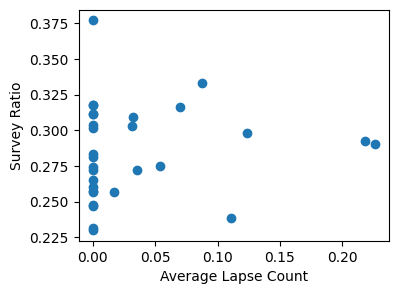

Average Survey Ratio: 0.28439061801149895
AUC = 0.90
tensor(0.1955, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2405, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2189, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2161, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1979, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1752, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1876, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1834, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2026, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2263, device='cuda:1', grad_fn=<MeanBackward0>)


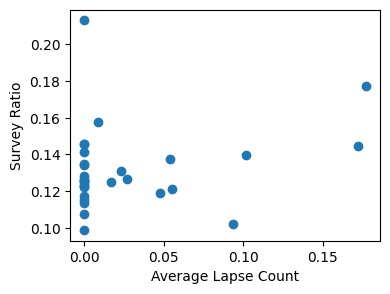

Average Survey Ratio: 0.13171983438640295
AUC = 0.91
tensor(0.1638, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2441, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2536, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1741, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2428, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2024, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1979, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2255, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2279, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1890, device='cuda:1', grad_fn=<MeanBackward0>)


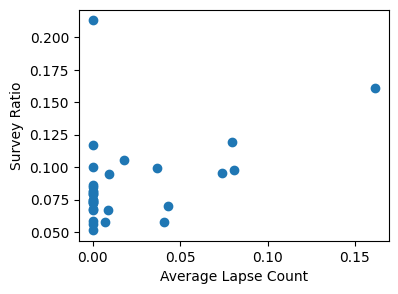

Average Survey Ratio: 0.08719816664707696
AUC = 0.91
-----------------------------------------------
torch.Size([29711, 173]) torch.Size([7505, 173])
821 2594 7505
XgBoost: AUC = 0.85
torch.Size([29711, 173])
tensor(0.3109, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.85
---------------------------------------------------
Device set to : cuda:1
tensor(0.2113, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1846, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2203, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2040, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1724, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1714, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2046, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2189, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1422, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1592, device='cuda:1', grad_fn=<MeanBackward0>)


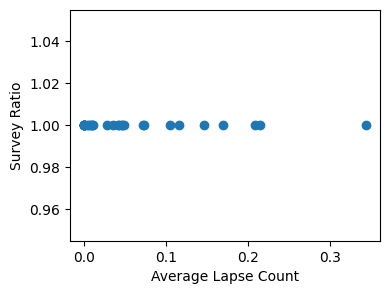

Average Survey Ratio: 1.0
AUC = 0.84
tensor(0.1729, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1571, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1676, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1337, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1555, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1564, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1432, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1614, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1946, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1799, device='cuda:1', grad_fn=<MeanBackward0>)


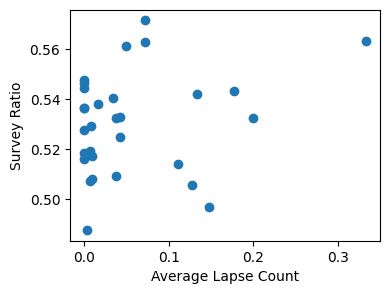

Average Survey Ratio: 0.5304637182195882
AUC = 0.84
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1757, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1672, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2046, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1687, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1378, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1672, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2021, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1696, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1634, device='cuda:1', grad_fn=<MeanBackward0>)


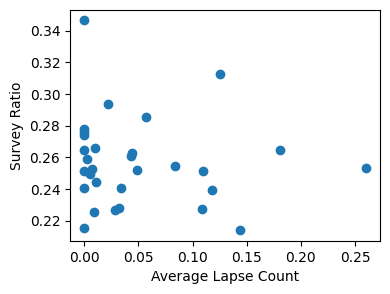

Average Survey Ratio: 0.25705945989440576
AUC = 0.84
tensor(0.1340, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1529, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1457, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2107, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1883, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1695, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1593, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1809, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1725, device='cuda:1', grad_fn=<MeanBackward0>)


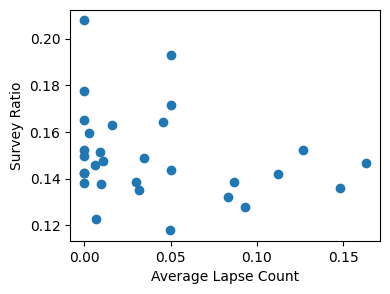

Average Survey Ratio: 0.14972014172885728
AUC = 0.82
tensor(0.1904, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1829, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1875, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1762, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1665, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1864, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1926, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1657, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1480, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1603, device='cuda:1', grad_fn=<MeanBackward0>)


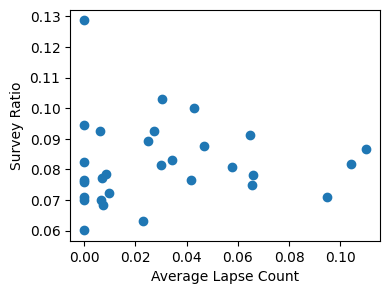

Average Survey Ratio: 0.08194006357610555
AUC = 0.83
-----------------------------------------------
torch.Size([30080, 173]) torch.Size([7136, 173])
699 1787 7136
XgBoost: AUC = 0.89
torch.Size([30080, 173])
tensor(0.1807, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.1942, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2173, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1737, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1804, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2008, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1479, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1720, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1914, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1942, device='cuda:1', grad_fn=<MeanBackward0>)


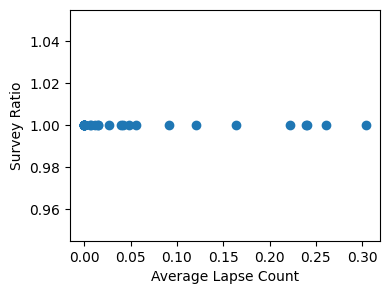

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.1405, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1831, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1856, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1375, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1878, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1739, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1991, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1575, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2008, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1726, device='cuda:1', grad_fn=<MeanBackward0>)


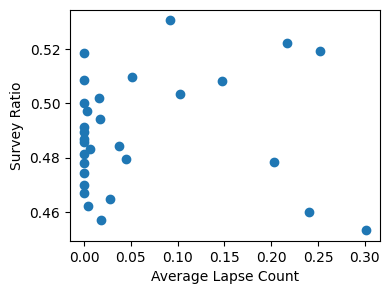

Average Survey Ratio: 0.4886453878576121
AUC = 0.88
tensor(0.1744, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1641, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1470, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2304, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1504, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2024, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1599, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1771, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2016, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1992, device='cuda:1', grad_fn=<MeanBackward0>)


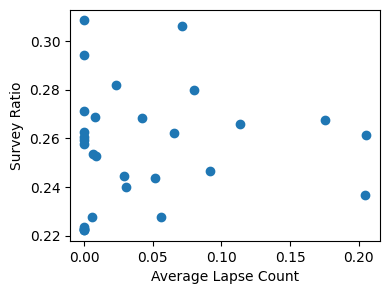

Average Survey Ratio: 0.2554372877489351
AUC = 0.87
tensor(0.1959, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1852, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1990, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1742, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1936, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1803, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1581, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1804, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1725, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1612, device='cuda:1', grad_fn=<MeanBackward0>)


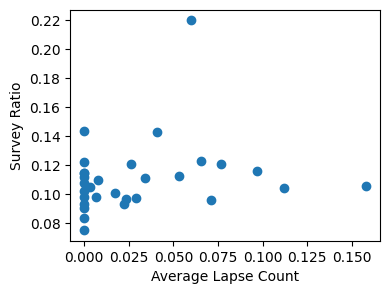

Average Survey Ratio: 0.11093295264242833
AUC = 0.86
tensor(0.2525, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1834, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2039, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1682, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2063, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2188, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2295, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1693, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2174, device='cuda:1', grad_fn=<MeanBackward0>)


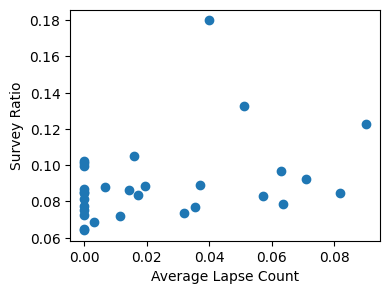

Average Survey Ratio: 0.08993369442789141
AUC = 0.84
-----------------------------------------------
torch.Size([29426, 173]) torch.Size([7790, 173])
747 2112 7790
XgBoost: AUC = 0.87
torch.Size([29426, 173])
tensor(0.1510, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.1998, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2169, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1706, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2083, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1474, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1527, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1651, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1624, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1842, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1487, device='cuda:1', grad_fn=<MeanBackward0>)


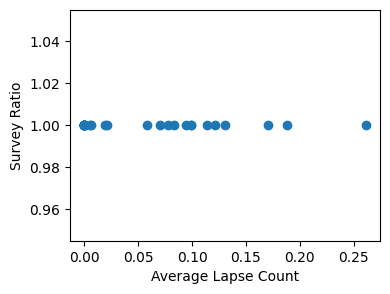

Average Survey Ratio: 1.0
AUC = 0.89
tensor(0.1673, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1870, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1643, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1597, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1210, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1568, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1742, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2201, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1698, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1833, device='cuda:1', grad_fn=<MeanBackward0>)


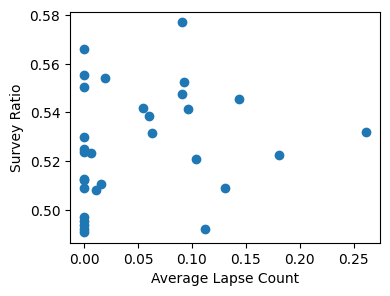

Average Survey Ratio: 0.5258777352142799
AUC = 0.87
tensor(0.2177, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1576, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1801, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1545, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1784, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1366, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1620, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1604, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1590, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1488, device='cuda:1', grad_fn=<MeanBackward0>)


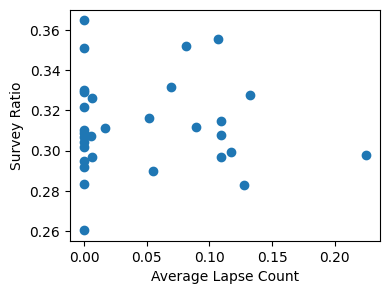

Average Survey Ratio: 0.3124326738901265
AUC = 0.86
tensor(0.1730, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1699, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1613, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1543, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1724, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1523, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1827, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1964, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1736, device='cuda:1', grad_fn=<MeanBackward0>)


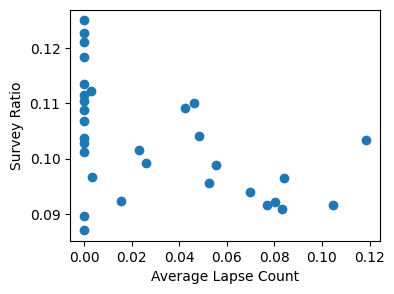

Average Survey Ratio: 0.10332342944060018
AUC = 0.84
tensor(0.1693, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1604, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1807, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1438, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2065, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2132, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1566, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1814, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1965, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1460, device='cuda:1', grad_fn=<MeanBackward0>)


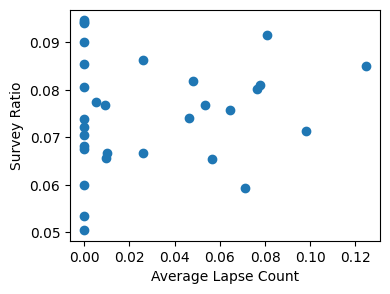

Average Survey Ratio: 0.07540589608859086
AUC = 0.83
-----------------------------------------------
{'xg': [0.8971801017459317, 0.9087585965312114, 0.8509516244366353, 0.8874560141954717, 0.8742809754803206], 1: [0.8996492749054226, 0.9105450782858499, 0.8444457322046722, 0.8790591232776, 0.8879839486679741], 2: [0.8814642068996577, 0.8988806308730214, 0.8353319432812082, 0.8759223045061155, 0.8708218267551724], 4: [0.8639829582132349, 0.9013221617994316, 0.8360640531937304, 0.8689592513595512, 0.8615154450924052], 10: [0.8502332068546208, 0.9065235160014884, 0.8223412975229081, 0.8626609442060086, 0.8444659417641222], 20: [0.8713330086921275, 0.907080087982336, 0.8346734543779353, 0.8365753868850572, 0.8323968409013972]}
torch.Size([30175, 173]) torch.Size([7041, 173])
467 1586 7041
XgBoost: AUC = 0.85
torch.Size([30175, 173])
tensor(0.1965, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.85
---------------------------------------------------
Device set to : cuda:1
tensor(0.2438, device='cud

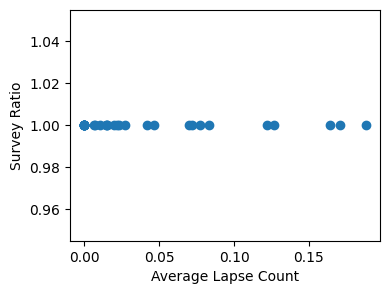

Average Survey Ratio: 1.0
AUC = 0.85
tensor(0.1455, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1450, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1462, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1539, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1591, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1398, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1323, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1814, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1852, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1837, device='cuda:1', grad_fn=<MeanBackward0>)


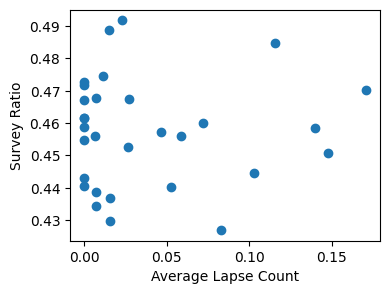

Average Survey Ratio: 0.4572931415428546
AUC = 0.82
tensor(0.1781, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2185, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1317, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1957, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1836, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1953, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1567, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1705, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1592, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1734, device='cuda:1', grad_fn=<MeanBackward0>)


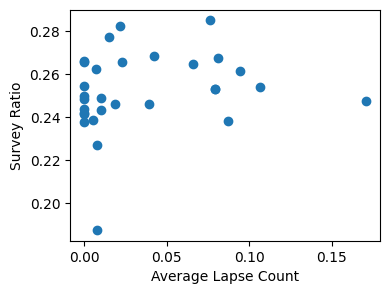

Average Survey Ratio: 0.2523050591360519
AUC = 0.80
tensor(0.2010, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1667, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2006, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1813, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2295, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1761, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1637, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1382, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1896, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1456, device='cuda:1', grad_fn=<MeanBackward0>)


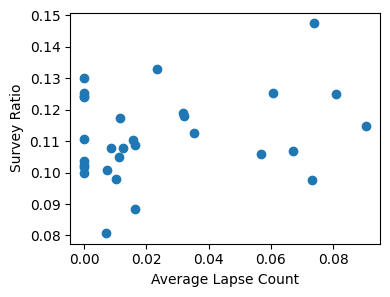

Average Survey Ratio: 0.11177721627389109
AUC = 0.76
tensor(0.2155, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1838, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1962, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2095, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2322, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2114, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1730, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1651, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1868, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1697, device='cuda:1', grad_fn=<MeanBackward0>)


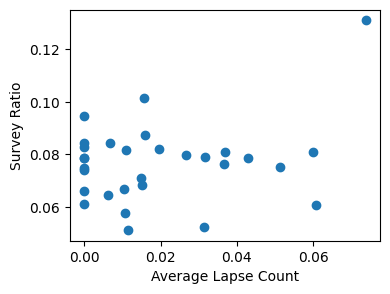

Average Survey Ratio: 0.07686843122053436
AUC = 0.75
-----------------------------------------------
torch.Size([30006, 173]) torch.Size([7210, 173])
712 1849 7210
XgBoost: AUC = 0.90
torch.Size([30006, 173])
tensor(0.1720, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.1921, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2131, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1874, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1932, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1735, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1306, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1443, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1490, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1842, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1988, device='cuda:1', grad_fn=<MeanBackward0>)


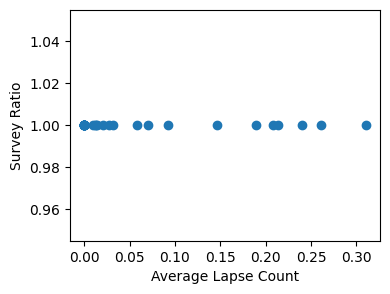

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1913, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1126, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1541, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1609, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1592, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1412, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1366, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1332, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1472, device='cuda:1', grad_fn=<MeanBackward0>)


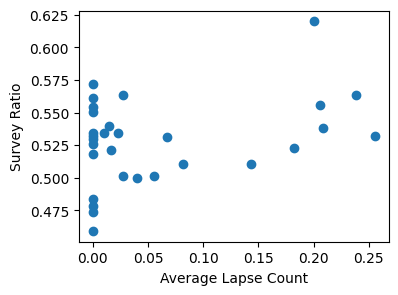

Average Survey Ratio: 0.5284546934975137
AUC = 0.89
tensor(0.1699, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1544, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1711, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1756, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1496, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2036, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1771, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1890, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1492, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)


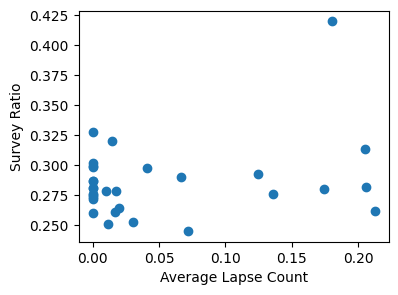

Average Survey Ratio: 0.28605799156816697
AUC = 0.87
tensor(0.2107, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1761, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1839, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1837, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1841, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2153, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2286, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1602, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1664, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1873, device='cuda:1', grad_fn=<MeanBackward0>)


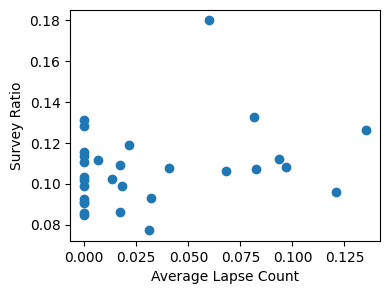

Average Survey Ratio: 0.10733523992785804
AUC = 0.87
tensor(0.1636, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1881, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1842, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1653, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1921, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1684, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2259, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1906, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1534, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1992, device='cuda:1', grad_fn=<MeanBackward0>)


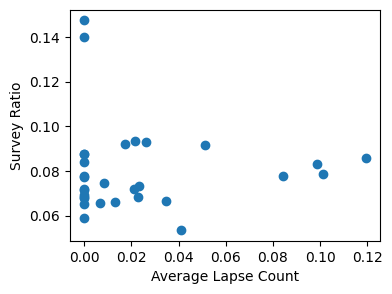

Average Survey Ratio: 0.08037651640150562
AUC = 0.86
-----------------------------------------------
torch.Size([29969, 173]) torch.Size([7247, 173])
708 2196 7247
XgBoost: AUC = 0.89
torch.Size([29969, 173])
tensor(0.1435, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.88
---------------------------------------------------
Device set to : cuda:1
tensor(0.2254, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1707, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1606, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1881, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1478, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1348, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1867, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1901, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1803, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1617, device='cuda:1', grad_fn=<MeanBackward0>)


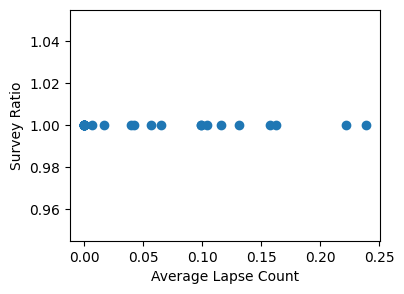

Average Survey Ratio: 1.0
AUC = 0.89
tensor(0.1863, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1659, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1707, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1371, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1870, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1205, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1737, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1777, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1360, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1753, device='cuda:1', grad_fn=<MeanBackward0>)


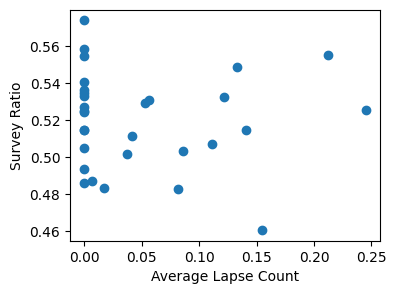

Average Survey Ratio: 0.5199511808628845
AUC = 0.87
tensor(0.1697, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1702, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1587, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1722, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1744, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2066, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1792, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1780, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1300, device='cuda:1', grad_fn=<MeanBackward0>)


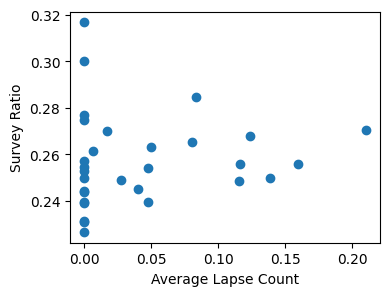

Average Survey Ratio: 0.2574091781150079
AUC = 0.86
tensor(0.2089, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1985, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2213, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2200, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1703, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2182, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2009, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1998, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1976, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2296, device='cuda:1', grad_fn=<MeanBackward0>)


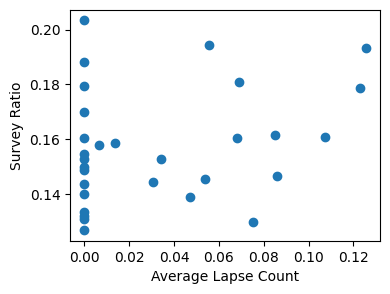

Average Survey Ratio: 0.15734252118012104
AUC = 0.84
tensor(0.1827, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1729, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1831, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2619, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1734, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2119, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2198, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1763, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2042, device='cuda:1', grad_fn=<MeanBackward0>)


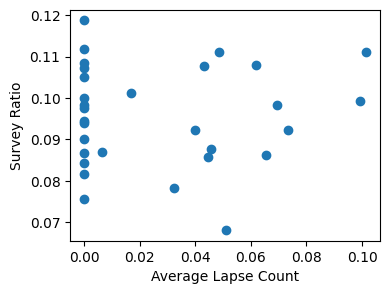

Average Survey Ratio: 0.09563066873167846
AUC = 0.84
-----------------------------------------------
torch.Size([28819, 173]) torch.Size([8397, 173])
544 1523 8397
XgBoost: AUC = 0.88
torch.Size([28819, 173])
tensor(0.1618, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.84
---------------------------------------------------
Device set to : cuda:1
tensor(0.2258, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2180, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2143, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1904, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1755, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1724, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2365, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2078, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1577, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2483, device='cuda:1', grad_fn=<MeanBackward0>)


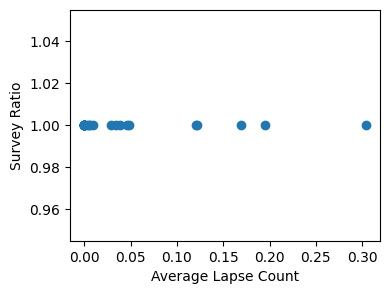

Average Survey Ratio: 1.0
AUC = 0.84
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1590, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1718, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1616, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1960, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2174, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2026, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2175, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1863, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1953, device='cuda:1', grad_fn=<MeanBackward0>)


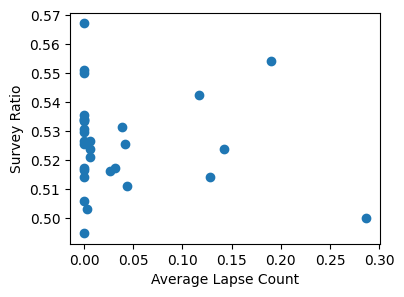

Average Survey Ratio: 0.5258418179710378
AUC = 0.84
tensor(0.1748, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1583, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1423, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1751, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2002, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1735, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1675, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2017, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1860, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)


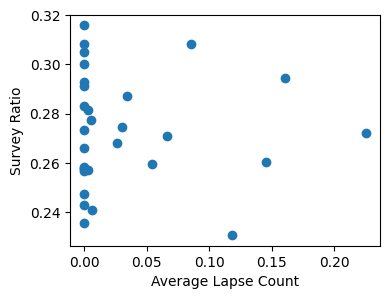

Average Survey Ratio: 0.2725035886907714
AUC = 0.83
tensor(0.1825, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2072, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1872, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2113, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1808, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1759, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1584, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2238, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1980, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2325, device='cuda:1', grad_fn=<MeanBackward0>)


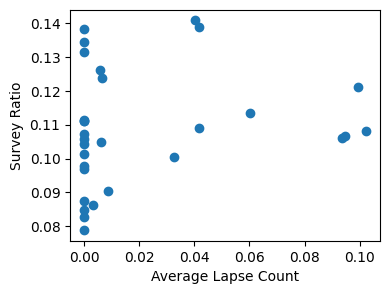

Average Survey Ratio: 0.10870942495219611
AUC = 0.83
tensor(0.1833, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1847, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1813, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1775, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2426, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2033, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2074, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1956, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2143, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1446, device='cuda:1', grad_fn=<MeanBackward0>)


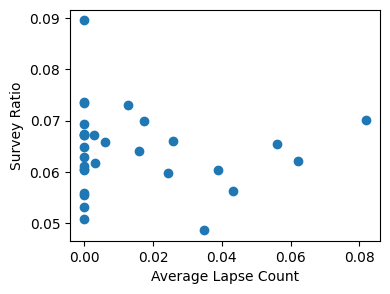

Average Survey Ratio: 0.06413142358601105
AUC = 0.85
-----------------------------------------------
torch.Size([29895, 173]) torch.Size([7321, 173])
871 1732 7321
XgBoost: AUC = 0.92
torch.Size([29895, 173])
tensor(0.1986, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.92
---------------------------------------------------
Device set to : cuda:1
tensor(0.2193, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1875, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1630, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1891, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2044, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1575, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1804, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1786, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1859, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1864, device='cuda:1', grad_fn=<MeanBackward0>)


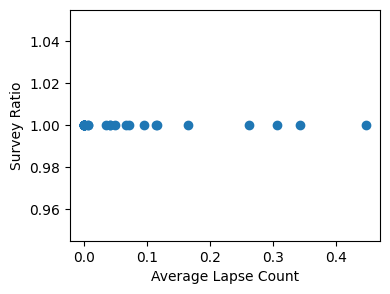

Average Survey Ratio: 1.0
AUC = 0.92
tensor(0.1650, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1393, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1589, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1925, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2380, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1480, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1986, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1916, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1760, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1536, device='cuda:1', grad_fn=<MeanBackward0>)


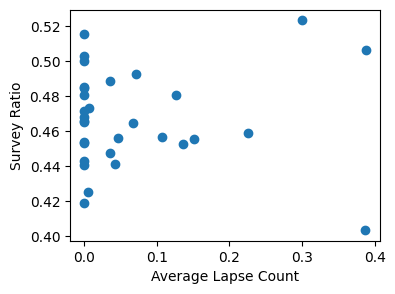

Average Survey Ratio: 0.4668578546485802
AUC = 0.91
tensor(0.1357, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1975, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1627, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1634, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1579, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1716, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1634, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1980, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1434, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1842, device='cuda:1', grad_fn=<MeanBackward0>)


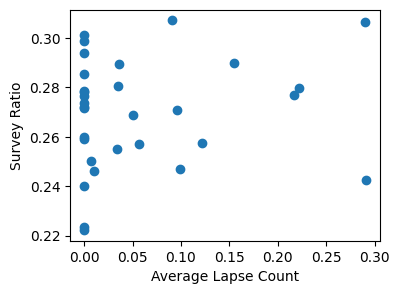

Average Survey Ratio: 0.2696317343697359
AUC = 0.90
tensor(0.2041, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1848, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1914, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1658, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1401, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1831, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1761, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1692, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2166, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1636, device='cuda:1', grad_fn=<MeanBackward0>)


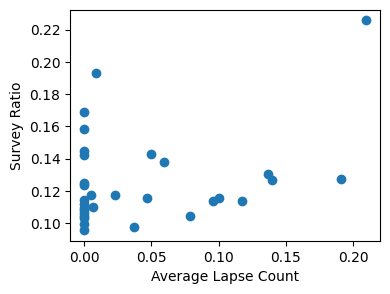

Average Survey Ratio: 0.1259576836039196
AUC = 0.89
tensor(0.1677, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1779, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2219, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1786, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2036, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2234, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1785, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2037, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2323, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1690, device='cuda:1', grad_fn=<MeanBackward0>)


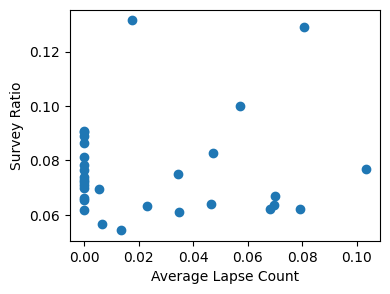

Average Survey Ratio: 0.07626517460288193
AUC = 0.87
-----------------------------------------------
{'xg': [0.8453916831538688, 0.9022584952673424, 0.8851044104775951, 0.8778750955049026, 0.9152229015922178], 1: [0.850162439927845, 0.8978437833940263, 0.8861189663410239, 0.8366997250956921, 0.9167546880979717], 2: [0.8222118279198634, 0.886027377481749, 0.8748201793152428, 0.835251234073153, 0.9087555069019838], 4: [0.8034437785865934, 0.8679143063898659, 0.8556320702469236, 0.8273198796263698, 0.8991536058526688], 10: [0.7615266551967422, 0.8722727131252139, 0.8369155989746009, 0.8297730447712002, 0.8935402593472708], 20: [0.7464919229538985, 0.8587403513959352, 0.8415467646100796, 0.8503008638512071, 0.8735420393559928]}
torch.Size([30059, 173]) torch.Size([7157, 173])
668 1628 7157
XgBoost: AUC = 0.88
torch.Size([30059, 173])
tensor(0.2131, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.87
---------------------------------------------------
Device set to : cuda:1
tensor(0.1878, device='cu

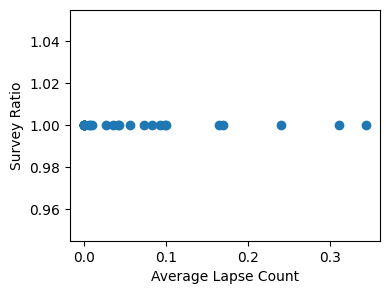

Average Survey Ratio: 1.0
AUC = 0.87
tensor(0.1909, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2101, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1758, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1485, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1554, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2052, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1740, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1538, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1616, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1923, device='cuda:1', grad_fn=<MeanBackward0>)


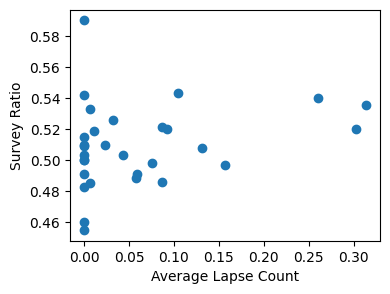

Average Survey Ratio: 0.5094680446910681
AUC = 0.86
tensor(0.1741, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2132, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1727, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1372, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1735, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1831, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1864, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1769, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1757, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1957, device='cuda:1', grad_fn=<MeanBackward0>)


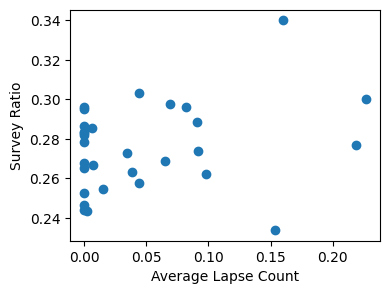

Average Survey Ratio: 0.2754958440910563
AUC = 0.85
tensor(0.2074, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1917, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1723, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2051, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1749, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1731, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2007, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1543, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1658, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2153, device='cuda:1', grad_fn=<MeanBackward0>)


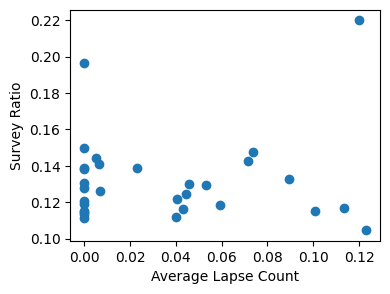

Average Survey Ratio: 0.1319868758906569
AUC = 0.82
tensor(0.2167, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1796, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1501, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1656, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1873, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2122, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1585, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1846, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1950, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2561, device='cuda:1', grad_fn=<MeanBackward0>)


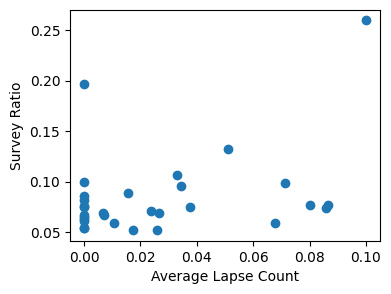

Average Survey Ratio: 0.08522505890554287
AUC = 0.84
-----------------------------------------------
torch.Size([29560, 173]) torch.Size([7656, 173])
676 1897 7656
XgBoost: AUC = 0.89
torch.Size([29560, 173])
tensor(0.1555, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2238, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1953, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2043, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1728, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1866, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2177, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1805, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2022, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1815, device='cuda:1', grad_fn=<MeanBackward0>)


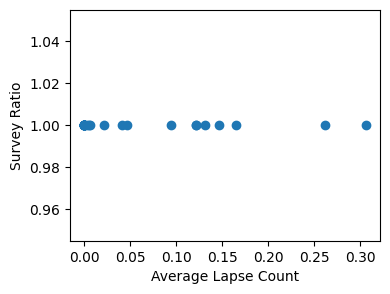

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.2102, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2067, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2080, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1506, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1791, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2039, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1868, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2039, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1466, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1749, device='cuda:1', grad_fn=<MeanBackward0>)


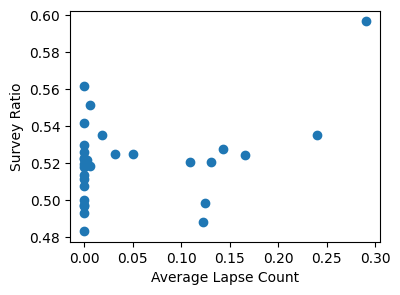

Average Survey Ratio: 0.5210143961579065
AUC = 0.88
tensor(0.2167, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1744, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2029, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1813, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1730, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1704, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1904, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1440, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1800, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1947, device='cuda:1', grad_fn=<MeanBackward0>)


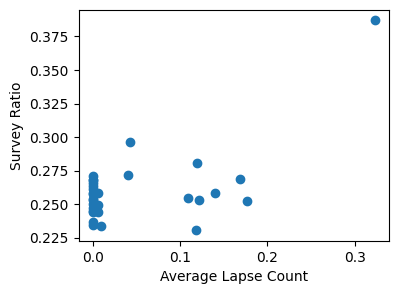

Average Survey Ratio: 0.26053918876879556
AUC = 0.88
tensor(0.2177, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2076, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1923, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2200, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2102, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2219, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1770, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2118, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1994, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1429, device='cuda:1', grad_fn=<MeanBackward0>)


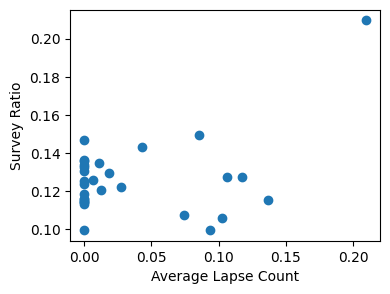

Average Survey Ratio: 0.12626633798284922
AUC = 0.87
tensor(0.2046, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2136, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2369, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1924, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2479, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1908, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1964, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2044, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2367, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1932, device='cuda:1', grad_fn=<MeanBackward0>)


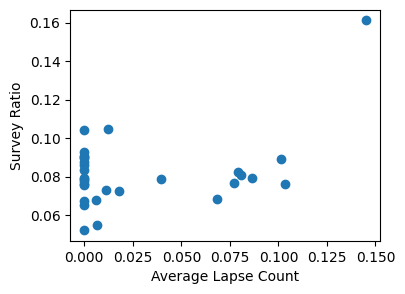

Average Survey Ratio: 0.08206516453694027
AUC = 0.88
-----------------------------------------------
torch.Size([29587, 173]) torch.Size([7629, 173])
530 1492 7629
XgBoost: AUC = 0.93
torch.Size([29587, 173])
tensor(0.1703, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.94
---------------------------------------------------
Device set to : cuda:1
tensor(0.2431, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2234, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2187, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1942, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1978, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2111, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1648, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1937, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1580, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2058, device='cuda:1', grad_fn=<MeanBackward0>)


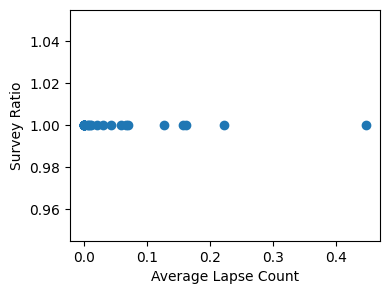

Average Survey Ratio: 1.0
AUC = 0.93
tensor(0.1485, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1900, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2050, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2047, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1795, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1854, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2122, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1998, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2055, device='cuda:1', grad_fn=<MeanBackward0>)


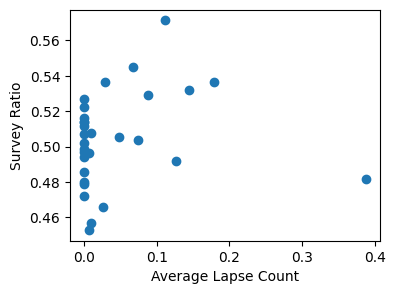

Average Survey Ratio: 0.5043971126750602
AUC = 0.92
tensor(0.1654, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1845, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1954, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1800, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1978, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2002, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1654, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1932, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1595, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1810, device='cuda:1', grad_fn=<MeanBackward0>)


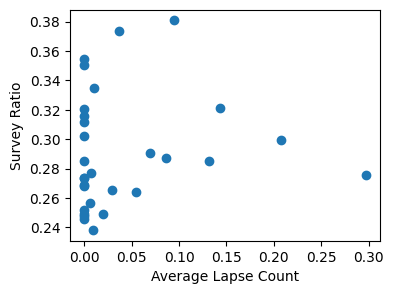

Average Survey Ratio: 0.2906379319260208
AUC = 0.92
tensor(0.2728, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2176, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1921, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2243, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1911, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1559, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2103, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1810, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2247, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2119, device='cuda:1', grad_fn=<MeanBackward0>)


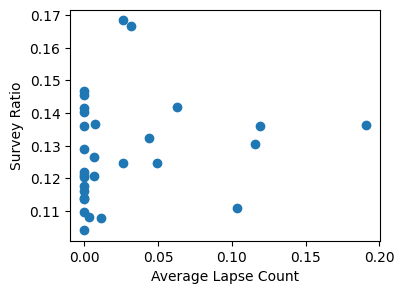

Average Survey Ratio: 0.1283602532540235
AUC = 0.92
tensor(0.2154, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2124, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2385, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1987, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2079, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2241, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2593, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2245, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1770, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2106, device='cuda:1', grad_fn=<MeanBackward0>)


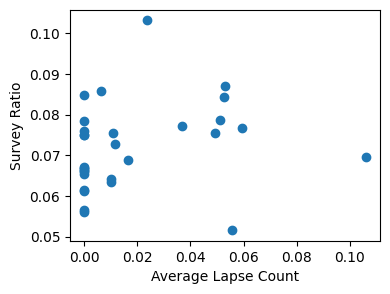

Average Survey Ratio: 0.07187903055033334
AUC = 0.90
-----------------------------------------------
torch.Size([29623, 173]) torch.Size([7593, 173])
979 2278 7593
XgBoost: AUC = 0.87
torch.Size([29623, 173])
tensor(0.1348, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.86
---------------------------------------------------
Device set to : cuda:1
tensor(0.2060, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2269, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1710, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1597, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1665, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1657, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1276, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1311, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1475, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1359, device='cuda:1', grad_fn=<MeanBackward0>)


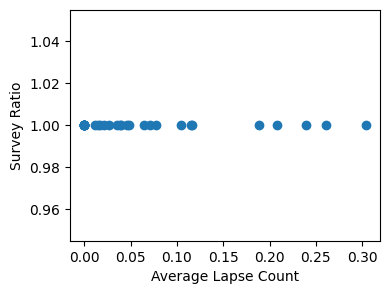

Average Survey Ratio: 1.0
AUC = 0.85
tensor(0.1474, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1681, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1202, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1585, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1856, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1424, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1494, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1546, device='cuda:1', grad_fn=<MeanBackward0>)


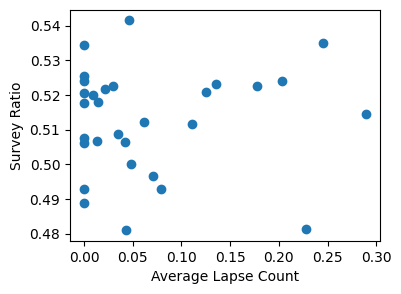

Average Survey Ratio: 0.5126387487069057
AUC = 0.84
tensor(0.1702, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1616, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1895, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1435, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1631, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1785, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1341, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1500, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1759, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1664, device='cuda:1', grad_fn=<MeanBackward0>)


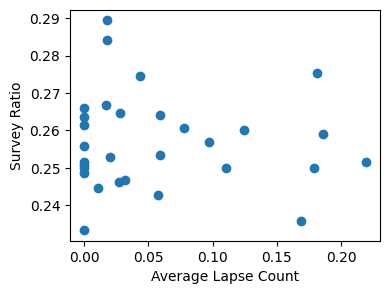

Average Survey Ratio: 0.2570242522466841
AUC = 0.84
tensor(0.1301, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1474, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1437, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1526, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1415, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1625, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1027, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1606, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1515, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1688, device='cuda:1', grad_fn=<MeanBackward0>)


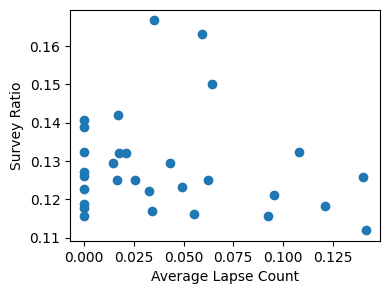

Average Survey Ratio: 0.1287959608439197
AUC = 0.82
tensor(0.1700, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1691, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1517, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1955, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1585, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1836, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1871, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1534, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2012, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1793, device='cuda:1', grad_fn=<MeanBackward0>)


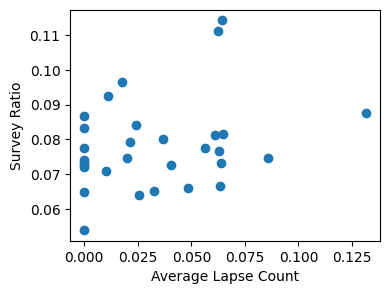

Average Survey Ratio: 0.07828450579244793
AUC = 0.80
-----------------------------------------------
torch.Size([30035, 173]) torch.Size([7181, 173])
449 1413 7181
XgBoost: AUC = 0.88
torch.Size([30035, 173])
tensor(0.1501, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.88
---------------------------------------------------
Device set to : cuda:1
tensor(0.2538, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2191, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2340, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1742, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1966, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1425, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1766, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1850, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1577, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1712, device='cuda:1', grad_fn=<MeanBackward0>)


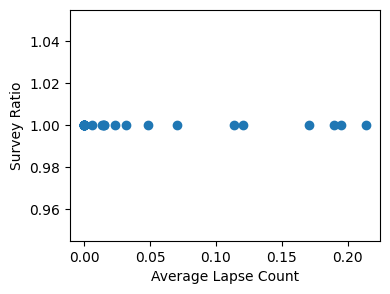

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.1875, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1566, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1598, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1342, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1626, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1843, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2084, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2014, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1647, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2206, device='cuda:1', grad_fn=<MeanBackward0>)


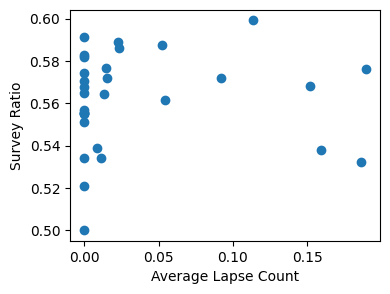

Average Survey Ratio: 0.5617148621661089
AUC = 0.87
tensor(0.1719, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1651, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1774, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1553, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1587, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1598, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2116, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1644, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1799, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1812, device='cuda:1', grad_fn=<MeanBackward0>)


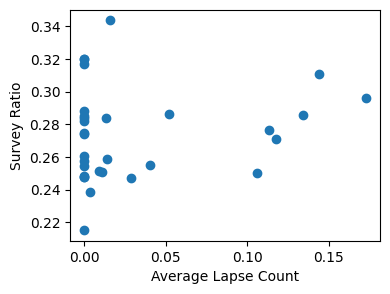

Average Survey Ratio: 0.27363203175905165
AUC = 0.86
tensor(0.1843, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1847, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1891, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1822, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1535, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1806, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1811, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2151, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1865, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2389, device='cuda:1', grad_fn=<MeanBackward0>)


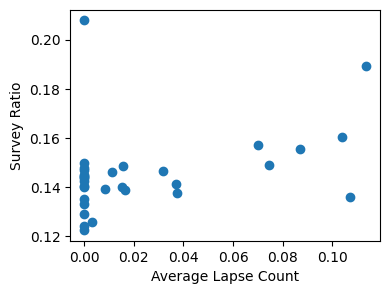

Average Survey Ratio: 0.14536599565193242
AUC = 0.87
tensor(0.1965, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1956, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2469, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2206, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1757, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1924, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1769, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1885, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1754, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2056, device='cuda:1', grad_fn=<MeanBackward0>)


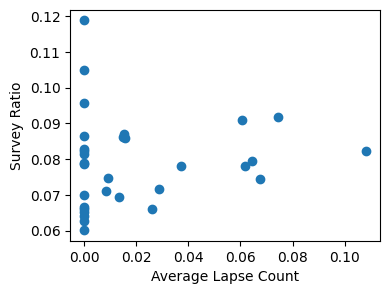

Average Survey Ratio: 0.07910062778368462
AUC = 0.86
-----------------------------------------------
{'xg': [0.8845715872923595, 0.8946144733049626, 0.9275429438640039, 0.8676931312012499, 0.8823013311418918], 1: [0.8684231167807704, 0.8954657008189078, 0.934429776184262, 0.8547169729731066, 0.8763529438231391], 2: [0.8637719936917657, 0.8819797901018972, 0.9236966673488426, 0.8418473767070377, 0.8735302719319489], 4: [0.8505187959725486, 0.8820781268544109, 0.9243510247257787, 0.8355977492878108, 0.8609273330713131], 10: [0.8169406679013678, 0.8710409920143776, 0.9218732641057603, 0.8165626168899783, 0.8736849366189076], 20: [0.8403491214519643, 0.8821124599447279, 0.9011285139815068, 0.8003450445444444, 0.8647071064370947]}
torch.Size([29378, 173]) torch.Size([7838, 173])
686 1638 7838
XgBoost: AUC = 0.92
torch.Size([29378, 173])
tensor(0.1613, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.93
---------------------------------------------------
Device set to : cuda:1
tensor(0.2376, device='

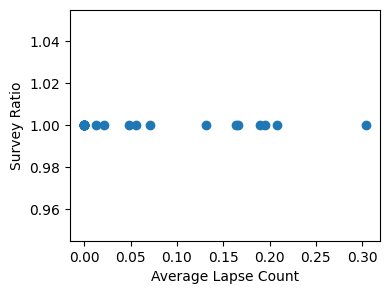

Average Survey Ratio: 1.0
AUC = 0.92
tensor(0.1655, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1641, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1832, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1691, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1607, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1514, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1578, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1847, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1565, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1763, device='cuda:1', grad_fn=<MeanBackward0>)


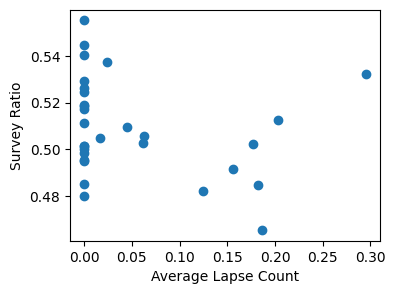

Average Survey Ratio: 0.5092090573394453
AUC = 0.91
tensor(0.1796, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1760, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2376, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1664, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1700, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1805, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1830, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1544, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2215, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1900, device='cuda:1', grad_fn=<MeanBackward0>)


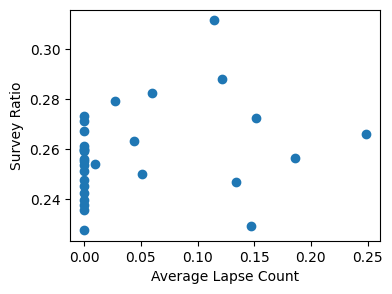

Average Survey Ratio: 0.2581345723774363
AUC = 0.90
tensor(0.1798, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2016, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1671, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1919, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2144, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1770, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2082, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1928, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2100, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2086, device='cuda:1', grad_fn=<MeanBackward0>)


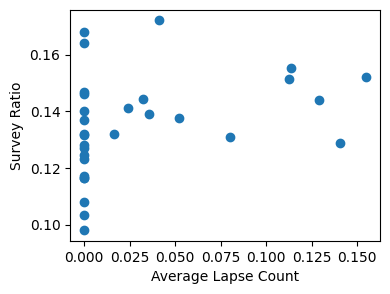

Average Survey Ratio: 0.13522549579813897
AUC = 0.88
tensor(0.2025, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2221, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1850, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1915, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2047, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1952, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2127, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2160, device='cuda:1', grad_fn=<MeanBackward0>)


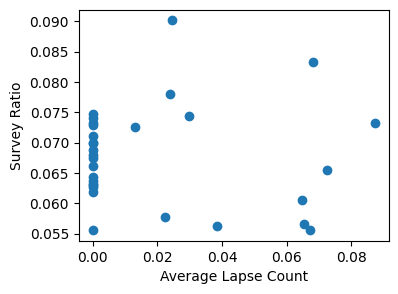

Average Survey Ratio: 0.06781167299265592
AUC = 0.88
-----------------------------------------------
torch.Size([29623, 173]) torch.Size([7593, 173])
569 1373 7593
XgBoost: AUC = 0.87
torch.Size([29623, 173])
tensor(0.1687, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.86
---------------------------------------------------
Device set to : cuda:1
tensor(0.2907, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1706, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2476, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2477, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2020, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2073, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2023, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2143, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1925, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2007, device='cuda:1', grad_fn=<MeanBackward0>)


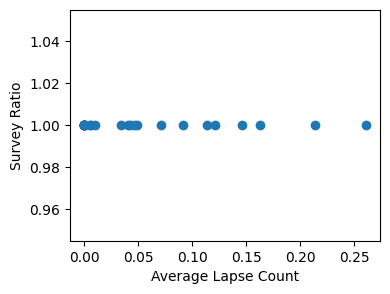

Average Survey Ratio: 1.0
AUC = 0.87
tensor(0.1846, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1638, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1631, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1910, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1510, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1786, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1534, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1856, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1993, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1657, device='cuda:1', grad_fn=<MeanBackward0>)


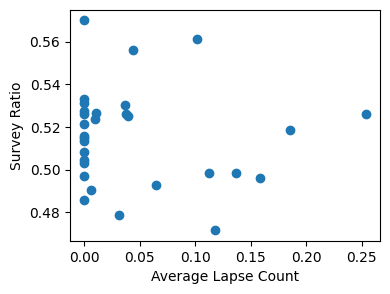

Average Survey Ratio: 0.5157362013122981
AUC = 0.85
tensor(0.1729, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1682, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1731, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1635, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1460, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1778, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2037, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1911, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1896, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2255, device='cuda:1', grad_fn=<MeanBackward0>)


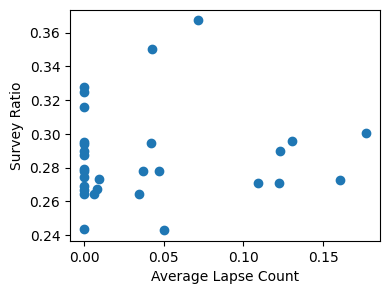

Average Survey Ratio: 0.2863397436746979
AUC = 0.86
tensor(0.2000, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1825, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1805, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1766, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1713, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1639, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2023, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2125, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1867, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1915, device='cuda:1', grad_fn=<MeanBackward0>)


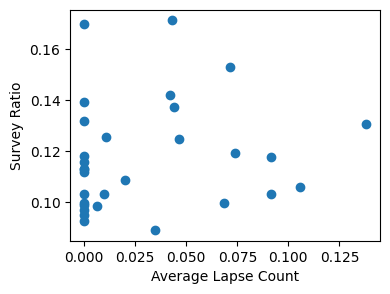

Average Survey Ratio: 0.1176962005763627
AUC = 0.85
tensor(0.1920, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2082, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2114, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1774, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1806, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1652, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2139, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1726, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2129, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1664, device='cuda:1', grad_fn=<MeanBackward0>)


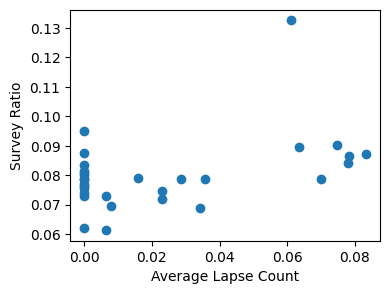

Average Survey Ratio: 0.08025800962354723
AUC = 0.84
-----------------------------------------------
torch.Size([29961, 173]) torch.Size([7255, 173])
683 1741 7255
XgBoost: AUC = 0.91
torch.Size([29961, 173])
tensor(0.1689, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.2135, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1815, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1520, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1689, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1539, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1671, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1602, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1559, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1401, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1554, device='cuda:1', grad_fn=<MeanBackward0>)


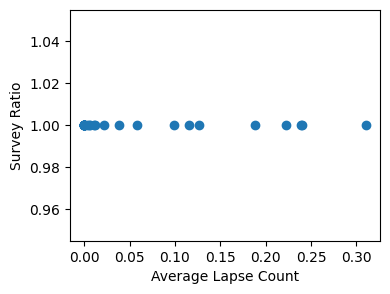

Average Survey Ratio: 1.0
AUC = 0.89
tensor(0.1721, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1598, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1995, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1882, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1898, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1480, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1791, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1963, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1740, device='cuda:1', grad_fn=<MeanBackward0>)


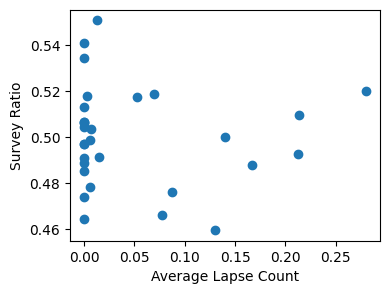

Average Survey Ratio: 0.49994187271081736
AUC = 0.87
tensor(0.2083, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1632, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1645, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1343, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1377, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1666, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1915, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1905, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1853, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1854, device='cuda:1', grad_fn=<MeanBackward0>)


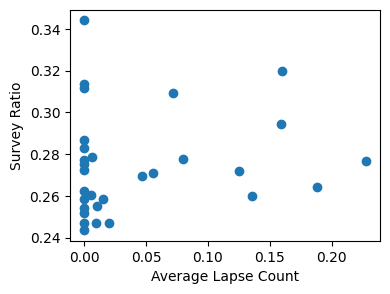

Average Survey Ratio: 0.2747600302411191
AUC = 0.87
tensor(0.2204, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1479, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1674, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2085, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2002, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1797, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2012, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1761, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1885, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2190, device='cuda:1', grad_fn=<MeanBackward0>)


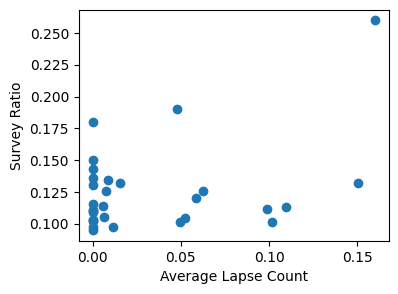

Average Survey Ratio: 0.12515877414553656
AUC = 0.85
tensor(0.1869, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1890, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1965, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1844, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2008, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1533, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2206, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2039, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1890, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1885, device='cuda:1', grad_fn=<MeanBackward0>)


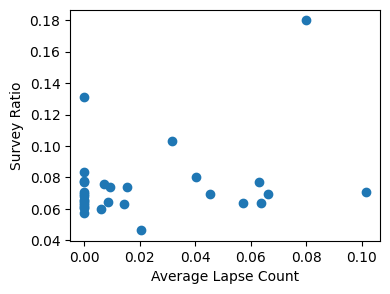

Average Survey Ratio: 0.07494569036823519
AUC = 0.87
-----------------------------------------------
torch.Size([29890, 173]) torch.Size([7326, 173])
576 2202 7326
XgBoost: AUC = 0.87
torch.Size([29890, 173])
tensor(0.1599, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.85
---------------------------------------------------
Device set to : cuda:1
tensor(0.2358, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2119, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2017, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2061, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1772, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1870, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2077, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1824, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2042, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1647, device='cuda:1', grad_fn=<MeanBackward0>)


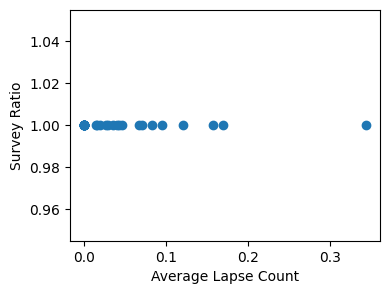

Average Survey Ratio: 1.0
AUC = 0.86
tensor(0.1528, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1513, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1702, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2431, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1708, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2054, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2049, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1563, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1677, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1984, device='cuda:1', grad_fn=<MeanBackward0>)


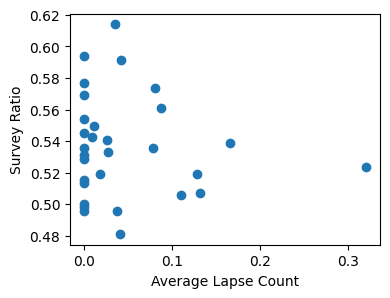

Average Survey Ratio: 0.5362357985792617
AUC = 0.84
tensor(0.1647, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1964, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1644, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1932, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1977, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1626, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1521, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1502, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1847, device='cuda:1', grad_fn=<MeanBackward0>)


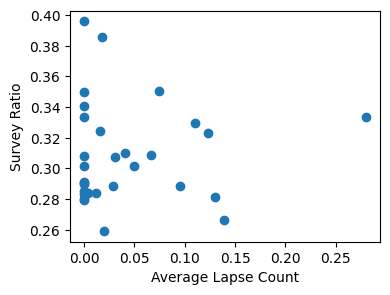

Average Survey Ratio: 0.30851906361877607
AUC = 0.84
tensor(0.2077, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1634, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1724, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1912, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1693, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1823, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1912, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1867, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1971, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1753, device='cuda:1', grad_fn=<MeanBackward0>)


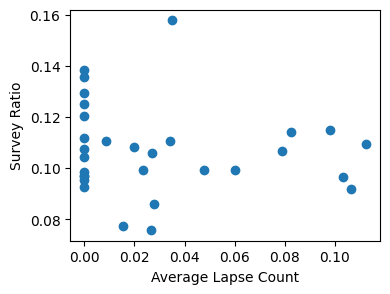

Average Survey Ratio: 0.10724279879367755
AUC = 0.85
tensor(0.2323, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2073, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2044, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2394, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2060, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2010, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2072, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2020, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1697, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1978, device='cuda:1', grad_fn=<MeanBackward0>)


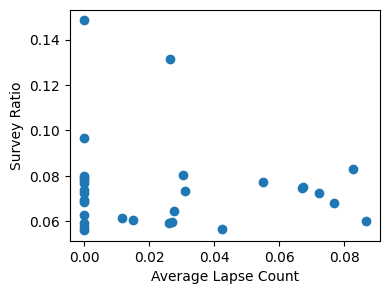

Average Survey Ratio: 0.07452075911508568
AUC = 0.85
-----------------------------------------------
torch.Size([30012, 173]) torch.Size([7204, 173])
788 1833 7204
XgBoost: AUC = 0.90
torch.Size([30012, 173])
tensor(0.1818, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.89
---------------------------------------------------
Device set to : cuda:1
tensor(0.2295, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2624, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1800, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2063, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2232, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1764, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2078, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1979, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1504, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1553, device='cuda:1', grad_fn=<MeanBackward0>)


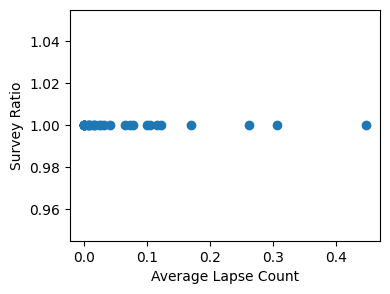

Average Survey Ratio: 1.0
AUC = 0.88
tensor(0.1548, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1912, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1694, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1726, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1859, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1797, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1948, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1717, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1666, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1812, device='cuda:1', grad_fn=<MeanBackward0>)


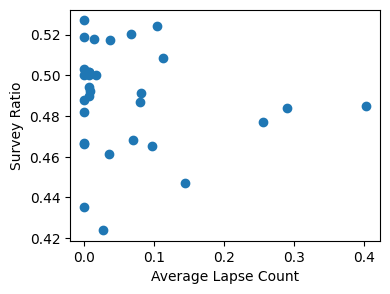

Average Survey Ratio: 0.48857126243017573
AUC = 0.87
tensor(0.1783, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1690, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2012, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1599, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1973, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1952, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1617, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1649, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1587, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1796, device='cuda:1', grad_fn=<MeanBackward0>)


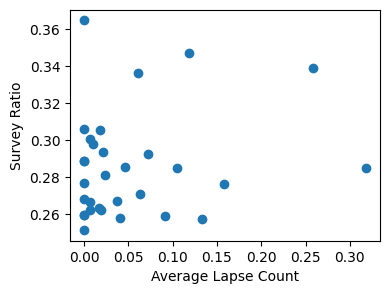

Average Survey Ratio: 0.2857560635103256
AUC = 0.86
tensor(0.2026, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1736, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1659, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1772, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1772, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1801, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1642, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1740, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1807, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1615, device='cuda:1', grad_fn=<MeanBackward0>)


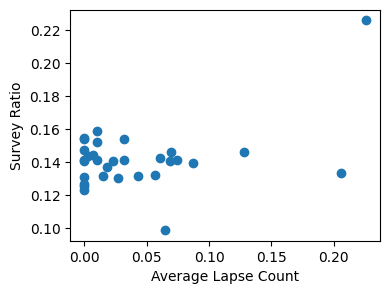

Average Survey Ratio: 0.14160835844198683
AUC = 0.86
tensor(0.2049, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1855, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1783, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2311, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1727, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1916, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1465, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2467, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2398, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2062, device='cuda:1', grad_fn=<MeanBackward0>)


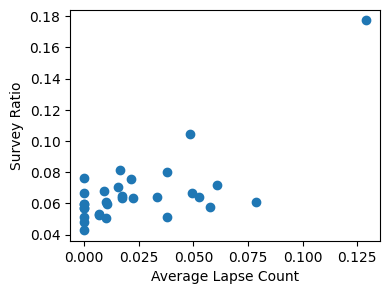

Average Survey Ratio: 0.06711861457513754
AUC = 0.82
-----------------------------------------------
{'xg': [0.9152475647497734, 0.8713775966708168, 0.9091170759484535, 0.8719126800411523, 0.8974647573642037], 1: [0.9216755614038521, 0.8673173272856107, 0.892991385433032, 0.8578984053497943, 0.8841819151360178], 2: [0.9092135535901801, 0.8471739874535111, 0.8749737116245413, 0.8385552983539095, 0.8709949032874665], 4: [0.9008524191076239, 0.8571448230720883, 0.8687656449251406, 0.8427971965020576, 0.8614705107472436], 10: [0.8843239836682515, 0.8540072000192159, 0.8515830726031463, 0.8467004886831276, 0.8601931679367572], 20: [0.8772986903294395, 0.8435933690565312, 0.8689121246443271, 0.8478284465020576, 0.8213546677405471]}
torch.Size([29739, 173]) torch.Size([7477, 173])
1069 1891 7477
XgBoost: AUC = 0.89
torch.Size([29739, 173])
tensor(0.0564, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.1973, device=

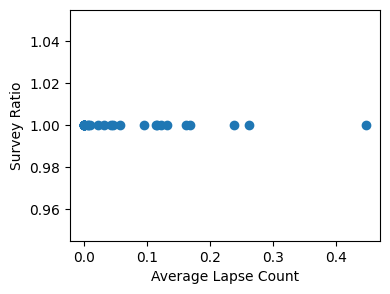

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1938, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1491, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1706, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1496, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1835, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1153, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1927, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1983, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1402, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1777, device='cuda:1', grad_fn=<MeanBackward0>)


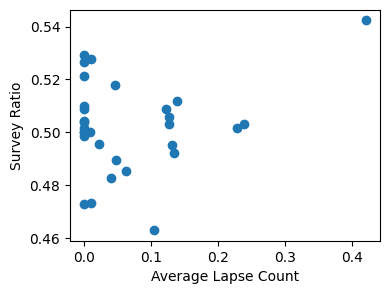

Average Survey Ratio: 0.5025266722737454
AUC = 0.89
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1967, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2121, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1630, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1618, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2072, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1585, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1577, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1395, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1529, device='cuda:1', grad_fn=<MeanBackward0>)


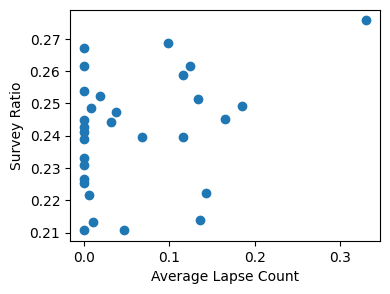

Average Survey Ratio: 0.24138249546800206
AUC = 0.88
tensor(0.1842, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1750, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2048, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1493, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2263, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1886, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1941, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1544, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2060, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1525, device='cuda:1', grad_fn=<MeanBackward0>)


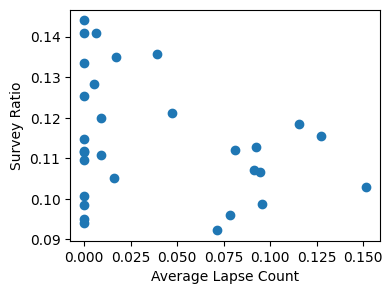

Average Survey Ratio: 0.11464424990447405
AUC = 0.86
tensor(0.1785, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1727, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1534, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1796, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1866, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1890, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1986, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1838, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1747, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>)


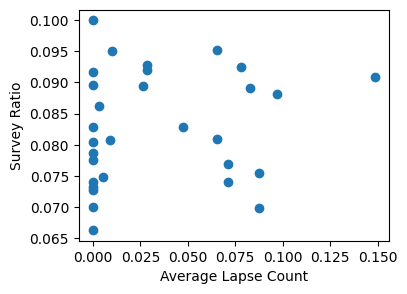

Average Survey Ratio: 0.08280572090976958
AUC = 0.87
-----------------------------------------------
torch.Size([30237, 173]) torch.Size([6979, 173])
598 1752 6979
XgBoost: AUC = 0.92
torch.Size([30237, 173])
tensor(0.1709, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.92
---------------------------------------------------
Device set to : cuda:1
tensor(0.2450, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1807, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2003, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2233, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1807, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1824, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1908, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2048, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1778, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1614, device='cuda:1', grad_fn=<MeanBackward0>)


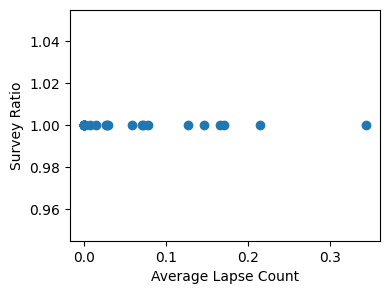

Average Survey Ratio: 1.0
AUC = 0.91
tensor(0.2120, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2047, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1589, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1530, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1465, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1931, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2207, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1915, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1651, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1957, device='cuda:1', grad_fn=<MeanBackward0>)


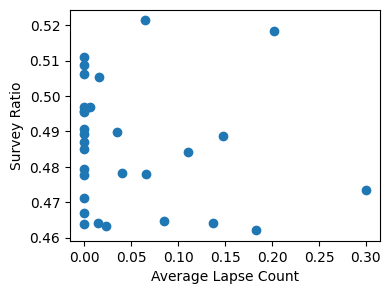

Average Survey Ratio: 0.4859213631431936
AUC = 0.90
tensor(0.1840, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1471, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1669, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2068, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1914, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1818, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1699, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1916, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1608, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1524, device='cuda:1', grad_fn=<MeanBackward0>)


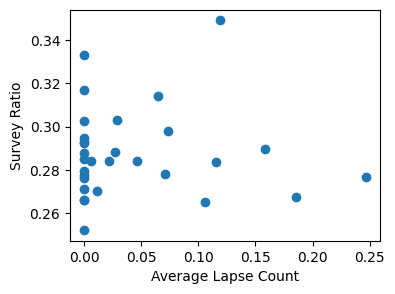

Average Survey Ratio: 0.28766988191769916
AUC = 0.89
tensor(0.1863, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1856, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1949, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2296, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2086, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1634, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1906, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1825, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1778, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1933, device='cuda:1', grad_fn=<MeanBackward0>)


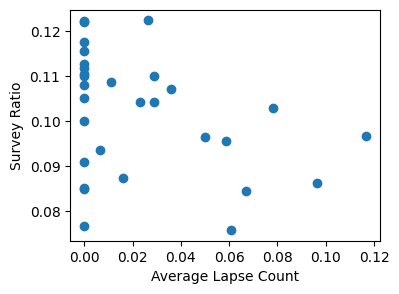

Average Survey Ratio: 0.10164733486769774
AUC = 0.85
tensor(0.1596, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1582, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1747, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2022, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2034, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2114, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1505, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1578, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1865, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1922, device='cuda:1', grad_fn=<MeanBackward0>)


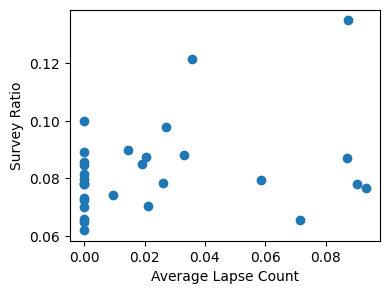

Average Survey Ratio: 0.0826003244646343
AUC = 0.86
-----------------------------------------------
torch.Size([30074, 173]) torch.Size([7142, 173])
558 1781 7142
XgBoost: AUC = 0.87
torch.Size([30074, 173])
tensor(0.1970, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.85
---------------------------------------------------
Device set to : cuda:1
tensor(0.2121, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1618, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1786, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2035, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1686, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1588, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1884, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1394, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1608, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1587, device='cuda:1', grad_fn=<MeanBackward0>)


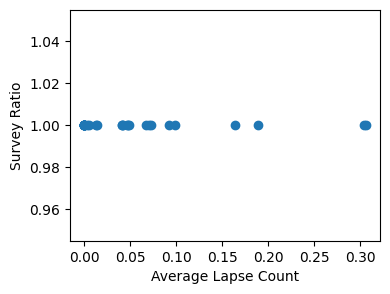

Average Survey Ratio: 1.0
AUC = 0.85
tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1742, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1792, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1630, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1446, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1627, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1615, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2208, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1658, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1702, device='cuda:1', grad_fn=<MeanBackward0>)


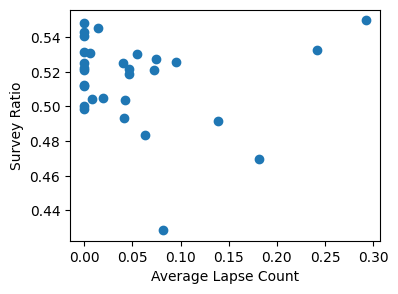

Average Survey Ratio: 0.5153712170892161
AUC = 0.84
tensor(0.2198, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1937, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1343, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1897, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1751, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2047, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1738, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1892, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2005, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1956, device='cuda:1', grad_fn=<MeanBackward0>)


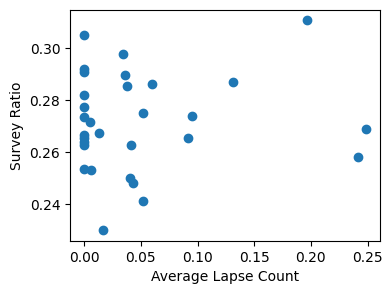

Average Survey Ratio: 0.2718107740050927
AUC = 0.82
tensor(0.2038, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1756, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1915, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2081, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2107, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2010, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1579, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1791, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1825, device='cuda:1', grad_fn=<MeanBackward0>)


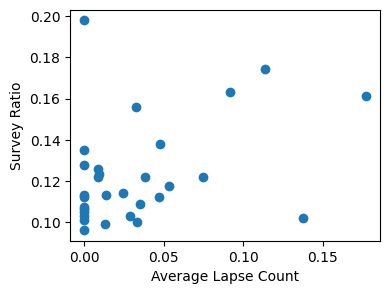

Average Survey Ratio: 0.12287168998689003
AUC = 0.80
tensor(0.2006, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1975, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1829, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1776, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2225, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1851, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1966, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2068, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1793, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2199, device='cuda:1', grad_fn=<MeanBackward0>)


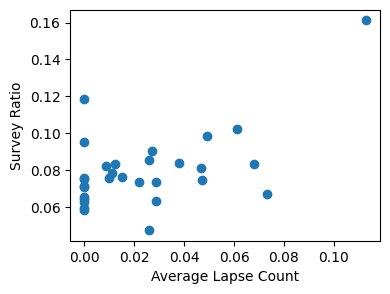

Average Survey Ratio: 0.07997621486414436
AUC = 0.80
-----------------------------------------------
torch.Size([29531, 173]) torch.Size([7685, 173])
488 1529 7685
XgBoost: AUC = 0.88
torch.Size([29531, 173])
tensor(0.2024, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.90
---------------------------------------------------
Device set to : cuda:1
tensor(0.2166, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1989, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2159, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1699, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1867, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1878, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1403, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2000, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1573, device='cuda:1', grad_fn=<MeanBackward0>)


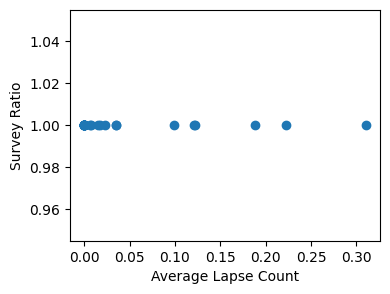

Average Survey Ratio: 1.0
AUC = 0.90
tensor(0.1527, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2042, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1498, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1665, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1834, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2181, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1629, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1331, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1876, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)


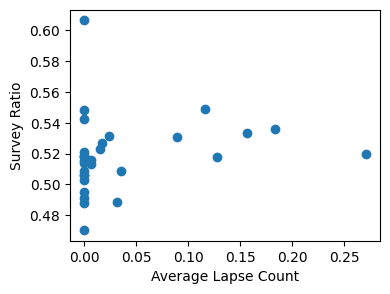

Average Survey Ratio: 0.5187971506575192
AUC = 0.88
tensor(0.2241, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1941, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1656, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2259, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1781, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1500, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2058, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1745, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2098, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1857, device='cuda:1', grad_fn=<MeanBackward0>)


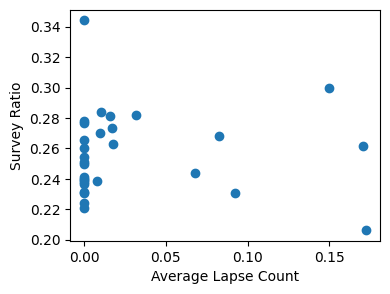

Average Survey Ratio: 0.2561503054437376
AUC = 0.89
tensor(0.2211, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2346, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2037, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2157, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1749, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1803, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1526, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1695, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1566, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1932, device='cuda:1', grad_fn=<MeanBackward0>)


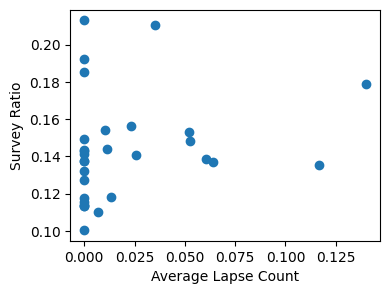

Average Survey Ratio: 0.14340220893011324
AUC = 0.87
tensor(0.1990, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2404, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2197, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2331, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2222, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1768, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2030, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2116, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1608, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2065, device='cuda:1', grad_fn=<MeanBackward0>)


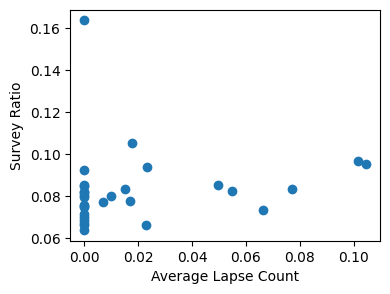

Average Survey Ratio: 0.08277237436064552
AUC = 0.88
-----------------------------------------------
torch.Size([29283, 173]) torch.Size([7933, 173])
589 1909 7933
XgBoost: AUC = 0.88
torch.Size([29283, 173])
tensor(0.1659, grad_fn=<MeanBackward0>)
myFCN: AUC = 0.86
---------------------------------------------------
Device set to : cuda:1
tensor(0.2070, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1997, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2284, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1885, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1523, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2045, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1995, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1475, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2118, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1714, device='cuda:1', grad_fn=<MeanBackward0>)


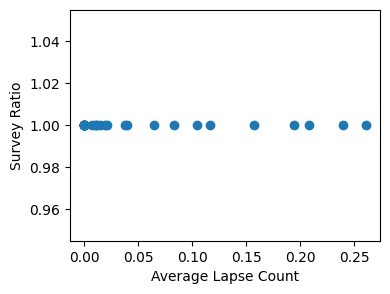

Average Survey Ratio: 1.0
AUC = 0.86
tensor(0.1840, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2164, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1788, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1771, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1716, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1653, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1599, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1306, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1701, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1478, device='cuda:1', grad_fn=<MeanBackward0>)


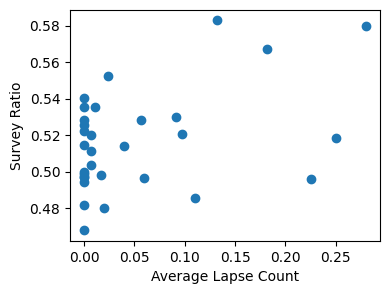

Average Survey Ratio: 0.5168827197757073
AUC = 0.86
tensor(0.2126, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1649, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1798, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1707, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1791, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1820, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1761, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2028, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1503, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2028, device='cuda:1', grad_fn=<MeanBackward0>)


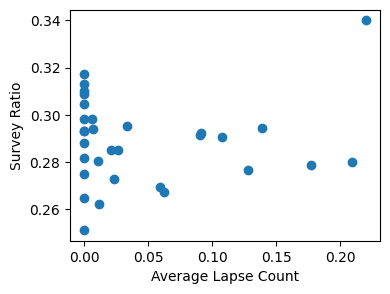

Average Survey Ratio: 0.2888602657070523
AUC = 0.84
tensor(0.1532, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1770, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1677, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2098, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1613, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1447, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1936, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1797, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1719, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1907, device='cuda:1', grad_fn=<MeanBackward0>)


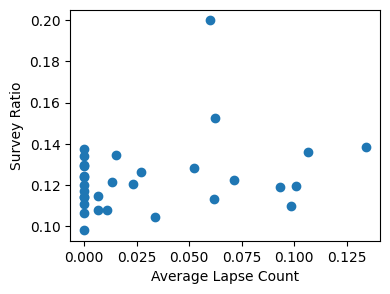

Average Survey Ratio: 0.12378925137931773
AUC = 0.86
tensor(0.2093, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1939, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2055, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2088, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2138, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1815, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1961, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2448, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1647, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.1727, device='cuda:1', grad_fn=<MeanBackward0>)


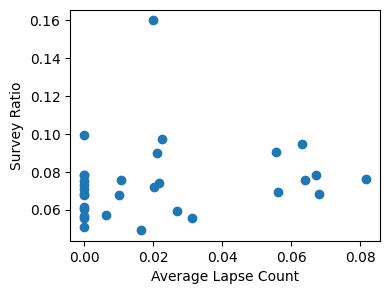

Average Survey Ratio: 0.07440542691312658
AUC = 0.86
-----------------------------------------------
{'xg': [0.8883328428332685, 0.9156549622913761, 0.8658717560110968, 0.8813058492040171, 0.8808098083602427], 1: [0.896379963539495, 0.9127392200612291, 0.8489345845473114, 0.8952973347273568, 0.8611915620804065], 2: [0.8881175191441006, 0.8966856035292902, 0.8382885957921234, 0.8819024946642158, 0.8567549685408968], 4: [0.8803992962491928, 0.8945985128299472, 0.8203783365343158, 0.8885481655607869, 0.8420909299392272], 10: [0.8624962628566489, 0.8530748684823622, 0.7954142114913094, 0.8737612951206901, 0.8587495977451535], 20: [0.8717155473338403, 0.8630430589558571, 0.8020114745423902, 0.8782582735976056, 0.8578432528453751]}
key:  xg mean:  0.8882367002978576 median:  0.8862802123365334
key:  1 mean:  0.8823472447193476 median:  0.8851504407385209
key:  2 mean:  0.8715564049289062 median:  0.874896945469892
key:  4 mean:  0.8640546258000492 median:  0.86274920165282
key:  10 mean:  0.

In [40]:
AUC_dict = {}
for j in range(6):
    dic = k_fold_test()
    if( j == 0 ):
        AUC_dict = dic
    else:
        for key in AUC_dict.keys():
            AUC_dict[key].extend(dic[key])
            
for key in AUC_dict.keys():
    print('sample every:', key, 'mean:', np.mean(AUC_dict[key]), 'median:', np.median(AUC_dict[key]))